# Objective

In this notebook, we will attempt to use the DeepAR forecasting algorithm, to produce re-order points and safety stocks for ERIKS' SKUs. Specifically, we begin by working within the project 21SC12, which seeks to calculate re-order points for all of Sealing and Polymer's (S+P's) Irregular SKUs (as grouped by Slimstock). We will also calculate safety stock levels, by calculating re-order points. 

We begin with the required theory.

[Update - 19 Oct 2021] The business only required safety stocks, so we only proceed with those, and not re-order points.

# Theory 

Many different versions of the ROP and SS equations exist. Here, we'll highlight the different formulae across different sources.
1. https://www.stitchlabs.com/learning-center/safety-stock-reorder-point-lead-time-calculate-formulas/  
__Safety stock__:
$$
S = Z \times \sigma_{L} \times \bar{D},
$$
where $S$ represents the safety stock level, $Z$ represents the z-score of the desired service level (see https://www.mathsisfun.com/data/confidence-interval.html), $\sigma_{L}$ represents the standard deviation of the lead time $L$, and $\bar{D}$ represents the average of the demand per unit time.   
__Re-order point__:
$$  
R = D_{L} + S,
$$
where $R$ represents the re-order point, $D_L$ represents the lead-time demand, and $S$ represents the safety stock level. 
The lead-time demand can be calculated in a few ways, which we discuss later.

2. https://www.skuvault.com/blog/safety-stock-formula/
__Safety stock__:
$$
S = Z \times \sigma_{L} \times \bar{D},
$$
Or:  
Basic formula:
$$
S = Sales \times Days
$$
Average - Max:
$$
S = (Max\_sales \times Max\_L) - (Average\_sales \times Average\_L) 
$$
Uncertainty about demand and lead time:
$$
S = Z \times \sqrt{\bar{L}\times \sigma_{D}^2 + \bar{D} \times \sigma_{L}^2}
$$

__Re-order point__:
$$
R = D_{L} + S
$$
$$
D_L = \bar{D} \times L
$$

3. https://www.logiwa.com/blog/safety-stock
__Safety stock__:
$$
S = Z \times \sigma_{L} \times \bar{D},
$$

4. https://abcsupplychain.com/en/safety-stock-formula-calculation/  
__Re-order point__:
$$
R = D_{L} + S
$$
$$
D_L = \bar{D} \times L
$$
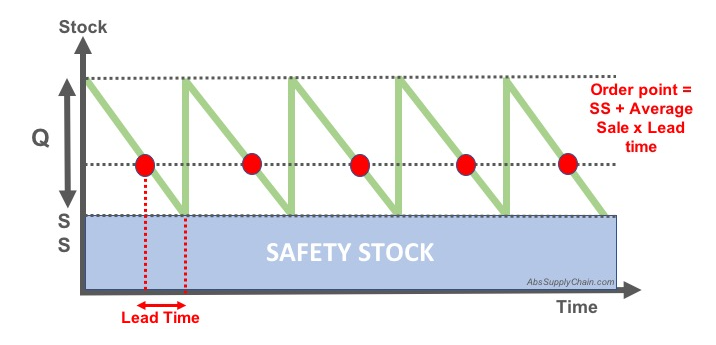
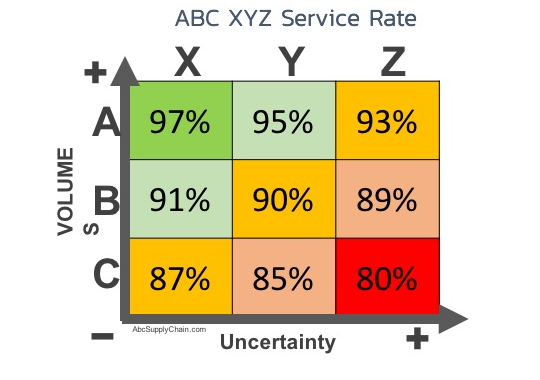

5. https://web.mit.edu/2.810/www/files/readings/King_SafetyStock.pdf
__Safety stock__:
$$
S = Z \times \sigma_{L} \times \bar{D},
$$
$$
S = Z \times \sqrt{\bar{L}\times \sigma_{D}^2 + \bar{D} \times \sigma_{L}^2}
$$

EOQ:
https://www.eazystock.com/uk/blog-uk/calculating-economic-order-quantity-formula/:

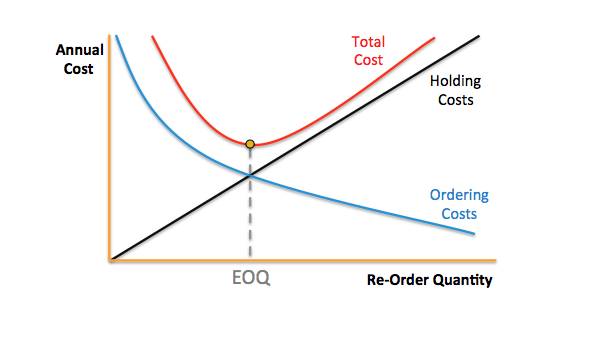

I don't think we have to deal with EOQ or MOQ in any drastic way. Just indicate when stock has dropped below the re-order point, and order the EOQ/MOQ, whichever is lowest? 


# Import Packages

In [1]:
%matplotlib inline
import pandas as pd
import ERIKS_forecasting as EF
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import importlib
import os.path as path
import matplotlib as mpl
import Plotting_ED
import time
from datetime import datetime
import random
import pickle
import importlib
import time
import scipy.stats as st
import datetime as dt

We requested data on:
1. Stock levels
2. Lead times - they're said to stay relatively static, but we will need a measure of the standard deviation of the lead times, so historic data on recorded lead times would be useful. 
3. MOQ and EOQ
4. Service levels
5. Current safety stock levels
6. Current reorder point levels
7. Product classes 

We'll need the following information to calculate the safety stock level:
1. Desired service level
2. Average lead time 
3. Standard deviation of demand 
4. Average demand 
5. Standard deviation of lead time 

We'll need this additional information to calculate reorder points:
1. A forecast of the lead time demand 

# Restart Data Import

Post speaking to Anil regarding DataBricks, and the deployment of this project, I've decided to do the following:
1. Make weekly/monthly extracts myself, from SAP or EveryAngle, of all the required data. 
2. Upload it to DataBricks, and run the deployed code at the same time interval (weekly/monthly)
3. Have the results saved to a .csv file, or a sharepoint location, or ideally directly fed back into SAP. 

Data to gather:
1. Desired service level - via ABC class
2. Average lead time - EveryAngle
3. Standard deviation of demand - EveryAngle
4. Average demand - EveryAngle
5. Standard deviation of lead time - EveryAngle

## Demand data

Angle:
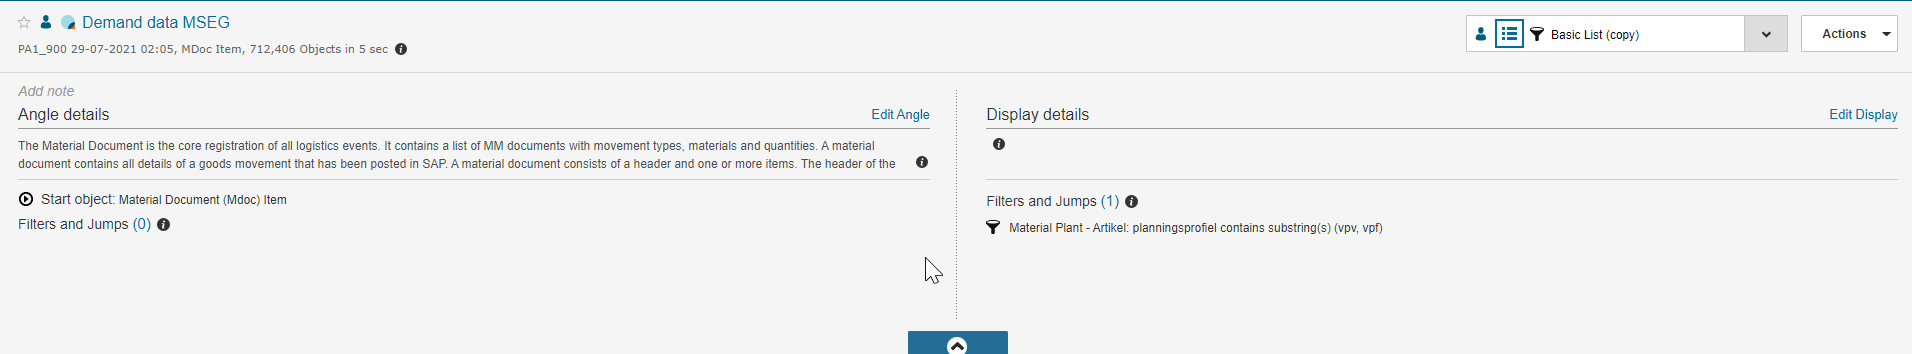

In [2]:
filepath = r"Data\EA_Data\Demand_data_2_Aug_2021.csv"
df_demand = pd.read_csv(filepath, sep=';')
print (len(df_demand))
print (df_demand.columns)
df_demand.head()

328648
Index(['(Self) Object Type EA', '(Self) ID', 'MDoc Header Posting Date',
       '(Self) Movement Type', 'MDoc Header Document Type',
       'Material Material', 'Material Description', '(Self) Quantity',
       '(Self) Valuated stock', 'Material Base Unit of Measure', 'Plant Plant',
       '(Self) Debit/Credit Ind.', '(Self) Quantity +/-',
       'MDoc Header User name', '(Self) Text', '(Self) Storage Location',
       'Material Plant EA_PROPERTY_PlanProfiel',
       'Material Plant ABC Indicator', '(Self) Reason for Movement',
       '(Self) Base Unit of Measure'],
      dtype='object')


C:\Users\shahe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,Plant Plant,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure
0,MDoc Item,49005016/1998/6,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014281,Hose cutter,11.00,0.0,Piece,EN01 (ERIKS BV Alkmaar),S,11.00,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,C (Material - Low Significance),561\0,Piece (items)
1,MDoc Item,49005028/1998/5,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,66.92,0.0,m,EN01 (ERIKS BV Alkmaar),S,66.92,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),561\0,m (Meter)
2,MDoc Item,49005028/1998/6,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,145.74,0.0,m,EN01 (ERIKS BV Alkmaar),S,145.74,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),561\0,m (Meter)
3,MDoc Item,49005028/1998/7,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,234.25,0.0,m,EN01 (ERIKS BV Alkmaar),S,234.25,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),561\0,m (Meter)
4,MDoc Item,49005039/1998/2,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014735,Hose Flexair EF-1 PVC coil=6m 90,84.00,0.0,m,EN01 (ERIKS BV Alkmaar),S,84.00,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,C (Material - Low Significance),561\0,m (Meter)


In [3]:
df_demand['Material Material'].nunique()

3137

## Lead-time Data

Angle:
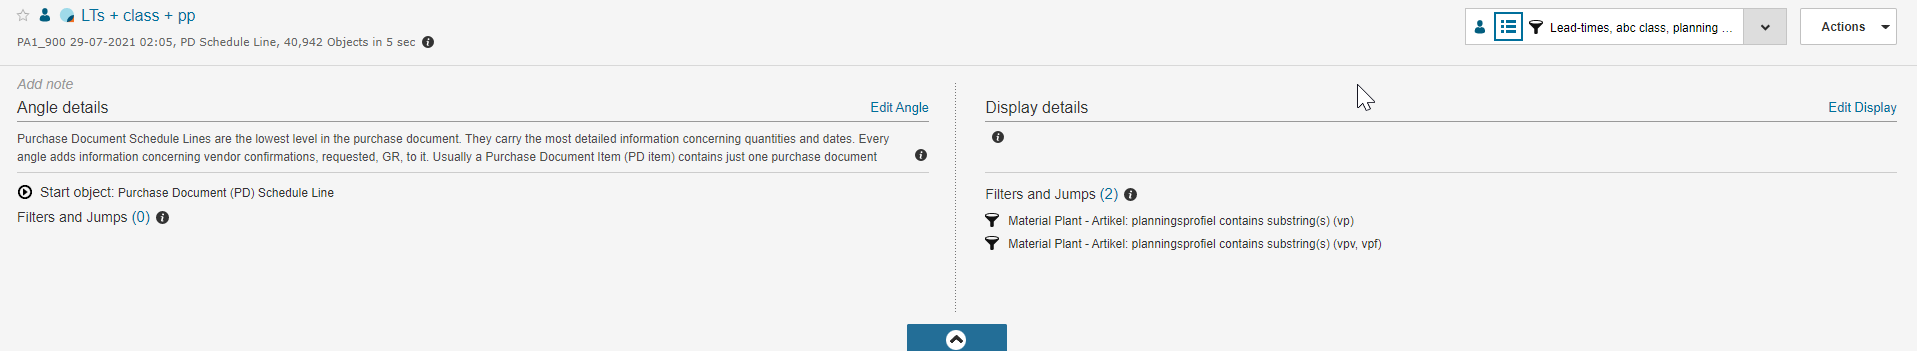

In [4]:
filepath = r"Data\EA_Data\LTs_2_Aug_2021.csv"
df_lt = pd.read_csv(filepath, sep=';')
print (len(df_lt))
df_lt.head()

31478


,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,...,(Self) Order Status Purchase,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group
0,PD Schedule Line,4200052434/10/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,Closed by GR,28-01-2021,Delivered on time,False,300.00,26-01-2021,18-01-2021,C (Material - Low Significance),VPVZ,NORM (Standard item)
1,PD Schedule Line,4200053371/10/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,1000.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,Closed by GR,22-03-2021,Delivered on time,False,400.00,19-03-2021,10-03-2021,C (Material - Low Significance),VPVZ,NORM (Standard item)
2,PD Schedule Line,4200053855/10/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,...,Closed by GR,14-04-2021,Delivered late,False,266.12,16-04-2021,07-04-2021,B (Material - Medium Significance),VPVZ,NORM (Standard item)
3,PD Schedule Line,4200054135/10/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,...,Closed by GR,17-05-2021,Delivered on time,False,266.12,14-05-2021,23-04-2021,B (Material - Medium Significance),VPVZ,NORM (Standard item)
4,PD Schedule Line,4502508772/10/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,13283620,ATAG EC Housing iCon 1 PP EP548 C60749A,840.0,Piece,ATAG EC Housing iCon 1 PP EP548 C60749A,...,Closed by GR,28-11-2018,Delivered early,False,2562.00,09-08-2018,02-01-2018,A (Significant Material),VPFZ,NORM (Standard item)


## Forecast Lines Data

Feedback from Hans - forecast lines need to be included in demand calculations. 

In [5]:
filepath = r"Data\EA_Data\Forecast_lines_data_13_Aug_2021.csv"
df_forecast_lines = pd.read_csv(filepath, sep=';')
print (len(df_forecast_lines))
df_forecast_lines.head()

8353


,(Self) Object Type EA,(Self) ID,(Self) Execution Status,Plant Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,(Self) Quantity Closed,(Self) Quantity Open,...,(Self) Open Quantity Value,(Self) Consumption ind.,(Self) Created On,(Self) Forecast Covers Current Date,(Self) Forecast Realization %,(Self) Order Nos. Consuming Orders,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock,(Self) MRP Relevant
0,Indep. Req.,VSF 2022-03-01/202203,Open,EN01 (ERIKS BV Alkmaar),10014736,Hose Flexair EF-1 PVC coil=6m 102,6.0,m,0,6.0,...,20.375000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,20.375000,NaN,True
1,Indep. Req.,VSF 2021-08-02/202108,Open,EN01 (ERIKS BV Alkmaar),10014792,"Hose Erivide coil=50m 13x3,2",1.0,m,0,1.0,...,3.490000,1 (Consume only with customer requirements),NaN,True,0.0,NaN,0.0,0.000000,NaN,True
2,Indep. Req.,VSF 2021-12-01/202112,Open,EN01 (ERIKS BV Alkmaar),10014792,"Hose Erivide coil=50m 13x3,2",2.0,m,0,2.0,...,6.980000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True
3,Indep. Req.,VSF 2021-10-01/202110,Open,EN01 (ERIKS BV Alkmaar),10015458,Hose Abratape 06 Food 15m 50x4,105.0,m,0,105.0,...,636.941667,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,636.941667,NaN,True
4,Indep. Req.,VSF 2021-12-01/202112,Open,EN01 (ERIKS BV Alkmaar),10015458,Hose Abratape 06 Food 15m 50x4,150.0,m,0,150.0,...,909.916667,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True


# EDA

## What does each dataset represent?  
df_demand represents all material documents for all SKUs with planning profile vpf, vpv.   
df_lt represents lead-time information via purchase documents. 105 date - processing date.   

## How many SKUs are in each dataset?

In [6]:
print (len(df_demand))
print (df_demand['Material Material'].nunique())
print (len(df_lt))
print (df_lt['Material Material'].nunique())
print (len(df_forecast_lines))
print (df_forecast_lines['Material Material'].nunique())

328648
3137
31478
2168
8353
984


Seem to be more SKUs in df_demand with vpf, vpv profiles.   
Let's restrict df_demand to the document types we desire.  
This email is useful to see the demand data we want:  
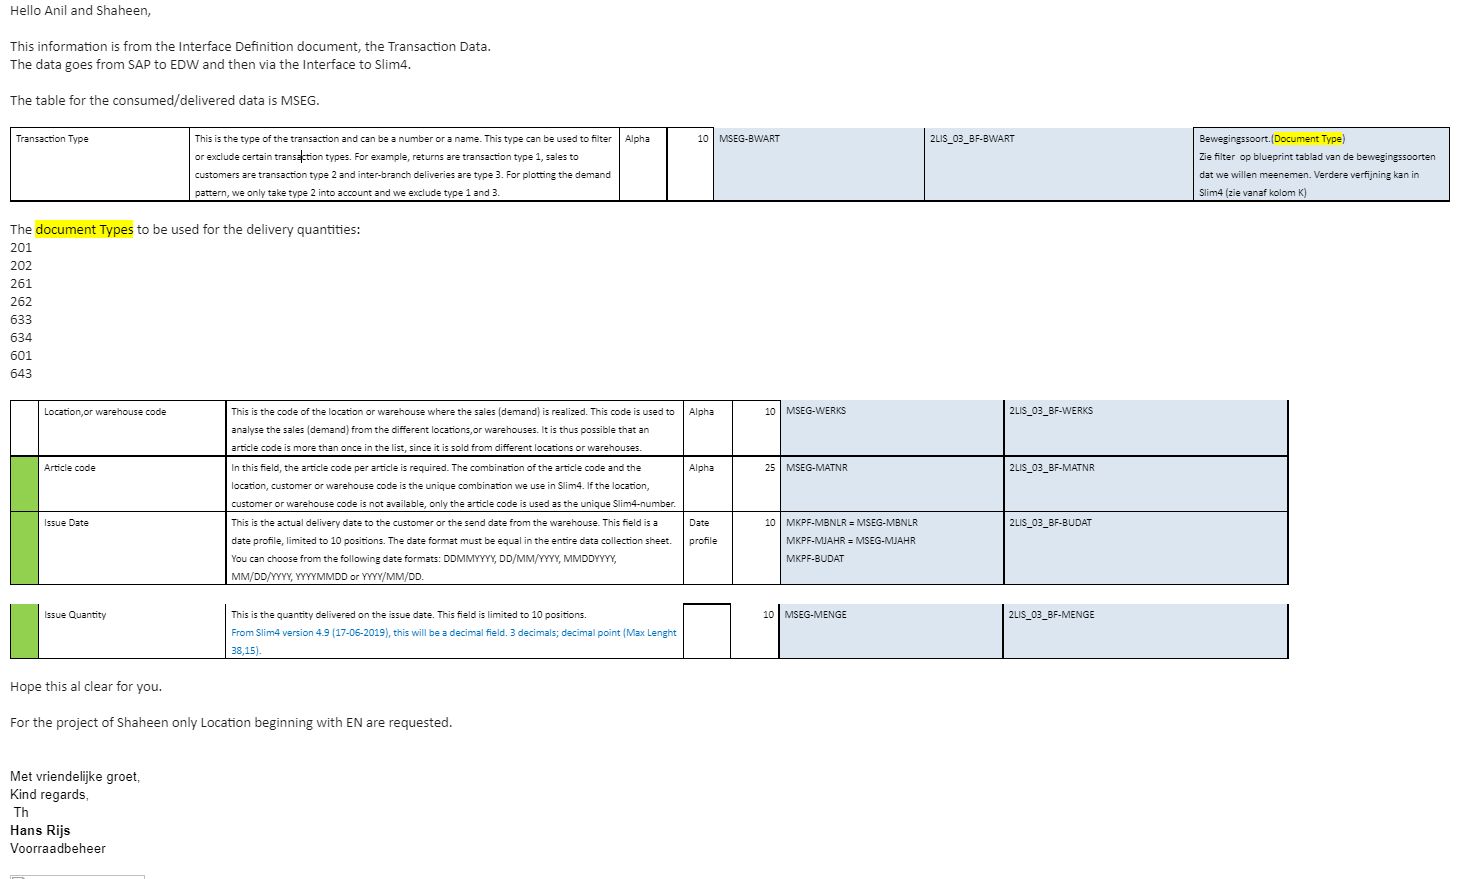

In conclusion, we filter on MSEG-BWART, which is in the EA angle as '(Self) Movement Type'

## Restrict Movement Types in Demand Data

In [7]:
print (df_demand['(Self) Movement Type'].value_counts())

261 (GI for order)            103323
601 (GD goods issue:delvy)     76500
343 (TF blocked to unre.)      27799
105 (GR from blocked stck)     26390
103 (GR into blocked stck)     24906
101 (GR goods receipt)         20585
350 (TR blocked to QI)         13788
311 (TF tfr. within plant)      4934
262 (RE for order)              4355
711 (GI InvDiff.:whouse)        3151
541 (GI whse to subc.stck)      2996
641 (TF to stck in trans.)      2759
712 (GR InvDiff.:wrhouse)       2745
411 (TF SLoc to SLoc)           2652
951 (951)                       2555
344 (TR blocked to unre.)       2066
309 (TF tfr ps.mat.to mat)      1588
543 (GI issue sls.ord.st.)      1520
653 (GD returns unrestr.)        736
104 (GR to blocked   rev.)       560
551 (GI scrapping)               554
561 (Initial stock entry)        337
201 (GI for cost center)         266
321 (TF quality to unrest)       264
121 (GR subseq. adjustm.)        228
102 (GR for PO   reversal)       207
643 (TF to cross company)        154
1

In [8]:
print (df_demand['(Self) Movement Type'])
df_demand['(Self) Movement Type - code'] = df_demand['(Self) Movement Type'].str[:3]
df_demand.head()

0          561 (Initial stock entry)
1          561 (Initial stock entry)
2          561 (Initial stock entry)
3          561 (Initial stock entry)
4          561 (Initial stock entry)
                     ...            
328643     343 (TF blocked to unre.)
328644     343 (TF blocked to unre.)
328645     343 (TF blocked to unre.)
328646    601 (GD goods issue:delvy)
328647    601 (GD goods issue:delvy)
Name: (Self) Movement Type, Length: 328648, dtype: object


,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,...,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code
0,MDoc Item,49005016/1998/6,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014281,Hose cutter,11.00,0.0,Piece,...,S,11.00,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,C (Material - Low Significance),561\0,Piece (items),561
1,MDoc Item,49005028/1998/5,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,66.92,0.0,m,...,S,66.92,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),561\0,m (Meter),561
2,MDoc Item,49005028/1998/6,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,145.74,0.0,m,...,S,145.74,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),561\0,m (Meter),561
3,MDoc Item,49005028/1998/7,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,234.25,0.0,m,...,S,234.25,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),561\0,m (Meter),561
4,MDoc Item,49005039/1998/2,31-12-1998,561 (Initial stock entry),WA (Goods issue),10014735,Hose Flexair EF-1 PVC coil=6m 90,84.00,0.0,m,...,S,84.00,990097,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,C (Material - Low Significance),561\0,m (Meter),561


In [9]:
df_demand['(Self) Movement Type - code'].value_counts()

261    103323
601     76500
343     27799
105     26390
103     24906
101     20585
350     13788
311      4934
262      4355
711      3151
541      2996
641      2759
712      2745
411      2652
951      2555
344      2066
309      1588
543      1520
653       736
104       560
551       554
561       337
201       266
321       264
121       228
102       207
643       154
122       129
106       103
952        56
562        55
654        49
531        43
631        42
633        36
544        31
301        28
322        26
202        25
701        19
349        18
717        17
542        12
702        10
413        10
532         7
310         5
922         3
412         2
718         2
123         1
553         1
Name: (Self) Movement Type - code, dtype: int64

In [10]:
movement_type_list = ['201','202','261','262','633', '634', '601', '643']
df_demand_movement_type_filtered = df_demand[df_demand['(Self) Movement Type - code'].isin(movement_type_list)]
df_demand_movement_type_filtered['(Self) Movement Type - code'].value_counts()


261    103323
601     76500
262      4355
201       266
643       154
633        36
202        25
Name: (Self) Movement Type - code, dtype: int64

## Re-examine number of SKUs per dataset

In [11]:
print (len(df_demand))
print (df_demand['Material Material'].nunique())
print (len(df_demand_movement_type_filtered))
print (df_demand_movement_type_filtered['Material Material'].nunique())
print (len(df_lt))
print (df_lt['Material Material'].nunique())

328648
3137
184659
3091
31478
2168


There's still many more VP SKUs in material documents table than in purchase documents. 
Let's investigate the distribution of planning profiles across the two datasets.

## Planning profile distribution

### Unique plannning profiles per SKU?

First, check if each SKU has one planning profile:

In [12]:
test = df_demand_movement_type_filtered.groupby('Material Material')['Material Plant EA_PROPERTY_PlanProfiel'].nunique() > 1
print (test.value_counts())
print (test[test])

False    3090
True        1
Name: Material Plant EA_PROPERTY_PlanProfiel, dtype: int64
Material Material
12682316    True
Name: Material Plant EA_PROPERTY_PlanProfiel, dtype: bool


In [13]:
df_demand_movement_type_filtered_12682316 = df_demand_movement_type_filtered[
    df_demand_movement_type_filtered['Material Material'] == 12682316]
df_demand_movement_type_filtered_12682316.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,...,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code
79531,MDoc Item,171882582/2018/3,15-01-2018,261 (GI for order),WA (Goods issue),12682316,"Male 12425 Las DIN 29x1,5 316L DN25",28.0,456.0,Piece,...,H,-28.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,B (Material - Medium Significance),261\0,Piece (items),261
81398,MDoc Item,171962506/2018/4,24-01-2018,261 (GI for order),WA (Goods issue),12682316,"Male 12425 Las DIN 29x1,5 316L DN25",14.0,428.0,Piece,...,H,-14.0,108540,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,B (Material - Medium Significance),261\0,Piece (items),261
84283,MDoc Item,172083915/2018/4,08-02-2018,261 (GI for order),WA (Goods issue),12682316,"Male 12425 Las DIN 29x1,5 316L DN25",21.0,414.0,Piece,...,H,-21.0,108540,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,B (Material - Medium Significance),261\0,Piece (items),261
88383,MDoc Item,172234017/2018/3,28-02-2018,261 (GI for order),WA (Goods issue),12682316,"Male 12425 Las DIN 29x1,5 316L DN25",21.0,300.0,Piece,...,H,-21.0,107153,NaN,EN04\EN01 (Mag.Capelle),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261
88385,MDoc Item,172234029/2018/3,28-02-2018,261 (GI for order),WA (Goods issue),12682316,"Male 12425 Las DIN 29x1,5 316L DN25",21.0,279.0,Piece,...,H,-21.0,107153,NaN,EN04\EN01 (Mag.Capelle),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261


In [14]:
test = df_lt.groupby('Material Material')['Material Plant EA_PROPERTY_PlanProfiel'].nunique() > 1
print (test.value_counts())
print (test[test])

False    2167
True        1
Name: Material Plant EA_PROPERTY_PlanProfiel, dtype: int64
Material Material
12682316    True
Name: Material Plant EA_PROPERTY_PlanProfiel, dtype: bool


So it appears only one SKU, 12682316, has two planning profiles.

Let's now check the distribution of planning profiles:

In [15]:
df_demand_movement_type_filtered.groupby('Material Material').first()['Material Plant EA_PROPERTY_PlanProfiel'].value_counts()

VPVZ    1600
VPFZ    1491
Name: Material Plant EA_PROPERTY_PlanProfiel, dtype: int64

In [16]:
df_lt.groupby('Material Material').first()['Material Plant EA_PROPERTY_PlanProfiel'].value_counts()

VPVZ    1292
VPFZ     876
Name: Material Plant EA_PROPERTY_PlanProfiel, dtype: int64

So, there are more VPVZ than VPFZ across two datasets. But no clear indication that we're only missing 'some VPFZ' or anything like that. Check overlap of SKUs in two datasets.

## Overlap of SKUs in two datasets

In [17]:
SKUs_demand_data = df_demand_movement_type_filtered['Material Material'].unique().tolist()
SKUs_lt_data = df_lt['Material Material'].unique().tolist()

In [18]:
print (len(set(SKUs_demand_data) & set(SKUs_lt_data)))

2140


So there are roughly 2k of the same SKUs, between lead-time and demand data. Lead-time data roughly 2k anyway. So basically, demand data has more SKUs. 

We've also filtered demand data to document types only relevant for Slim4's demand calculation. So is it the case that not all SKUs have purchase documents made, in the pipeline of ordering --> stock management --> delivery to customer? We make around 40% of SKUs in-house too, could this be why we don't see purchase documents for these? 

Timeline:
Friday - calculate safety stock estimates for SKU set.
Monday - compare to safety stocks in system, where available. 
Tuesday - produce visualisation of safety stock curves. Edit where needed. 

## Dates check - earliest date available?

In [19]:
df_demand_movement_type_filtered_date_sorted = df_demand_movement_type_filtered.sort_values(by="MDoc Header Posting Date", ascending = True)
df_demand_movement_type_filtered_date_sorted.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,...,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code
82941,MDoc Item,172037485/2018/1,01-02-2018,601 (GD goods issue:delvy),WL (Goods issue/delivery),11272459,O-ring SCVBR® 75 5x1 CLR,27.0,27.0,Piece,...,H,-27.0,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601
82860,MDoc Item,172031901/2018/49,01-02-2018,261 (GI for order),WA (Goods issue),11472287,ASM Cap LD-PE 12x10 4022.439.60374,10.0,1564.0,Piece,...,H,-10.0,108528,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,C (Material - Low Significance),261\0,Piece (items),261
82863,MDoc Item,172032400/2018/1,01-02-2018,601 (GD goods issue:delvy),WL (Goods issue/delivery),12759997,"DAF Profile, sidescreen EPDM60",700.0,25709.0,Piece,...,H,-700.0,100319,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,B (Material - Medium Significance),601\0,Piece (items),601
82864,MDoc Item,172032408/2018/1,01-02-2018,601 (GD goods issue:delvy),WL (Goods issue/delivery),12931372,"DAF Sheet ABS 3,0",600.0,4943.0,Piece,...,H,-600.0,100319,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,D (No usage),601\0,Piece (items),601
82865,MDoc Item,172032416/2018/1,01-02-2018,601 (GD goods issue:delvy),WL (Goods issue/delivery),12936527,DAF Cap protection 140x120 EPDM70 =20,140.0,3280.0,Piece,...,H,-140.0,100319,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,D (No usage),601\0,Piece (items),601


In [20]:
df_lt_sorted = df_lt.sort_values(by="(Self) Date of Goods Receipt", ascending = True)

In [21]:
df_lt_sorted.head()

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,...,(Self) Order Status Purchase,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group
6373,PD Schedule Line,4502749777/10/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,11091656,ASM 4022 456.05621/455.66904 besch wat,10.0,Piece,ASM 4022 456.0562.1/455.6690.4 besch wat,...,Closed by GR,01-02-2019,Delivered on time,False,521.60,01-02-2019,23-01-2019,C (Material - Low Significance),VPVZ,NORM (Standard item)
6575,PD Schedule Line,4502751046/10/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,10066001,ASM ERIKS nippel 25SBAW13MPN,10.0,Piece,ASM ERIKS nippel 25SBAW13MPN,...,Closed by GR,01-02-2019,Delivered on time,False,52.60,01-02-2019,25-01-2019,C (Material - Low Significance),VPVZ,NORM (Standard item)
6576,PD Schedule Line,4502751046/20/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,10066002,ASM ERIKS koppeling 25KBAK13BPN,10.0,Piece,ASM ERIKS koppeling 25KBAK13BPN,...,Closed by GR,01-02-2019,Delivered on time,False,128.15,01-02-2019,25-01-2019,C (Material - Low Significance),VPVZ,NORM (Standard item)
5914,PD Schedule Line,4502747027/30/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,11625102,"ASM 1-oorklem Oetiker 154 SS 5,6-6,5",600.0,Piece,"ASM 1-oorklem Oetiker 154 SS 5,6-6,5",...,Closed by GR,31-01-2019,Delivered on time,False,154.59,01-02-2019,18-01-2019,C (Material - Low Significance),VPVZ,NORM (Standard item)
6604,PD Schedule Line,4502751105/10/1,EN01 (ERIKS BV),EN01 (ERIKS BV Alkmaar),Closed,12747061,ASM YS CT PCW LEAK MANIFOLD 659.17561,3.0,Piece,ASM YS CT PCW LEAK MANIFOLD 659.17561,...,Closed by GR,22-02-2019,Delivered early,False,279.00,01-02-2019,25-01-2019,D (No usage),VPVZ,NORM (Standard item)


So the demand dataset has an earliest date of 1st Feb 2018, while the lead-time dataset has an earliest date of 1st Feb 2019. 

## Notes from meeting with Thijs - 30 July 2021:
From 6K, some probs not purchased
Also, some are components probably, 
In Thijs' list, some are production items, so won't have pr

Norm, items = purchased
ZVPR = inventory production 

TAN, stock items

TAB, 

Z001, make it, don't make it on stock

position type group, filter on NORM, SAP: MVKE - MTPOS

There should be no ZVPR in purchase docs 

Archive - SARI - MM EKKO

ZVPR or NORM 

The discrepancy in SKU numbers could be due to a few factors:
1. NORM vs ZVPR articles - some articles are purchased (NORM), while some are made in-house (ZVPR). Thus, we are only interested in NORM articles. 
2. Dates - SAP only has roughly 2-3 years of data, and as shown above, both datasets are truncated, at different years.

I've now added the position type group to the lead-time data, and have made an extract of the position type group data, from the Material Sales table, as it can't be attached to the Material Documents table in EveryAngle. 

We now need to join position type group data to the Material Documents data

## Examine distributions of position type groups (NORM vs ZVPR) 

### Import position type group information

In [22]:
filepath = r"Data\EA_Data\PTG_and_SS_data_9_Aug_2021.csv"
df_ptg = pd.read_csv(filepath, sep=';')
print (len(df_ptg))
print (df_ptg.columns)
df_ptg.head()

3182
Index(['(Self) Object Type EA', 'Material Material', 'Material Description',
       'Sales Org. Sales Org.', '(Self) Distribution Channel',
       '(Self) Item category group', '(Self) DF distr. chain lvl',
       '(Self) Minimum order qty', 'Material Base Unit of Measure',
       '(Self) Delivery unit', '(Self) Sales unit', '(Self) Material group 1',
       '(Self) Material group 2', '(Self) DChain-spec. status',
       'Material Material Group', 'Material Material Type',
       'Material X-plant matl status', 'Material Demand Last Year',
       'Material Demand Last Quarter',
       'Material Plant EA_PROPERTY_PlanProfiel',
       'Material Plant Material Plant', 'Material Plant Safety Stock'],
      dtype='object')


,(Self) Object Type EA,Material Material,Material Description,Sales Org. Sales Org.,(Self) Distribution Channel,(Self) Item category group,(Self) DF distr. chain lvl,(Self) Minimum order qty,Material Base Unit of Measure,(Self) Delivery unit,...,(Self) Material group 2,(Self) DChain-spec. status,Material Material Group,Material Material Type,Material X-plant matl status,Material Demand Last Year,Material Demand Last Quarter,Material Plant EA_PROPERTY_PlanProfiel,Material Plant Material Plant,Material Plant Safety Stock
0,Material Sales,10014281,Hose cutter,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,1.00,Piece,1.00,...,20 (Customer-specific published),Z1 (Standard),06525010 (Other accessories),HALB (Semifinished product),NaN,296.000,56.000,VPVZ,10014281/EN01,0
1,Material Sales,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,0.01,m,0.01,...,90 (Do not publish),Z1 (Standard),06225010 (Hoses type 160M/161M),HALB (Semifinished product),NaN,623.760,89.600,VPVZ,10014530/EN01,60
2,Material Sales,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,0.01,m,0.01,...,90 (Do not publish),Z1 (Standard),06225010 (Hoses type 160M/161M),HALB (Semifinished product),NaN,269.525,125.360,VPVZ,10014531/EN01,15
3,Material Sales,10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,0.01,m,0.01,...,90 (Do not publish),Z1 (Standard),06225010 (Hoses type 160M/161M),HALB (Semifinished product),NaN,660.210,124.465,VPVZ,10014532/EN01,100
4,Material Sales,10014735,Hose Flexair EF-1 PVC coil=6m 90,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,6.00,m,6.00,...,10 (General published),Z1 (Standard),06150130 (Flexair hoses),HALB (Semifinished product),NaN,114.000,6.000,VPFZ,10014735/EN01,20


In [23]:
df_ptg['Plant'] = df_ptg['Material Plant Material Plant'].str[-4:]
df_ptg.Plant.value_counts()

EN01    3153
EN04      29
Name: Plant, dtype: int64

In [24]:
df_ptg['(Self) Item category group'].value_counts()

NORM (Standard item)           2175
ZVPR (Inventory - prod.)        952
ZVLO (Inventory - subcont.)      54
BANC (Indiv.Purchase Order)       1
Name: (Self) Item category group, dtype: int64

In [25]:
df_ptg['(Self) Item category group - code'] = df_ptg['(Self) Item category group'].str[:4]
df_ptg['(Self) Item category group - code'].value_counts()

NORM    2175
ZVPR     952
ZVLO      54
BANC       1
Name: (Self) Item category group - code, dtype: int64

### Limit position type group data to one row per SKU

In [26]:
#test = df_ptg.groupby('Material Material')['(Self) Item category group - code'].nunique() > 1
#print (test.value_counts())
#print (test[test])

LEGACY: This is a problem. There are 199 SKUs, for which there are multiple position type groups. 
I think this is because some SKUs are at multiple locations. 
So we're going to have to calculate safety stocks for SKU-location combinations again, as in the forecasting project.

SOLVED: By filtering the PTG data to just EN01, i.e. only Dutch SKUs, we don't get any duplicate rows when joining PTG data to demand table. Nice!

In [27]:
print (len(df_ptg))

3182


In [28]:
print (df_ptg['Material Material'].nunique())

3182


### Create SKU-location combinations for all datasets

Even though we've limited the sales organisation in the PTG data to EN01 (and the Plants in the demand and lead-time data to wildcard 'ENXX', we should still be able to see the different plants that each SKU is at. Some can even be at multiple plants, so it's best to create a unique Plant-SKU identifier for all three of our datasets, demand, lead-time and PTG. 

#### Demand data

In [29]:
df_demand_movement_type_filtered.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,...,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code
77274,MDoc Item,171786623/2018/3,02-01-2018,261 (GI for order),WA (Goods issue),13210904,"ASM Adapter 161M DN8 9,53x0,89",28.0,32.0,Piece,...,H,-28.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261
77277,MDoc Item,171788532/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12682363,"Nut 12444 DIN/BS/ISO 304 DN65-2.1/2""",6.0,1073.0,Piece,...,H,-6.0,108560,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),261\0,Piece (items),261
77280,MDoc Item,171788712/2018/2,02-01-2018,261 (GI for order),WA (Goods issue),12673832,ASM hose Wtz RS331S12 DN20 489.72315,81.0,462.0,m,...,H,-81.0,108529,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,m (Meter),261
77281,MDoc Item,171788720/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12470740,ASML Screwbase assy 4022.651.2058.5,50.0,50.0,Piece,...,H,-50.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,Piece (items),261
77284,MDoc Item,171788934/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12681347,Landing strip verpakking LSV11,5.0,95.0,Piece,...,H,-5.0,108543,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261


In [30]:
df_demand_movement_type_filtered['Plant Plant'] = df_demand_movement_type_filtered['Plant Plant'].str[:4]
df_demand_movement_type_filtered['Plant Plant'].value_counts()

<ipython-input-30-92693c14236f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_movement_type_filtered['Plant Plant'] = df_demand_movement_type_filtered['Plant Plant'].str[:4]


EN01    179311
EN04      5347
EN11         1
Name: Plant Plant, dtype: int64

In [31]:
df_demand_movement_type_filtered['Material Material'] = df_demand_movement_type_filtered['Material Material'].astype(str)

<ipython-input-31-8fca766cbf7c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_movement_type_filtered['Material Material'] = df_demand_movement_type_filtered['Material Material'].astype(str)


In [32]:
df_demand_movement_type_filtered['Plant-Material'] = df_demand_movement_type_filtered['Plant Plant'] + df_demand_movement_type_filtered['Material Material']

<ipython-input-32-0ad1ccf8556c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_movement_type_filtered['Plant-Material'] = df_demand_movement_type_filtered['Plant Plant'] + df_demand_movement_type_filtered['Material Material']


In [33]:
df_demand_movement_type_filtered.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,...,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material
77274,MDoc Item,171786623/2018/3,02-01-2018,261 (GI for order),WA (Goods issue),13210904,"ASM Adapter 161M DN8 9,53x0,89",28.0,32.0,Piece,...,-28.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0113210904
77277,MDoc Item,171788532/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12682363,"Nut 12444 DIN/BS/ISO 304 DN65-2.1/2""",6.0,1073.0,Piece,...,-6.0,108560,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),261\0,Piece (items),261,EN0112682363
77280,MDoc Item,171788712/2018/2,02-01-2018,261 (GI for order),WA (Goods issue),12673832,ASM hose Wtz RS331S12 DN20 489.72315,81.0,462.0,m,...,-81.0,108529,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,m (Meter),261,EN0112673832
77281,MDoc Item,171788720/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12470740,ASML Screwbase assy 4022.651.2058.5,50.0,50.0,Piece,...,-50.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,Piece (items),261,EN0112470740
77284,MDoc Item,171788934/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12681347,Landing strip verpakking LSV11,5.0,95.0,Piece,...,-5.0,108543,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0112681347


In [34]:
df_demand_movement_type_filtered['Plant-Material'].value_counts()

EN0112682361    1344
EN0111447738    1058
EN0111037657    1019
EN0111547497     955
EN0111528887     881
                ... 
EN0114118664       1
EN0111478917       1
EN0112614920       1
EN0114148732       1
EN0111587176       1
Name: Plant-Material, Length: 3104, dtype: int64

#### Forecast lines data

In [35]:
df_forecast_lines['Plant Plant'] = df_forecast_lines['Plant Plant'].str[:4]
df_forecast_lines['Plant Plant'].value_counts()


EN01    8353
Name: Plant Plant, dtype: int64

In [36]:
df_forecast_lines['Material Material'] = df_forecast_lines['Material Material'].astype(str)
df_forecast_lines['Plant-Material'] = df_forecast_lines['Plant Plant'] + df_forecast_lines['Material Material']

In [37]:
df_forecast_lines.head()

,(Self) Object Type EA,(Self) ID,(Self) Execution Status,Plant Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,(Self) Quantity Closed,(Self) Quantity Open,...,(Self) Consumption ind.,(Self) Created On,(Self) Forecast Covers Current Date,(Self) Forecast Realization %,(Self) Order Nos. Consuming Orders,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock,(Self) MRP Relevant,Plant-Material
0,Indep. Req.,VSF 2022-03-01/202203,Open,EN01,10014736,Hose Flexair EF-1 PVC coil=6m 102,6.0,m,0,6.0,...,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,20.375000,NaN,True,EN0110014736
1,Indep. Req.,VSF 2021-08-02/202108,Open,EN01,10014792,"Hose Erivide coil=50m 13x3,2",1.0,m,0,1.0,...,1 (Consume only with customer requirements),NaN,True,0.0,NaN,0.0,0.000000,NaN,True,EN0110014792
2,Indep. Req.,VSF 2021-12-01/202112,Open,EN01,10014792,"Hose Erivide coil=50m 13x3,2",2.0,m,0,2.0,...,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110014792
3,Indep. Req.,VSF 2021-10-01/202110,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,105.0,m,0,105.0,...,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,636.941667,NaN,True,EN0110015458
4,Indep. Req.,VSF 2021-12-01/202112,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,150.0,m,0,150.0,...,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110015458


#### Lead-time data

In [38]:
df_lt['Plant Plant'].value_counts()

EN01 (ERIKS BV Alkmaar)     30494
EN04 (ERIKS BV Capelle)       975
EN11 (ERIKS BV Rijnmond)        9
Name: Plant Plant, dtype: int64

In [39]:
df_lt['Material Material'] = df_lt['Material Material'].astype(str)
df_lt['Plant Plant'] = df_lt['Plant Plant'].str[:4]
df_lt['Plant-Material'] = df_lt['Plant Plant'] + df_lt['Material Material']
df_lt.head()

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,...,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material
0,PD Schedule Line,4200052434/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,28-01-2021,Delivered on time,False,300.00,26-01-2021,18-01-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
1,PD Schedule Line,4200053371/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,1000.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,22-03-2021,Delivered on time,False,400.00,19-03-2021,10-03-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
2,PD Schedule Line,4200053855/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,...,14-04-2021,Delivered late,False,266.12,16-04-2021,07-04-2021,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596
3,PD Schedule Line,4200054135/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,...,17-05-2021,Delivered on time,False,266.12,14-05-2021,23-04-2021,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596
4,PD Schedule Line,4502508772/10/1,EN01 (ERIKS BV),EN01,Closed,13283620,ATAG EC Housing iCon 1 PP EP548 C60749A,840.0,Piece,ATAG EC Housing iCon 1 PP EP548 C60749A,...,28-11-2018,Delivered early,False,2562.00,09-08-2018,02-01-2018,A (Significant Material),VPFZ,NORM (Standard item),EN0113283620


#### PTG data

In [40]:
df_ptg['Material Material'] = df_ptg['Material Material'].astype(str)
df_ptg['Plant-Material'] = df_ptg['Plant'] + df_ptg['Material Material']
df_ptg.head()

,(Self) Object Type EA,Material Material,Material Description,Sales Org. Sales Org.,(Self) Distribution Channel,(Self) Item category group,(Self) DF distr. chain lvl,(Self) Minimum order qty,Material Base Unit of Measure,(Self) Delivery unit,...,Material Material Type,Material X-plant matl status,Material Demand Last Year,Material Demand Last Quarter,Material Plant EA_PROPERTY_PlanProfiel,Material Plant Material Plant,Material Plant Safety Stock,Plant,(Self) Item category group - code,Plant-Material
0,Material Sales,10014281,Hose cutter,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,1.00,Piece,1.00,...,HALB (Semifinished product),NaN,296.000,56.000,VPVZ,10014281/EN01,0,EN01,NORM,EN0110014281
1,Material Sales,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,0.01,m,0.01,...,HALB (Semifinished product),NaN,623.760,89.600,VPVZ,10014530/EN01,60,EN01,NORM,EN0110014530
2,Material Sales,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,0.01,m,0.01,...,HALB (Semifinished product),NaN,269.525,125.360,VPVZ,10014531/EN01,15,EN01,NORM,EN0110014531
3,Material Sales,10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,0.01,m,0.01,...,HALB (Semifinished product),NaN,660.210,124.465,VPVZ,10014532/EN01,100,EN01,NORM,EN0110014532
4,Material Sales,10014735,Hose Flexair EF-1 PVC coil=6m 90,EN01 (ERIKS bv Nederland),01 (General),NORM (Standard item),False,6.00,m,6.00,...,HALB (Semifinished product),NaN,114.000,6.000,VPFZ,10014735/EN01,20,EN01,NORM,EN0110014735


In [41]:
print (len(df_ptg))
print (df_ptg['Plant-Material'].nunique())
print (df_ptg['Material Material'].nunique())

test = df_ptg.groupby('Plant-Material')['(Self) Item category group - code'].nunique() > 1
print (test.value_counts())
print (test[test])

3182
3182
3182
False    3182
Name: (Self) Item category group - code, dtype: int64
Series([], Name: (Self) Item category group - code, dtype: bool)


### Try to join PTG data to material documents

In [42]:
df_demand_movement_type_filtered = pd.merge(df_demand_movement_type_filtered, 
         df_ptg[['Plant-Material', '(Self) Item category group - code']], 
         on='Plant-Material', 
         how='left')
print (len(df_demand_movement_type_filtered))
print (len(df_ptg))
df_demand_movement_type_filtered.head()
print (len(df_demand_movement_type_filtered))

184659
3182
184659


In [43]:
df_demand_movement_type_filtered.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,...,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material,(Self) Item category group - code
0,MDoc Item,171786623/2018/3,02-01-2018,261 (GI for order),WA (Goods issue),13210904,"ASM Adapter 161M DN8 9,53x0,89",28.0,32.0,Piece,...,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0113210904,NORM
1,MDoc Item,171788532/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12682363,"Nut 12444 DIN/BS/ISO 304 DN65-2.1/2""",6.0,1073.0,Piece,...,108560,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),261\0,Piece (items),261,EN0112682363,NORM
2,MDoc Item,171788712/2018/2,02-01-2018,261 (GI for order),WA (Goods issue),12673832,ASM hose Wtz RS331S12 DN20 489.72315,81.0,462.0,m,...,108529,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,m (Meter),261,EN0112673832,NORM
3,MDoc Item,171788720/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12470740,ASML Screwbase assy 4022.651.2058.5,50.0,50.0,Piece,...,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,Piece (items),261,EN0112470740,ZVLO
4,MDoc Item,171788934/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12681347,Landing strip verpakking LSV11,5.0,95.0,Piece,...,108543,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0112681347,ZVPR


In [44]:
df_demand_movement_type_filtered['Plant-Material'].nunique()

3104

### See how many PTGs per SKU

In [45]:
test = df_demand_movement_type_filtered.groupby('Plant-Material')['(Self) Item category group - code'].nunique() > 1
print (test.value_counts())
print (test[test])

False    3104
Name: (Self) Item category group - code, dtype: int64
Series([], Name: (Self) Item category group - code, dtype: bool)


Okay good, so all Plant-Materials have one PTG group.

In [46]:
df_demand_movement_type_filtered_one_row_per_SKU = df_demand_movement_type_filtered.groupby('Plant-Material').head(1).reset_index(drop=True)
df_demand_movement_type_filtered_one_row_per_SKU['(Self) Item category group - code'].value_counts()

NORM    2106
ZVPR     900
ZVLO      54
Name: (Self) Item category group - code, dtype: int64

Given that nearly all of the SKUs in the PTG dataset have joined onto the demand dataset, to get a rough indication of the PTG distribution across the demand dataset, we can also just look at the distribution across the PTG dataset:

In [47]:
df_ptg['(Self) Item category group - code'].value_counts()

NORM    2175
ZVPR     952
ZVLO      54
BANC       1
Name: (Self) Item category group - code, dtype: int64

Now, let's compare this to the distribution across the lead-time dataset:

In [48]:
test = df_lt.groupby('Plant-Material')['Material Plant EA_PROPERTY_PlanProfiel'].nunique() > 1
print (test.value_counts())
print (test[test])

False    2187
Name: Material Plant EA_PROPERTY_PlanProfiel, dtype: int64
Series([], Name: Material Plant EA_PROPERTY_PlanProfiel, dtype: bool)


Okay, so all Plant-Material identifiers have one PTG group, just as in the demand dataset. 

In [49]:
df_lt_one_row_per_SKU = df_lt.groupby('Plant-Material').head(1).reset_index(drop=True)
df_lt_one_row_per_SKU.head()

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,...,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material
0,PD Schedule Line,4200052434/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,28-01-2021,Delivered on time,False,300.00,26-01-2021,18-01-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
1,PD Schedule Line,4200053855/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,...,14-04-2021,Delivered late,False,266.12,16-04-2021,07-04-2021,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596
2,PD Schedule Line,4502508772/10/1,EN01 (ERIKS BV),EN01,Closed,13283620,ATAG EC Housing iCon 1 PP EP548 C60749A,840.0,Piece,ATAG EC Housing iCon 1 PP EP548 C60749A,...,28-11-2018,Delivered early,False,2562.00,09-08-2018,02-01-2018,A (Significant Material),VPFZ,NORM (Standard item),EN0113283620
3,PD Schedule Line,4502508772/20/1,EN01 (ERIKS BV),EN01,Closed,13283621,ATAG EC Housing iCon 2 PP EP548 C60752a,224.0,Piece,ATAG EC Housing iCon 2 PP EP548 C60752a,...,28-09-2018,Delivered early,False,672.00,09-08-2018,02-01-2018,A (Significant Material),VPFZ,NORM (Standard item),EN0113283621
4,PD Schedule Line,4502519009/10/1,EN01 (ERIKS BV),EN01,Closed,11474005,ASM BALL VLV DN50 F/F SS G2 489.72344,96.0,Piece,ASM BALL VLV DN50 F/F SS G2 489.72344,...,25-01-2019,Delivered late,False,9872.64,14-02-2019,18-01-2018,A (Significant Material),VPVZ,NORM (Standard item),EN0111474005


In [50]:
print (len(df_lt_one_row_per_SKU))
df_lt_one_row_per_SKU['Material Sales Item category group'].value_counts()

2187


NORM (Standard item)           2062
ZVPR (Inventory - prod.)         70
ZVLO (Inventory - subcont.)      53
BANC (Indiv.Purchase Order)       1
Name: Material Sales Item category group, dtype: int64

Okay, interesting. It looks like we have nearly all the NORM SKUs from the demand data, in the lead-time data. But we're missing most of the ZVPR SKUs from the lead-time data, whereas there are around 1000 in the demand data. 

This makes sense, as we don't purchase the ZVPR articles, so we may have material documents for them, but only in rare cases will we have purchase documents for them. So this explains the discrepancy in SKUs available to us, in the lead-time data. Going forward, let's use the Plant-SKU set which are:
1. In the lead-time and demand dataset.
2. Of PTG type 'NORM'.
3. At an 'ENXX' plant. 
4. Of planning profile 'VPZ' or 'VPV'. 

# Next Steps post EDA

We've now:
1. Filtered the data to NL. 
2. Joined PTG data to both the demand and lead-time datasets, which helped us explain the discrepancy in SKU numbers (mainly due to ZVPR articles).
3. Created a Plant-SKU unique identifier for both datasets. 

Next we want to:
1. Filter the SKU set to be only those which are in the lead-time AND demand datasets. 
2. Calculate, for these SKUs:  
    a. Average demand  
    b. Standard deviation in demand  
    c. Average lead-time  
    d. Standard deviation in lead-time   
3. Combine these values into a separate 'results' dataframe.
4. Calculate safety stock levels for all these SKUs. 
5. Compare ASML SKUs to safety stocks in Thijs' data. 

# Filter SKUs to those in demand and lead-time data

In [51]:
df_demand_movement_type_filtered.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,...,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material,(Self) Item category group - code
0,MDoc Item,171786623/2018/3,02-01-2018,261 (GI for order),WA (Goods issue),13210904,"ASM Adapter 161M DN8 9,53x0,89",28.0,32.0,Piece,...,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0113210904,NORM
1,MDoc Item,171788532/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12682363,"Nut 12444 DIN/BS/ISO 304 DN65-2.1/2""",6.0,1073.0,Piece,...,108560,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),261\0,Piece (items),261,EN0112682363,NORM
2,MDoc Item,171788712/2018/2,02-01-2018,261 (GI for order),WA (Goods issue),12673832,ASM hose Wtz RS331S12 DN20 489.72315,81.0,462.0,m,...,108529,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,m (Meter),261,EN0112673832,NORM
3,MDoc Item,171788720/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12470740,ASML Screwbase assy 4022.651.2058.5,50.0,50.0,Piece,...,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,Piece (items),261,EN0112470740,ZVLO
4,MDoc Item,171788934/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12681347,Landing strip verpakking LSV11,5.0,95.0,Piece,...,108543,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0112681347,ZVPR


In [52]:
df_demand_movement_type_filtered['Plant-Material'].nunique()

3104

In [53]:
print (len(df_demand_movement_type_filtered))

184659


In [54]:
df_lt.head()

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,...,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material
0,PD Schedule Line,4200052434/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,28-01-2021,Delivered on time,False,300.00,26-01-2021,18-01-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
1,PD Schedule Line,4200053371/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,1000.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,...,22-03-2021,Delivered on time,False,400.00,19-03-2021,10-03-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
2,PD Schedule Line,4200053855/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,...,14-04-2021,Delivered late,False,266.12,16-04-2021,07-04-2021,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596
3,PD Schedule Line,4200054135/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,...,17-05-2021,Delivered on time,False,266.12,14-05-2021,23-04-2021,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596
4,PD Schedule Line,4502508772/10/1,EN01 (ERIKS BV),EN01,Closed,13283620,ATAG EC Housing iCon 1 PP EP548 C60749A,840.0,Piece,ATAG EC Housing iCon 1 PP EP548 C60749A,...,28-11-2018,Delivered early,False,2562.00,09-08-2018,02-01-2018,A (Significant Material),VPFZ,NORM (Standard item),EN0113283620


In [55]:
df_lt['Plant-Material'].nunique()

2187

In [56]:
print (len(df_lt))

31478


In [57]:
SKUs_demand_data = df_demand_movement_type_filtered['Plant-Material'].unique().tolist()
SKUs_lt_data = df_lt['Plant-Material'].unique().tolist()
print (len(set(SKUs_demand_data) & set(SKUs_lt_data)))

2152


So there will be 2152 SKUs in our final dataset.

In [58]:
# Line to filter demand data on SKUs in LT data
df_demand_movement_type_filtered_lt_SKUs_filtered = df_demand_movement_type_filtered[df_demand_movement_type_filtered['Plant-Material'].isin(df_lt['Plant-Material'])]

In [59]:
# Count how many SKUs remain post LT filtering
df_demand_movement_type_filtered_lt_SKUs_filtered['Plant-Material'].nunique()

2152

In [60]:
#Check how many rows remain in demand data
print (len(df_demand_movement_type_filtered_lt_SKUs_filtered))

145523


In [61]:
# Filter LT SKUs based on SKUs in demand data
df_lt_demand_SKUs_filtered = df_lt[df_lt['Plant-Material'].isin(df_demand_movement_type_filtered['Plant-Material'])]

In [62]:
# Count how many SKUs remain post demand data filtering
df_lt_demand_SKUs_filtered['Plant-Material'].nunique()

2152

In [63]:
# Check length of new LT dataframe
print (len(df_lt_demand_SKUs_filtered))

31369


# Calculate safety stock quantities for SKUs:

## Create results dataframe, to store quantities, and eventual safety stock

In [64]:
set_of_SKUs = set(SKUs_demand_data) & set(SKUs_lt_data)

In [65]:
safety_stocks_df = pd.DataFrame(index = set_of_SKUs)
safety_stocks_df['ABC_class'] = np.nan
safety_stocks_df['DSL'] = np.nan
safety_stocks_df['mean_demand'] = np.nan
safety_stocks_df['std_dev_demand'] = np.nan
safety_stocks_df['mean_lead_time'] = np.nan
safety_stocks_df['std_dev_lead_time'] = np.nan
safety_stocks_df['safety_stock'] = np.nan
safety_stocks_df.head()

,ABC_class,DSL,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock
EN0113396509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EN0112553392,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EN0111857009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EN0112100341,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EN0112403883,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add in Z-score for SKUs, based on ABC classes

### Add ABC class data to safety stocks df

In [66]:
df_lt_one_row_per_SKU = df_lt.groupby('Plant-Material').head(1).reset_index(drop=True)
df_lt_one_row_per_SKU['Plant-Material'] = df_lt_one_row_per_SKU['Plant-Material'].astype(str)
print (len(safety_stocks_df))
safety_stocks_df = safety_stocks_df.merge(
         df_lt_one_row_per_SKU[['Plant-Material', 'Material Plant ABC Indicator']], 
         left_index = True,
         right_on = 'Plant-Material').set_index('Plant-Material')
print (len(safety_stocks_df))


2152
2152


In [67]:
safety_stocks_df.head()

,ABC_class,DSL,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant ABC Indicator
Plant-Material,,,,,,,,
EN0113396509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A (Significant Material)
EN0112553392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B (Material - Medium Significance)
EN0111857009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C (Material - Low Significance)
EN0112100341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D (No usage)
EN0112403883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C (Material - Low Significance)


In [68]:
safety_stocks_df['Material Plant ABC Indicator'] = safety_stocks_df['Material Plant ABC Indicator'].str[:1]
safety_stocks_df.head()

,ABC_class,DSL,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant ABC Indicator
Plant-Material,,,,,,,,
EN0113396509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
EN0112553392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B
EN0111857009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C
EN0112100341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D
EN0112403883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C


In [69]:
safety_stocks_df['Material Plant ABC Indicator'].value_counts()

B    785
C    700
A    435
D    224
N      8
Name: Material Plant ABC Indicator, dtype: int64

In [70]:
safety_stocks_df['ABC_class'] = safety_stocks_df['Material Plant ABC Indicator']
del safety_stocks_df['Material Plant ABC Indicator']
safety_stocks_df.head()

,ABC_class,DSL,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock
Plant-Material,,,,,,,
EN0113396509,A,NaN,NaN,NaN,NaN,NaN,NaN
EN0112553392,B,NaN,NaN,NaN,NaN,NaN,NaN
EN0111857009,C,NaN,NaN,NaN,NaN,NaN,NaN
EN0112100341,D,NaN,NaN,NaN,NaN,NaN,NaN
EN0112403883,C,NaN,NaN,NaN,NaN,NaN,NaN


We have more than just A, B and C classes, so for now, we're going to set the desired service levels (DSL) to:
1. A - 98%
2. B - 95% 
3. C and other - 90%

### Fill in DSL from ABC class

In [71]:
Class_A_DSL = 98
Class_B_DSL = 95
Class_C_DSL = 90
Class_rest_DSL = 80

In [72]:
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'A', 'DSL'] = Class_A_DSL
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'B', 'DSL'] = Class_B_DSL
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'C', 'DSL'] = Class_C_DSL
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'D', 'DSL'] = Class_rest_DSL
safety_stocks_df.loc[safety_stocks_df.ABC_class	 == 'N', 'DSL'] = Class_rest_DSL


### Calculate Z-score via DSL

In [73]:
safety_stocks_df['Z_score'] = st.norm.ppf(safety_stocks_df['DSL']/100.0) 

In [74]:
safety_stocks_df.head()

,ABC_class,DSL,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score
Plant-Material,,,,,,,,
EN0113396509,A,98.0,NaN,NaN,NaN,NaN,NaN,2.053749
EN0112553392,B,95.0,NaN,NaN,NaN,NaN,NaN,1.644854
EN0111857009,C,90.0,NaN,NaN,NaN,NaN,NaN,1.281552
EN0112100341,D,80.0,NaN,NaN,NaN,NaN,NaN,0.841621
EN0112403883,C,90.0,NaN,NaN,NaN,NaN,NaN,1.281552


## Calculate mean demand

### Calculate total demand

This needs a bit of thinking. First, let's use units of days, for this quantity and all others in the safety stock calculations. Next, let's calculate total demand/number of days. 
Number of days = today - 1st material document date. 

In [75]:
pd.set_option('display.max_columns', None)
df_demand_movement_type_filtered_lt_SKUs_filtered.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,Plant Plant,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material,(Self) Item category group - code
0,MDoc Item,171786623/2018/3,02-01-2018,261 (GI for order),WA (Goods issue),13210904,"ASM Adapter 161M DN8 9,53x0,89",28.0,32.0,Piece,EN01,H,-28.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0113210904,NORM
1,MDoc Item,171788532/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12682363,"Nut 12444 DIN/BS/ISO 304 DN65-2.1/2""",6.0,1073.0,Piece,EN01,H,-6.0,108560,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),261\0,Piece (items),261,EN0112682363,NORM
2,MDoc Item,171788712/2018/2,02-01-2018,261 (GI for order),WA (Goods issue),12673832,ASM hose Wtz RS331S12 DN20 489.72315,81.0,462.0,m,EN01,H,-81.0,108529,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,m (Meter),261,EN0112673832,NORM
3,MDoc Item,171788720/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12470740,ASML Screwbase assy 4022.651.2058.5,50.0,50.0,Piece,EN01,H,-50.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,Piece (items),261,EN0112470740,ZVLO
7,MDoc Item,171788934/2018/4,02-01-2018,261 (GI for order),WA (Goods issue),12679735,ASML DOOS TRANSPARANT WG1980,5.0,114.0,Piece,EN01,H,-5.0,108543,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0112679735,NORM


In [76]:
test_df = df_demand_movement_type_filtered_lt_SKUs_filtered[df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/-'] > 0]

In [77]:
print (len(test_df))

3362


In [78]:
test_df.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,Plant Plant,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material,(Self) Item category group - code
23,MDoc Item,171789370/2018/2,02-01-2018,262 (RE for order),WA (Goods issue),12340412,ASM BALL VLV HDL T BW SS DN32 489.73438,20.0,210.0,Piece,EN01,S,20.0,100534,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),262\0,Piece (items),262,EN0112340412,NORM
24,MDoc Item,171789370/2018/3,02-01-2018,262 (RE for order),WA (Goods issue),12682358,"Nut 12444 DIN/BS 304 DN32-1.1/4""",40.0,2076.0,Piece,EN01,S,40.0,100534,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),262\0,Piece (items),262,EN0112682358,NORM
25,MDoc Item,171789370/2018/4,02-01-2018,262 (RE for order),WA (Goods issue),12694474,"ASM Adapter RS331 DN32 45,7x35",40.0,854.0,Piece,EN01,S,40.0,100534,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),262\0,Piece (items),262,EN0112694474,NORM
47,MDoc Item,171790813/2018/1,02-01-2018,262 (RE for order),WA (Goods issue),12340412,ASM BALL VLV HDL T BW SS DN32 489.73438,20.0,170.0,Piece,EN01,S,20.0,100534,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),262\0,Piece (items),262,EN0112340412,NORM
48,MDoc Item,171790850/2018/1,02-01-2018,262 (RE for order),WA (Goods issue),12340412,ASM BALL VLV HDL T BW SS DN32 489.73438,20.0,190.0,Piece,EN01,S,20.0,100534,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),262\0,Piece (items),262,EN0112340412,NORM


In [79]:
test_df['(Self) Movement Type - code'].value_counts()

262    3345
202      17
Name: (Self) Movement Type - code, dtype: int64

Okay, so we want to add up the total demand for each SKU. We have two columns which we could use, '(Self) Quantity' and '(Self) Quantity +/-'. It seems that the movement types (262 and 202) give positive values. 
We'll need to double check this with the team. For now, I'm going to push forward with '(Self) Quantity +/-'. We want to flip the positive and negative values, as demand should be positive, but looks to be negative in this dataset. Whereas, what I assume are returns, are denoted positively (and are far fewer in frequency), and that should be negative demand. 


In [80]:
df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/- flipped'] = -1.0 * df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/-']

<ipython-input-80-526abae1f54a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/- flipped'] = -1.0 * df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/-']


In [81]:
df_demand_movement_type_filtered_lt_SKUs_filtered.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,Plant Plant,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material,(Self) Item category group - code,(Self) Quantity +/- flipped
0,MDoc Item,171786623/2018/3,02-01-2018,261 (GI for order),WA (Goods issue),13210904,"ASM Adapter 161M DN8 9,53x0,89",28.0,32.0,Piece,EN01,H,-28.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0113210904,NORM,28.0
1,MDoc Item,171788532/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12682363,"Nut 12444 DIN/BS/ISO 304 DN65-2.1/2""",6.0,1073.0,Piece,EN01,H,-6.0,108560,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),261\0,Piece (items),261,EN0112682363,NORM,6.0
2,MDoc Item,171788712/2018/2,02-01-2018,261 (GI for order),WA (Goods issue),12673832,ASM hose Wtz RS331S12 DN20 489.72315,81.0,462.0,m,EN01,H,-81.0,108529,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,m (Meter),261,EN0112673832,NORM,81.0
3,MDoc Item,171788720/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12470740,ASML Screwbase assy 4022.651.2058.5,50.0,50.0,Piece,EN01,H,-50.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,Piece (items),261,EN0112470740,ZVLO,50.0
7,MDoc Item,171788934/2018/4,02-01-2018,261 (GI for order),WA (Goods issue),12679735,ASML DOOS TRANSPARANT WG1980,5.0,114.0,Piece,EN01,H,-5.0,108543,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0112679735,NORM,5.0


In [82]:
df_demand_movement_type_filtered_lt_SKUs_filtered.describe()

,(Self) Quantity,(Self) Valuated stock,(Self) Quantity +/-,(Self) Quantity +/- flipped
count,145523.000000,1.455230e+05,145523.000000,145523.000000
mean,1266.957051,1.321385e+04,-1265.318189,1265.318189
std,15633.780603,8.780806e+04,15633.913331,15633.913331
min,0.001000,0.000000e+00,-960516.000000,-10000.000000
25%,4.000000,8.100000e+01,-140.000000,4.000000
50%,15.000000,3.000000e+02,-14.000000,14.000000
75%,140.000000,2.031000e+03,-4.000000,140.000000
max,960516.000000,5.219006e+06,10000.000000,960516.000000


In [83]:
summed_demand_df = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby(['Plant-Material'], as_index = False)['(Self) Quantity +/- flipped'].agg('sum')

In [84]:
summed_demand_df.head()

,Plant-Material,(Self) Quantity +/- flipped
0,EN0110014281,759.000
1,EN0110014530,4315.464
2,EN0110014531,1476.049
3,EN0110014532,2117.900
4,EN0110014735,258.000


#### EXTRA - Add in demand from forecast lines for SKU

This comes with a few problems. First, we want to sum the customer-predicted demand in df_forecast_lines, which is often (if not always) in the future, then add that to the actual demand observed. 

But what do we do about the timeframe of demand, for each SKU? Do we truncate it at today, or do we use the furthest date from now, and take (max(furthest date from now, today) - earliest material document date)?

I think we go for the latter. The weakness of the former is that if different customers forecast over different timescales, then demand per unit time may get inflated. The weakness of the latter is that if customer forecasts are really far from the actual demand observed, we may inflate or deflate the demand per unit time. But I'd rather the latter than the former. Customers should forecast their demand with some accuracy. 

In [85]:
df_forecast_lines.head()

,(Self) Object Type EA,(Self) ID,(Self) Execution Status,Plant Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,(Self) Quantity Closed,(Self) Quantity Open,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Bottleneck Type,(Self) Planning indicator,(Self) Material Value,(Self) Open Quantity Value,(Self) Consumption ind.,(Self) Created On,(Self) Forecast Covers Current Date,(Self) Forecast Realization %,(Self) Order Nos. Consuming Orders,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock,(Self) MRP Relevant,Plant-Material
0,Indep. Req.,VSF 2022-03-01/202203,Open,EN01,10014736,Hose Flexair EF-1 PVC coil=6m 102,6.0,m,0,6.0,01-03-2022,Not critical,None,1 (Net requirements planning),20.375000,20.375000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,20.375000,NaN,True,EN0110014736
1,Indep. Req.,VSF 2021-08-02/202108,Open,EN01,10014792,"Hose Erivide coil=50m 13x3,2",1.0,m,0,1.0,02-08-2021,Late,Planning shortage,1 (Net requirements planning),3.490000,3.490000,1 (Consume only with customer requirements),NaN,True,0.0,NaN,0.0,0.000000,NaN,True,EN0110014792
2,Indep. Req.,VSF 2021-12-01/202112,Open,EN01,10014792,"Hose Erivide coil=50m 13x3,2",2.0,m,0,2.0,01-12-2021,Critical,Planning shortage,1 (Net requirements planning),6.980000,6.980000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110014792
3,Indep. Req.,VSF 2021-10-01/202110,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,105.0,m,0,105.0,01-10-2021,Not critical,None,1 (Net requirements planning),636.941667,636.941667,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,636.941667,NaN,True,EN0110015458
4,Indep. Req.,VSF 2021-12-01/202112,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,150.0,m,0,150.0,01-12-2021,Not critical,None,1 (Net requirements planning),909.916667,909.916667,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110015458


In [86]:
summed_demand_df_forecast_lines = df_forecast_lines.groupby(['Plant-Material'], as_index = False)['(Self) Quantity'].agg('sum')

In [87]:
summed_demand_df_forecast_lines.head()

,Plant-Material,(Self) Quantity
0,EN0110014736,6.000
1,EN0110014792,3.000
2,EN0110015458,615.000
3,EN0110015806,300.365
4,EN0110015812,13300.000


In [88]:
summed_demand_df = pd.merge(summed_demand_df, 
         summed_demand_df_forecast_lines[['Plant-Material', '(Self) Quantity']], 
         on='Plant-Material', 
         how='left')
summed_demand_df.head()

,Plant-Material,(Self) Quantity +/- flipped,(Self) Quantity
0,EN0110014281,759.000,NaN
1,EN0110014530,4315.464,NaN
2,EN0110014531,1476.049,NaN
3,EN0110014532,2117.900,NaN
4,EN0110014735,258.000,NaN


In [89]:
print (summed_demand_df['(Self) Quantity +/- flipped'].isna().sum())
print (summed_demand_df['(Self) Quantity'].isna().sum())
print (len(summed_demand_df))

0
1506
2152


Okay, so 1506 out of 2152 SKUs seem to not have forecast lines currently.

In [90]:
# Add both demands together
summed_demand_df['total_demand'] = summed_demand_df['(Self) Quantity +/- flipped'] + summed_demand_df['(Self) Quantity'].fillna(0)
summed_demand_df.head(50)

,Plant-Material,(Self) Quantity +/- flipped,(Self) Quantity,total_demand
0,EN0110014281,759.000,NaN,759.000
1,EN0110014530,4315.464,NaN,4315.464
2,EN0110014531,1476.049,NaN,1476.049
3,EN0110014532,2117.900,NaN,2117.900
4,EN0110014735,258.000,NaN,258.000
5,EN0110014736,732.000,6.000,738.000
6,EN0110014792,1517.000,3.000,1520.000
7,EN0110014876,3997.200,NaN,3997.200
8,EN0110014877,2941.985,NaN,2941.985
9,EN0110015458,2432.430,615.000,3047.430


### Calculate number of days for each SKU

As noted above, let's do (max(furthest date from now, today) - earliest material document date).

In [91]:
df_demand_movement_type_filtered_lt_SKUs_filtered.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,Plant Plant,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material,(Self) Item category group - code,(Self) Quantity +/- flipped
0,MDoc Item,171786623/2018/3,02-01-2018,261 (GI for order),WA (Goods issue),13210904,"ASM Adapter 161M DN8 9,53x0,89",28.0,32.0,Piece,EN01,H,-28.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0113210904,NORM,28.0
1,MDoc Item,171788532/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12682363,"Nut 12444 DIN/BS/ISO 304 DN65-2.1/2""",6.0,1073.0,Piece,EN01,H,-6.0,108560,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),261\0,Piece (items),261,EN0112682363,NORM,6.0
2,MDoc Item,171788712/2018/2,02-01-2018,261 (GI for order),WA (Goods issue),12673832,ASM hose Wtz RS331S12 DN20 489.72315,81.0,462.0,m,EN01,H,-81.0,108529,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,m (Meter),261,EN0112673832,NORM,81.0
3,MDoc Item,171788720/2018/1,02-01-2018,261 (GI for order),WA (Goods issue),12470740,ASML Screwbase assy 4022.651.2058.5,50.0,50.0,Piece,EN01,H,-50.0,101155,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,A (Significant Material),261\0,Piece (items),261,EN0112470740,ZVLO,50.0
7,MDoc Item,171788934/2018/4,02-01-2018,261 (GI for order),WA (Goods issue),12679735,ASML DOOS TRANSPARANT WG1980,5.0,114.0,Piece,EN01,H,-5.0,108543,NaN,EN01\EN01 (Mag.Alkmaar),VPVZ,B (Material - Medium Significance),261\0,Piece (items),261,EN0112679735,NORM,5.0


Let's do max(furthest date from now, today) via:
1. Group by on forecast_lines data, get max(furthest date, today) per Plant-SKU combo 
2. Group by on demand data, get min date per Plant-SKU combo 
3. Join (1) to (2)
4. Fill nans in max date column with todays date 
5. Calc (max date - min date) in days, in new column

#### Group by on forecast_lines data, get max(furthest date, today) per Plant-SKU combo

In [92]:
df_forecast_lines.head()

,(Self) Object Type EA,(Self) ID,(Self) Execution Status,Plant Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,(Self) Quantity Closed,(Self) Quantity Open,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Bottleneck Type,(Self) Planning indicator,(Self) Material Value,(Self) Open Quantity Value,(Self) Consumption ind.,(Self) Created On,(Self) Forecast Covers Current Date,(Self) Forecast Realization %,(Self) Order Nos. Consuming Orders,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock,(Self) MRP Relevant,Plant-Material
0,Indep. Req.,VSF 2022-03-01/202203,Open,EN01,10014736,Hose Flexair EF-1 PVC coil=6m 102,6.0,m,0,6.0,01-03-2022,Not critical,None,1 (Net requirements planning),20.375000,20.375000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,20.375000,NaN,True,EN0110014736
1,Indep. Req.,VSF 2021-08-02/202108,Open,EN01,10014792,"Hose Erivide coil=50m 13x3,2",1.0,m,0,1.0,02-08-2021,Late,Planning shortage,1 (Net requirements planning),3.490000,3.490000,1 (Consume only with customer requirements),NaN,True,0.0,NaN,0.0,0.000000,NaN,True,EN0110014792
2,Indep. Req.,VSF 2021-12-01/202112,Open,EN01,10014792,"Hose Erivide coil=50m 13x3,2",2.0,m,0,2.0,01-12-2021,Critical,Planning shortage,1 (Net requirements planning),6.980000,6.980000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110014792
3,Indep. Req.,VSF 2021-10-01/202110,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,105.0,m,0,105.0,01-10-2021,Not critical,None,1 (Net requirements planning),636.941667,636.941667,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,636.941667,NaN,True,EN0110015458
4,Indep. Req.,VSF 2021-12-01/202112,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,150.0,m,0,150.0,01-12-2021,Not critical,None,1 (Net requirements planning),909.916667,909.916667,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110015458


In [93]:
today = pd.to_datetime("today")

df_forecast_lines['(Self) Order Due Date'] = pd.to_datetime(
    df_forecast_lines['(Self) Order Due Date'], 
    format="%d-%m-%Y", 
    errors='coerce')

df_forecast_lines['max(furthest date, today)'] = df_forecast_lines.groupby('Plant-Material')['(Self) Order Due Date'].transform(lambda x: max(x.max(), today))
df_forecast_lines.head(50)                                                                                                            

,(Self) Object Type EA,(Self) ID,(Self) Execution Status,Plant Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,(Self) Quantity Closed,(Self) Quantity Open,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Bottleneck Type,(Self) Planning indicator,(Self) Material Value,(Self) Open Quantity Value,(Self) Consumption ind.,(Self) Created On,(Self) Forecast Covers Current Date,(Self) Forecast Realization %,(Self) Order Nos. Consuming Orders,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock,(Self) MRP Relevant,Plant-Material,"max(furthest date, today)"
0,Indep. Req.,VSF 2022-03-01/202203,Open,EN01,10014736,Hose Flexair EF-1 PVC coil=6m 102,6.000,m,0,6.000,2022-03-01,Not critical,None,1 (Net requirements planning),20.375000,20.375000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,20.375000,NaN,True,EN0110014736,2022-03-01
1,Indep. Req.,VSF 2021-08-02/202108,Open,EN01,10014792,"Hose Erivide coil=50m 13x3,2",1.000,m,0,1.000,2021-08-02,Late,Planning shortage,1 (Net requirements planning),3.490000,3.490000,1 (Consume only with customer requirements),NaN,True,0.0,NaN,0.0,0.000000,NaN,True,EN0110014792,2021-12-01
2,Indep. Req.,VSF 2021-12-01/202112,Open,EN01,10014792,"Hose Erivide coil=50m 13x3,2",2.000,m,0,2.000,2021-12-01,Critical,Planning shortage,1 (Net requirements planning),6.980000,6.980000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110014792,2021-12-01
3,Indep. Req.,VSF 2021-10-01/202110,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,105.000,m,0,105.000,2021-10-01,Not critical,None,1 (Net requirements planning),636.941667,636.941667,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,636.941667,NaN,True,EN0110015458,2022-07-01
4,Indep. Req.,VSF 2021-12-01/202112,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,150.000,m,0,150.000,2021-12-01,Not critical,None,1 (Net requirements planning),909.916667,909.916667,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110015458,2022-07-01
5,Indep. Req.,VSF 2022-02-01/202202,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,135.000,m,0,135.000,2022-02-01,Not critical,None,1 (Net requirements planning),818.925000,818.925000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110015458,2022-07-01
6,Indep. Req.,VSF 2022-03-01/202203,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,90.000,m,0,90.000,2022-03-01,Not critical,None,1 (Net requirements planning),545.950000,545.950000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110015458,2022-07-01
7,Indep. Req.,VSF 2022-07-01/202207,Open,EN01,10015458,Hose Abratape 06 Food 15m 50x4,135.000,m,0,135.000,2022-07-01,Not critical,None,1 (Net requirements planning),818.925000,818.925000,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110015458,2022-07-01
8,Indep. Req.,VSF 2021-09-01/202109,Open,EN01,10015806,Hose Silicone FOOD coil=25m FG 4x2,102.605,m,0,102.605,2021-09-01,Not critical,None,1 (Net requirements planning),78.628651,78.628651,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,78.628651,NaN,True,EN0110015806,2021-12-01
9,Indep. Req.,VSF 2021-10-01/202110,Open,EN01,10015806,Hose Silicone FOOD coil=25m FG 4x2,81.125,m,0,81.125,2021-10-01,Not critical,None,1 (Net requirements planning),62.168016,62.168016,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.000000,NaN,True,EN0110015806,2021-12-01


In [94]:
# Check the minimum forecast date, and some SKU's max date from the above cell:
df_forecast_lines_test = df_forecast_lines[df_forecast_lines['Plant-Material'] == 'EN0110015812']
print (min(df_forecast_lines_test['(Self) Order Due Date']))
df_forecast_lines_test.head(50)

2021-08-16 00:00:00


,(Self) Object Type EA,(Self) ID,(Self) Execution Status,Plant Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,(Self) Quantity Closed,(Self) Quantity Open,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Bottleneck Type,(Self) Planning indicator,(Self) Material Value,(Self) Open Quantity Value,(Self) Consumption ind.,(Self) Created On,(Self) Forecast Covers Current Date,(Self) Forecast Realization %,(Self) Order Nos. Consuming Orders,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock,(Self) MRP Relevant,Plant-Material,"max(furthest date, today)"
12,Indep. Req.,VSF 2021-08-16/202133,Partially open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,200.0,m,50,150.0,2021-08-16,Not critical,None,1 (Net requirements planning),192.13544,144.10158,1 (Consume only with customer requirements),NaN,False,1.0,351664174/30/1,1.0,192.13544,NaN,True,EN0110015812,2022-07-25
13,Indep. Req.,VSF 2021-08-23/202134,Open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,250.0,m,0,250.0,2021-08-23,Not critical,None,1 (Net requirements planning),240.16930,240.16930,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,240.16930,NaN,True,EN0110015812,2022-07-25
14,Indep. Req.,VSF 2021-08-30/202135,Open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,250.0,m,0,250.0,2021-08-30,Not critical,None,1 (Net requirements planning),240.16930,240.16930,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,240.16930,NaN,True,EN0110015812,2022-07-25
15,Indep. Req.,VSF 2021-09-06/202136,Open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,250.0,m,0,250.0,2021-09-06,Not critical,None,1 (Net requirements planning),240.16930,240.16930,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,240.16930,NaN,True,EN0110015812,2022-07-25
16,Indep. Req.,VSF 2021-09-13/202137,Open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,300.0,m,0,300.0,2021-09-13,Not critical,None,1 (Net requirements planning),288.20316,288.20316,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,288.20316,NaN,True,EN0110015812,2022-07-25
17,Indep. Req.,VSF 2021-09-20/202138,Open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,250.0,m,0,250.0,2021-09-20,Not critical,None,1 (Net requirements planning),240.16930,240.16930,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,240.16930,NaN,True,EN0110015812,2022-07-25
18,Indep. Req.,VSF 2021-09-27/202139,Open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,300.0,m,0,300.0,2021-09-27,Not critical,None,1 (Net requirements planning),288.20316,288.20316,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,288.20316,NaN,True,EN0110015812,2022-07-25
19,Indep. Req.,VSF 2021-10-04/202140,Open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,300.0,m,0,300.0,2021-10-04,Not critical,None,1 (Net requirements planning),288.20316,288.20316,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,288.20316,NaN,True,EN0110015812,2022-07-25
20,Indep. Req.,VSF 2021-10-11/202141,Open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,300.0,m,0,300.0,2021-10-11,Not critical,None,1 (Net requirements planning),288.20316,288.20316,1 (Consume only with customer requirements),NaN,False,1.0,NaN,1.0,288.20316,NaN,True,EN0110015812,2022-07-25
21,Indep. Req.,VSF 2021-10-18/202142,Open,EN01,10015812,Hose Silicone FOOD coil=25m FG 6x2,300.0,m,0,300.0,2021-10-18,Not critical,None,1 (Net requirements planning),288.20316,288.20316,1 (Consume only with customer requirements),NaN,False,1.0,NaN,0.0,0.00000,NaN,True,EN0110015812,2022-07-25


Looks like max date calculation is working!

In [95]:
# Check only one value for max(furthest date, today), for each SKU upon groupby
test = df_forecast_lines.groupby('Plant-Material')['max(furthest date, today)'].nunique() > 1
print (test.value_counts())
print (test[test])

# Produce groupby of forecast lines df, with max 
forecast_lines_max_date_df = df_forecast_lines[['Plant-Material', 'max(furthest date, today)']].groupby('Plant-Material').first()
print (len(forecast_lines_max_date_df))
forecast_lines_max_date_df.head()

False    984
Name: max(furthest date, today), dtype: int64
Series([], Name: max(furthest date, today), dtype: bool)
984


,"max(furthest date, today)"
Plant-Material,
EN0110014736,2022-03-01
EN0110014792,2021-12-01
EN0110015458,2022-07-01
EN0110015806,2021-12-01
EN0110015812,2022-07-25


#### Group by on demand data, get min date per Plant-SKU combo

In [96]:
print(pd.__version__)

1.2.2


In [97]:
df_demand_movement_type_filtered_lt_SKUs_filtered['MDoc Header Posting Date'] = pd.to_datetime(
    df_demand_movement_type_filtered_lt_SKUs_filtered['MDoc Header Posting Date'], 
    format="%d-%m-%Y", 
    errors='coerce')
#df_demand_min_dates = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby(['Plant-Material'], as_index = False)['(Self) Quantity +/- flipped'].agg('sum')
#df_demand_min_dates = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby(['Plant-Material']).agg(('MDoc Header Posting Date': 'min'))
df_demand_min_dates = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby('Plant-Material').agg({'MDoc Header Posting Date': 'min'})
df_demand_min_dates.rename({'MDoc Header Posting Date': 'min_posting_date'}, axis=1, inplace=True)
df_demand_min_dates.head()                                                                                                                                    

<ipython-input-97-3cd95e2cc398>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_movement_type_filtered_lt_SKUs_filtered['MDoc Header Posting Date'] = pd.to_datetime(


,min_posting_date
Plant-Material,
EN0110014281,2018-01-10
EN0110014530,2018-01-03
EN0110014531,2018-01-03
EN0110014532,2018-01-12
EN0110014735,2018-01-15


In [98]:
df_demand_min_dates.describe()

<ipython-input-98-954eec201dc8>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_demand_min_dates.describe()


,min_posting_date
count,2152
unique,364
top,2018-01-05 00:00:00
freq,101
first,2018-01-02 00:00:00
last,2021-07-29 00:00:00


#### Join data on max demand date to data on min demand date

In [99]:
df_min_max_dates = df_demand_min_dates.join(forecast_lines_max_date_df)

df_min_max_dates.head(50)

,min_posting_date,"max(furthest date, today)"
Plant-Material,,
EN0110014281,2018-01-10,NaT
EN0110014530,2018-01-03,NaT
EN0110014531,2018-01-03,NaT
EN0110014532,2018-01-12,NaT
EN0110014735,2018-01-15,NaT
EN0110014736,2018-02-01,2022-03-01
EN0110014792,2018-01-02,2021-12-01
EN0110014876,2018-02-01,NaT
EN0110014877,2018-01-04,NaT


In [100]:
df_min_max_dates.describe()

<ipython-input-100-f096c850c706>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_min_max_dates.describe()
<ipython-input-100-f096c850c706>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_min_max_dates.describe()


,min_posting_date,"max(furthest date, today)"
count,2152,646
unique,364,46
top,2018-01-05 00:00:00,2022-08-01 00:00:00
freq,101,128
first,2018-01-02 00:00:00,2021-10-07 14:26:25.491264
last,2021-07-29 00:00:00,2022-08-29 00:00:00


#### Fill nans in max date column with todays date

In [101]:
today = pd.to_datetime("today")
#today = dt.datetime.today()
print (today)
df_min_max_dates['max(furthest date, today)'] = df_min_max_dates['max(furthest date, today)'].fillna(today)
df_min_max_dates.head()

2021-10-07 14:26:26.065741


,min_posting_date,"max(furthest date, today)"
Plant-Material,,
EN0110014281,2018-01-10,2021-10-07 14:26:26.065741
EN0110014530,2018-01-03,2021-10-07 14:26:26.065741
EN0110014531,2018-01-03,2021-10-07 14:26:26.065741
EN0110014532,2018-01-12,2021-10-07 14:26:26.065741
EN0110014735,2018-01-15,2021-10-07 14:26:26.065741


#### Calc (max date - min date) in days, in new column

In [102]:
df_min_max_dates['max_minus_min_date'] = (
    pd.to_datetime(df_min_max_dates['max(furthest date, today)']) -  pd.to_datetime(df_min_max_dates['min_posting_date'])).dt.days
df_min_max_dates.head(50)

,min_posting_date,"max(furthest date, today)",max_minus_min_date
Plant-Material,,,
EN0110014281,2018-01-10,2021-10-07 14:26:26.065741,1366
EN0110014530,2018-01-03,2021-10-07 14:26:26.065741,1373
EN0110014531,2018-01-03,2021-10-07 14:26:26.065741,1373
EN0110014532,2018-01-12,2021-10-07 14:26:26.065741,1364
EN0110014735,2018-01-15,2021-10-07 14:26:26.065741,1361
EN0110014736,2018-02-01,2022-03-01 00:00:00.000000,1489
EN0110014792,2018-01-02,2021-12-01 00:00:00.000000,1429
EN0110014876,2018-02-01,2021-10-07 14:26:26.065741,1344
EN0110014877,2018-01-04,2021-10-07 14:26:26.065741,1372


In [103]:
df_min_max_dates.describe()

,max_minus_min_date
count,2152.000000
mean,1287.877323
std,293.007448
min,70.000000
25%,1243.500000
50%,1353.000000
75%,1374.000000
max,1698.000000


#### Old code for calculating total number of days per SKU

In [104]:
'''
today = pd.to_datetime("today")
df_demand_movement_type_filtered_lt_SKUs_filtered['MDoc Header Posting Date'] = pd.to_datetime(
    df_demand_movement_type_filtered_lt_SKUs_filtered['MDoc Header Posting Date'], 
    format="%d-%m-%Y", 
    errors='coerce')

df_demand_movement_type_filtered_lt_SKUs_filtered['today_minus_min_posting_date'] = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby('Plant-Material')['MDoc Header Posting Date'].transform(lambda x: (today-x.min()).days)
'''

'\ntoday = pd.to_datetime("today")\ndf_demand_movement_type_filtered_lt_SKUs_filtered[\'MDoc Header Posting Date\'] = pd.to_datetime(\n    df_demand_movement_type_filtered_lt_SKUs_filtered[\'MDoc Header Posting Date\'], \n    format="%d-%m-%Y", \n    errors=\'coerce\')\n\ndf_demand_movement_type_filtered_lt_SKUs_filtered[\'today_minus_min_posting_date\'] = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby(\'Plant-Material\')[\'MDoc Header Posting Date\'].transform(lambda x: (today-x.min()).days)\n'

In [105]:
#df_demand_movement_type_filtered_lt_SKUs_filtered.head()

In [106]:
#df_demand_movement_type_filtered_lt_SKUs_filtered['today_minus_min_posting_date'].value_counts()

Okay nice, so different SKUs now have different demand intervals, representing the time over which all their demand has occured. Taken as today - earliest material document header posting date. Let's double check that no SKUs have multiple values for this quantity:

In [107]:
#test = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby('Plant-Material')['today_minus_min_posting_date'].nunique() > 1
#print (test.value_counts())
#print (test[test])

Okay nice, they all have unique values.

In [108]:
#demand_timeframe_df = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby('Plant-Material').first()
#demand_timeframe_df.head()

In [109]:
#print (len(demand_timeframe_df))

Okay good, so the demand data (material documents table) has been limited to one row per SKU. Doesn't matter which one as we just want to join the today_minus_min_posting_date column to the summed_demand_df:

In [110]:
'''summed_demand_df = pd.merge(summed_demand_df,
         demand_timeframe_df['today_minus_min_posting_date'], 
         right_index = True,
         left_on = 'Plant-Material').set_index('Plant-Material')
summed_demand_df.head()'''

"summed_demand_df = pd.merge(summed_demand_df,\n         demand_timeframe_df['today_minus_min_posting_date'], \n         right_index = True,\n         left_on = 'Plant-Material').set_index('Plant-Material')\nsummed_demand_df.head()"

In [111]:
#print (len(summed_demand_df))

Okay, looks like the merge worked!

#### Add new max_minus_min_date column to summed_demand_df

In [112]:
summed_demand_df = pd.merge(summed_demand_df,
         df_min_max_dates['max_minus_min_date'], 
         right_index = True,
         left_on = 'Plant-Material').set_index('Plant-Material')
summed_demand_df.head(50)

,(Self) Quantity +/- flipped,(Self) Quantity,total_demand,max_minus_min_date
Plant-Material,,,,
EN0110014281,759.000,NaN,759.000,1366
EN0110014530,4315.464,NaN,4315.464,1373
EN0110014531,1476.049,NaN,1476.049,1373
EN0110014532,2117.900,NaN,2117.900,1364
EN0110014735,258.000,NaN,258.000,1361
EN0110014736,732.000,6.000,738.000,1489
EN0110014792,1517.000,3.000,1520.000,1429
EN0110014876,3997.200,NaN,3997.200,1344
EN0110014877,2941.985,NaN,2941.985,1372


### Calculate mean demand, via total / number of days

In [113]:
summed_demand_df['mean_demand'] = summed_demand_df['total_demand']/summed_demand_df['max_minus_min_date']
summed_demand_df.head()

,(Self) Quantity +/- flipped,(Self) Quantity,total_demand,max_minus_min_date,mean_demand
Plant-Material,,,,,
EN0110014281,759.000,NaN,759.000,1366,0.555637
EN0110014530,4315.464,NaN,4315.464,1373,3.143091
EN0110014531,1476.049,NaN,1476.049,1373,1.075054
EN0110014532,2117.900,NaN,2117.900,1364,1.552713
EN0110014735,258.000,NaN,258.000,1361,0.189566


### Join mean demand to safety stocks df

In [114]:
safety_stocks_df.head()

,ABC_class,DSL,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score
Plant-Material,,,,,,,,
EN0113396509,A,98.0,NaN,NaN,NaN,NaN,NaN,2.053749
EN0112553392,B,95.0,NaN,NaN,NaN,NaN,NaN,1.644854
EN0111857009,C,90.0,NaN,NaN,NaN,NaN,NaN,1.281552
EN0112100341,D,80.0,NaN,NaN,NaN,NaN,NaN,0.841621
EN0112403883,C,90.0,NaN,NaN,NaN,NaN,NaN,1.281552


In [115]:
safety_stocks_df = safety_stocks_df.merge(
         summed_demand_df[['mean_demand']], 
         left_index = True,
         right_index = True)
safety_stocks_df.head()

,ABC_class,DSL,mean_demand_x,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand_y
Plant-Material,,,,,,,,,
EN0113396509,A,98.0,NaN,NaN,NaN,NaN,NaN,2.053749,57.285808
EN0112553392,B,95.0,NaN,NaN,NaN,NaN,NaN,1.644854,0.518657
EN0111857009,C,90.0,NaN,NaN,NaN,NaN,NaN,1.281552,2.084559
EN0112100341,D,80.0,NaN,NaN,NaN,NaN,NaN,0.841621,0.150038
EN0112403883,C,90.0,NaN,NaN,NaN,NaN,NaN,1.281552,0.461883


In [116]:
safety_stocks_df.rename(columns={"mean_demand_y": "mean_demand"}, inplace = True)
safety_stocks_df.drop('mean_demand_x', axis=1, inplace=True)
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0113396509,A,98.0,NaN,NaN,NaN,NaN,2.053749,57.285808
EN0112553392,B,95.0,NaN,NaN,NaN,NaN,1.644854,0.518657
EN0111857009,C,90.0,NaN,NaN,NaN,NaN,1.281552,2.084559
EN0112100341,D,80.0,NaN,NaN,NaN,NaN,0.841621,0.150038
EN0112403883,C,90.0,NaN,NaN,NaN,NaN,1.281552,0.461883


In [117]:
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0113396509,A,98.0,NaN,NaN,NaN,NaN,2.053749,57.285808
EN0112553392,B,95.0,NaN,NaN,NaN,NaN,1.644854,0.518657
EN0111857009,C,90.0,NaN,NaN,NaN,NaN,1.281552,2.084559
EN0112100341,D,80.0,NaN,NaN,NaN,NaN,0.841621,0.150038
EN0112403883,C,90.0,NaN,NaN,NaN,NaN,1.281552,0.461883


## Calculate standard deviation of demand 

### Additional problem - scaling forecast lines demand

We also need to scale the quantities in each forecast line, but how does this affect our standard deviation calculation. 

Well, I think I'm right in saying the following. If we divide each demand datapoint by the mean time interval (say 30 days), and calculate that standard deviation, it should be the same as if we divide the monthly demand over 30 days, have 30 days of equal demand, repeat for each demand datapoint, and calculate the standard deviation of these project daily demands. 

I.e. we just need to divide each demand by the mean time interval.

With regards to the mean time interval, I'm basically assuming that a customer, when they provide their forecasts, provides them at the same time interval throughout (quarterly, monthly, weekly etc). Thus, I want to scale this back down to daily demand. 

CORRECTION:
It seems that forecasts commonly aren't ordered at the same interval, even for one product. So I will need to divide each forecast line demand datapoint by the days difference between its date and the previous forecast. For the first forecast, we'll use the difference between todays date and its forecast date. That's going to be tough.

CORRECTION:
That's really hard, and I'm pushed for time. Ideally I'd do what I've just said, but we can do something way simpler. Just don't include the forecast lines in the calculation of std_dev_demand. We want that quantity to capture the natural noise in the daily demand amounts, but we've only got future demand datapoints per (insert_random_time_interval). Arguably, this doesn't represent the observed noise in the past demand. 

We can continue to include the forecast lines in mean demand, as customers are expected (and in fact encouraged) to order roughly what they say they will, but this doesn't mean we also have to include forecast lines in our calculation of std_dev_demand. 

Let's begin by calculating these mean time intervals:

### Get forecast line quantities and material document quantities in one dataframe (DISCARDED)

In [118]:
#df_forecast_lines.head()

In [119]:
#df_demand_movement_type_filtered_lt_SKUs_filtered.head()

In [120]:
#df_demand_movement_type_filtered_lt_SKUs_filtered.describe()


In [121]:
#df_forecast_lines.describe()

In [122]:
'''
df_material_docs_and_forecast_lines = pd.concat([
    df_demand_movement_type_filtered_lt_SKUs_filtered[['Plant-Material', '(Self) Quantity +/- flipped']].rename(columns={'(Self) Quantity +/- flipped':'Quantity'}),
    df_forecast_lines[['Plant-Material', '(Self) Quantity']].rename(columns={'(Self) Quantity':'Quantity'})], 
                                                 ignore_index=True)
'''

"\ndf_material_docs_and_forecast_lines = pd.concat([\n    df_demand_movement_type_filtered_lt_SKUs_filtered[['Plant-Material', '(Self) Quantity +/- flipped']].rename(columns={'(Self) Quantity +/- flipped':'Quantity'}),\n    df_forecast_lines[['Plant-Material', '(Self) Quantity']].rename(columns={'(Self) Quantity':'Quantity'})], \n                                                 ignore_index=True)\n"

In [123]:
#df_material_docs_and_forecast_lines.describe()

In [124]:
#df_material_docs_and_forecast_lines.head()

In [125]:
#std_dev_demand_df = df_material_docs_and_forecast_lines.groupby(['Plant-Material'], as_index = False)['Quantity'].agg(np.std)
#std_dev_demand_df = std_dev_demand_df.rename(columns={'Quantity':'std_dev_demand_calc'})
#std_dev_demand_df.head()

In [126]:
#Previous std_dev calc, without forecast lines
std_dev_demand_df = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby(['Plant-Material'], as_index = False)['(Self) Quantity +/- flipped'].agg(np.std)
std_dev_demand_df = std_dev_demand_df.rename(columns={'(Self) Quantity +/- flipped':'std_dev_demand_calc'})
std_dev_demand_df.head()

,Plant-Material,std_dev_demand_calc
0,EN0110014281,16.717890
1,EN0110014530,19.065237
2,EN0110014531,6.055492
3,EN0110014532,9.494258
4,EN0110014735,10.612749


In [127]:
safety_stocks_df = safety_stocks_df.merge(
         std_dev_demand_df[['Plant-Material', 'std_dev_demand_calc']], 
         left_index = True,
         right_on = 'Plant-Material').set_index('Plant-Material')
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand,std_dev_demand_calc
Plant-Material,,,,,,,,,
EN0113396509,A,98.0,NaN,NaN,NaN,NaN,2.053749,57.285808,217.021950
EN0112553392,B,95.0,NaN,NaN,NaN,NaN,1.644854,0.518657,7.505332
EN0111857009,C,90.0,NaN,NaN,NaN,NaN,1.281552,2.084559,26.073460
EN0112100341,D,80.0,NaN,NaN,NaN,NaN,0.841621,0.150038,0.000000
EN0112403883,C,90.0,NaN,NaN,NaN,NaN,1.281552,0.461883,19.160325


In [128]:
safety_stocks_df['std_dev_demand'] = safety_stocks_df['std_dev_demand_calc']
safety_stocks_df.drop('std_dev_demand_calc', axis=1, inplace=True)

In [129]:
#cols = safety_stocks_df.columns.tolist()
#print (cols)
#safety_stocks_df = safety_stocks_df[cols]

In [130]:
#safety_stocks_df = safety_stocks_df[['ABC_class', 'DSL','mean_demand', 'std_dev_demand', 'mean_lead_time', 'std_dev_lead_time', 'safety_stock']]

In [131]:
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0113396509,A,98.0,217.021950,NaN,NaN,NaN,2.053749,57.285808
EN0112553392,B,95.0,7.505332,NaN,NaN,NaN,1.644854,0.518657
EN0111857009,C,90.0,26.073460,NaN,NaN,NaN,1.281552,2.084559
EN0112100341,D,80.0,0.000000,NaN,NaN,NaN,0.841621,0.150038
EN0112403883,C,90.0,19.160325,NaN,NaN,NaN,1.281552,0.461883


## Calculate mean lead-time

In [132]:
df_lt_demand_SKUs_filtered.head()

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,Vendor Vendor,Vendor Description,PD Header Purch. Doc. Category,PD Item Item Category,Material Plant MRP Controller,PD Header Purchasing Group,(Self) Order Status Purchase,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material
0,PD Schedule Line,4200052434/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,2018752.0,Back Stickers International BV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),N12 (R Lamain),Closed by GR,28-01-2021,Delivered on time,False,300.00,26-01-2021,18-01-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
1,PD Schedule Line,4200053371/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,1000.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,2018752.0,Back Stickers International BV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),N12 (R Lamain),Closed by GR,22-03-2021,Delivered on time,False,400.00,19-03-2021,10-03-2021,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
2,PD Schedule Line,4200053855/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,2002419.0,Viba NV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),LA4 (S. Groot),Closed by GR,14-04-2021,Delivered late,False,266.12,16-04-2021,07-04-2021,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596
3,PD Schedule Line,4200054135/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,2002419.0,Viba NV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),LA4 (S. Groot),Closed by GR,17-05-2021,Delivered on time,False,266.12,14-05-2021,23-04-2021,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596
4,PD Schedule Line,4502508772/10/1,EN01 (ERIKS BV),EN01,Closed,13283620,ATAG EC Housing iCon 1 PP EP548 C60749A,840.0,Piece,ATAG EC Housing iCon 1 PP EP548 C60749A,2025867.0,Premier Engineering (HK) Limited,F (Purchase Order),0 (Standard),EN01\005 (Cornel l'Ami),N08 (Harald Regter),Closed by GR,28-11-2018,Delivered early,False,2562.00,09-08-2018,02-01-2018,A (Significant Material),VPFZ,NORM (Standard item),EN0113283620


Lead-time = (Self) Date of Goods Receipt - LastPrintMessageZNEU Processing date

In [133]:
df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'] = pd.to_datetime(df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'], format="%d-%m-%Y", errors='coerce')
df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date'] = pd.to_datetime(df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date'], format="%d-%m-%Y", errors='coerce')
df_lt_demand_SKUs_filtered.head()


<ipython-input-133-da276af0d1a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'] = pd.to_datetime(df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'], format="%d-%m-%Y", errors='coerce')
<ipython-input-133-da276af0d1a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date'] = pd.to_datetime(df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date'], format="%d-%m-%Y", error

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,Vendor Vendor,Vendor Description,PD Header Purch. Doc. Category,PD Item Item Category,Material Plant MRP Controller,PD Header Purchasing Group,(Self) Order Status Purchase,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material
0,PD Schedule Line,4200052434/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,2018752.0,Back Stickers International BV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),N12 (R Lamain),Closed by GR,28-01-2021,Delivered on time,False,300.00,2021-01-26,2021-01-18,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
1,PD Schedule Line,4200053371/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,1000.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,2018752.0,Back Stickers International BV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),N12 (R Lamain),Closed by GR,22-03-2021,Delivered on time,False,400.00,2021-03-19,2021-03-10,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447
2,PD Schedule Line,4200053855/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,2002419.0,Viba NV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),LA4 (S. Groot),Closed by GR,14-04-2021,Delivered late,False,266.12,2021-04-16,2021-04-07,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596
3,PD Schedule Line,4200054135/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,2002419.0,Viba NV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),LA4 (S. Groot),Closed by GR,17-05-2021,Delivered on time,False,266.12,2021-05-14,2021-04-23,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596
4,PD Schedule Line,4502508772/10/1,EN01 (ERIKS BV),EN01,Closed,13283620,ATAG EC Housing iCon 1 PP EP548 C60749A,840.0,Piece,ATAG EC Housing iCon 1 PP EP548 C60749A,2025867.0,Premier Engineering (HK) Limited,F (Purchase Order),0 (Standard),EN01\005 (Cornel l'Ami),N08 (Harald Regter),Closed by GR,28-11-2018,Delivered early,False,2562.00,2018-08-09,2018-01-02,A (Significant Material),VPFZ,NORM (Standard item),EN0113283620


In [134]:
df_lt_demand_SKUs_filtered['Lead-time in days'] = (df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'] - df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date']).dt.days

<ipython-input-134-ed013429cbbc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lt_demand_SKUs_filtered['Lead-time in days'] = (df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'] - df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date']).dt.days


In [135]:
df_lt_demand_SKUs_filtered.head()

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,Vendor Vendor,Vendor Description,PD Header Purch. Doc. Category,PD Item Item Category,Material Plant MRP Controller,PD Header Purchasing Group,(Self) Order Status Purchase,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material,Lead-time in days
0,PD Schedule Line,4200052434/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,2018752.0,Back Stickers International BV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),N12 (R Lamain),Closed by GR,28-01-2021,Delivered on time,False,300.00,2021-01-26,2021-01-18,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447,8.0
1,PD Schedule Line,4200053371/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,1000.0,Piece,ASM BEWARE CLR PROD 25x60 488.40401,2018752.0,Back Stickers International BV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),N12 (R Lamain),Closed by GR,22-03-2021,Delivered on time,False,400.00,2021-03-19,2021-03-10,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447,9.0
2,PD Schedule Line,4200053855/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,2002419.0,Viba NV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),LA4 (S. Groot),Closed by GR,14-04-2021,Delivered late,False,266.12,2021-04-16,2021-04-07,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596,9.0
3,PD Schedule Line,4200054135/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.0,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,2002419.0,Viba NV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),LA4 (S. Groot),Closed by GR,17-05-2021,Delivered on time,False,266.12,2021-05-14,2021-04-23,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596,21.0
4,PD Schedule Line,4502508772/10/1,EN01 (ERIKS BV),EN01,Closed,13283620,ATAG EC Housing iCon 1 PP EP548 C60749A,840.0,Piece,ATAG EC Housing iCon 1 PP EP548 C60749A,2025867.0,Premier Engineering (HK) Limited,F (Purchase Order),0 (Standard),EN01\005 (Cornel l'Ami),N08 (Harald Regter),Closed by GR,28-11-2018,Delivered early,False,2562.00,2018-08-09,2018-01-02,A (Significant Material),VPFZ,NORM (Standard item),EN0113283620,219.0


In [136]:
df_lt_demand_SKUs_filtered.describe()

,(Self) Quantity,Vendor Vendor,(Self) Ordered Value,Lead-time in days
count,3.136900e+04,3.007300e+04,31369.000000,26361.000000
mean,6.151585e+03,2.022385e+06,1041.740769,51.451311
std,4.066143e+04,1.132543e+05,1977.463017,48.815995
min,2.000000e-02,1.012033e+06,0.000000,-83.000000
25%,2.100000e+01,2.003677e+06,87.730000,16.000000
50%,9.700000e+01,2.004296e+06,391.000000,33.000000
75%,1.000000e+03,2.019383e+06,1067.565000,78.000000
max,1.200000e+06,3.003624e+06,49682.340000,908.000000


Okay great, so we've got the lead-time in days, for each purchase document, via (Date of Goods Receipt - Processing Date). Now, let's calculate the average lead-time for each SKU, via a groupby:

In [137]:
mean_lead_times_df = df_lt_demand_SKUs_filtered.groupby('Plant-Material').agg({'Lead-time in days':'mean'}).reset_index().set_index('Plant-Material')
mean_lead_times_df.head()

,Lead-time in days
Plant-Material,
EN0110014281,2.416667
EN0110014530,40.578947
EN0110014531,28.125000
EN0110014532,31.916667
EN0110014735,NaN


In [138]:
print (mean_lead_times_df['Lead-time in days'].isna().sum())

43


So, there appear to be 43 SKU-Plant combinations which yield NaN. Let's come back to this later. 

### Join mean lead-time to safety stocks df

In [139]:
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0113396509,A,98.0,217.021950,NaN,NaN,NaN,2.053749,57.285808
EN0112553392,B,95.0,7.505332,NaN,NaN,NaN,1.644854,0.518657
EN0111857009,C,90.0,26.073460,NaN,NaN,NaN,1.281552,2.084559
EN0112100341,D,80.0,0.000000,NaN,NaN,NaN,0.841621,0.150038
EN0112403883,C,90.0,19.160325,NaN,NaN,NaN,1.281552,0.461883


In [140]:
safety_stocks_df = safety_stocks_df.merge(
         mean_lead_times_df, 
         left_index = True,
         right_index = True)
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand,Lead-time in days
Plant-Material,,,,,,,,,
EN0113396509,A,98.0,217.021950,NaN,NaN,NaN,2.053749,57.285808,134.450000
EN0112553392,B,95.0,7.505332,NaN,NaN,NaN,1.644854,0.518657,29.315789
EN0111857009,C,90.0,26.073460,NaN,NaN,NaN,1.281552,2.084559,53.750000
EN0112100341,D,80.0,0.000000,NaN,NaN,NaN,0.841621,0.150038,54.666667
EN0112403883,C,90.0,19.160325,NaN,NaN,NaN,1.281552,0.461883,16.000000


In [141]:
safety_stocks_df['mean_lead_time'] = safety_stocks_df['Lead-time in days']
del safety_stocks_df['Lead-time in days']
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0113396509,A,98.0,217.021950,134.450000,NaN,NaN,2.053749,57.285808
EN0112553392,B,95.0,7.505332,29.315789,NaN,NaN,1.644854,0.518657
EN0111857009,C,90.0,26.073460,53.750000,NaN,NaN,1.281552,2.084559
EN0112100341,D,80.0,0.000000,54.666667,NaN,NaN,0.841621,0.150038
EN0112403883,C,90.0,19.160325,16.000000,NaN,NaN,1.281552,0.461883


## Calculate standard devation of lead-time

In [142]:
std_dev_lead_times_df = df_lt_demand_SKUs_filtered.groupby('Plant-Material').agg({'Lead-time in days':np.std}).reset_index().set_index('Plant-Material')
std_dev_lead_times_df.head()

,Lead-time in days
Plant-Material,
EN0110014281,1.621354
EN0110014530,19.975863
EN0110014531,11.764808
EN0110014532,12.630830
EN0110014735,NaN


In [143]:
safety_stocks_df = safety_stocks_df.merge(
         std_dev_lead_times_df, 
         left_index = True,
         right_index = True)
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand,Lead-time in days
Plant-Material,,,,,,,,,
EN0113396509,A,98.0,217.021950,134.450000,NaN,NaN,2.053749,57.285808,38.280411
EN0112553392,B,95.0,7.505332,29.315789,NaN,NaN,1.644854,0.518657,8.124398
EN0111857009,C,90.0,26.073460,53.750000,NaN,NaN,1.281552,2.084559,29.692745
EN0112100341,D,80.0,0.000000,54.666667,NaN,NaN,0.841621,0.150038,13.279056
EN0112403883,C,90.0,19.160325,16.000000,NaN,NaN,1.281552,0.461883,2.984810


In [144]:
safety_stocks_df['std_dev_lead_time'] = safety_stocks_df['Lead-time in days']
del safety_stocks_df['Lead-time in days']
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0113396509,A,98.0,217.021950,134.450000,38.280411,NaN,2.053749,57.285808
EN0112553392,B,95.0,7.505332,29.315789,8.124398,NaN,1.644854,0.518657
EN0111857009,C,90.0,26.073460,53.750000,29.692745,NaN,1.281552,2.084559
EN0112100341,D,80.0,0.000000,54.666667,13.279056,NaN,0.841621,0.150038
EN0112403883,C,90.0,19.160325,16.000000,2.984810,NaN,1.281552,0.461883


# Use lead-time from info records instead:

In [145]:
filepath = r"Data\EA_Data\InfoRecords_7_Oct_21.csv"
df_info_records = pd.read_csv(filepath, sep=';')
df_info_records.head()

C:\Users\shahe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (3,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Active,(Self) Validity Status,Vendor Vendor,Vendor Description,Material Material,Material Description,(Self) Info record category,(Self) Purchasing Group,(Self) Planned Deliv. Time,(Self) Created on,(Self) Net Price,(Self) Currency,(Self) Price Unit,(Self) Order Price Unit,(Self) Date of Document,(Self) Minimum Order Qty,(Self) Standard PO Quantity
0,Info Record,5300000030/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016040,Band-it Scru-Seal set SS 201 M210,Standard,ND7 (J. van Wijngaarden),32,22-12-1998,98.86,GBP,1,CS,27-08-2021,1.0,1.0
1,Info Record,5300000031/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016041,Band-it Scru-Seal 10pc SS 201 M211,Standard,ND7 (J. van Wijngaarden),21,22-12-1998,28.30,GBP,1,CS,05-08-2021,20.0,20.0
2,Info Record,5300000032/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016060,"Band-it clamp 25pc SS 201 C724 1/2""",Standard,ND7 (J. van Wijngaarden),21,22-12-1998,17.22,GBP,1,CS,01-04-2021,1.0,1.0
3,Info Record,5300000033/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016061,"Band-it clamp 25pc SS 201 C726 3/4""",Standard,ND7 (J. van Wijngaarden),21,22-12-1998,19.25,GBP,1,CS,21-07-2021,1.0,1.0
4,Info Record,5300000034/EN01/0/,EN01 (ERIKS BV),NaN,True,Valid,2003943,Band-It Company Limited,10016062,"Band-it clamp 25pc SS 201 G441 1""",Standard,ND7 (J. van Wijngaarden),21,22-12-1998,44.16,GBP,1,CS,19-07-2021,1.0,1.0


In [146]:
filepath = r"Data\EA_Data\source_list_7_oct_21.csv"
df_source_list = pd.read_csv(filepath, sep=';')
df_source_list.head()

,(Self) Object Type EA,(Self) ID,Plant Plant,Material Material,Material Description,Vendor Vendor,Vendor Description,(Self) Validity Status,(Self) Valid To,(Self) Fixed vendor,(Self) Fixed Agreement Item,(Self) Materials Planning,Material Plant MRP Controller,Material Plant # Info Records,(Self) Control Indicator,Outl. Agrm. Item Outl. Agrm. Item,Purchase Org. Purchase Org.,Stand. Source L. Fixed vendor,Material Material Group,Material Plant EA_PROPERTY_PlanProfiel
0,Source List,10014281/EN01/1,EN01 (ERIKS BV Alkmaar),10014281,Hose cutter,2001669,Flowtechnology Benelux BV,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06525010 (Other accessories),VPVZ
1,Source List,10014530/EN01/1,EN01 (ERIKS BV Alkmaar),10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ
2,Source List,10014531/EN01/1,EN01 (ERIKS BV Alkmaar),10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ
3,Source List,10014532/EN01/1,EN01 (ERIKS BV Alkmaar),10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ
4,Source List,10014735/EN01/1,EN01 (ERIKS BV Alkmaar),10014735,Hose Flexair EF-1 PVC coil=6m 90,2003920,Norres Schlauchtechnik GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06150130 (Flexair hoses),VPFZ


In [147]:
df_source_list['(Self) Fixed vendor'].value_counts()

True     2222
False     228
Name: (Self) Fixed vendor, dtype: int64

In [148]:
filepath = r"Data\EA_Data\bu_mapping.csv"
df_bu_mapping = pd.read_csv(filepath)
df_bu_mapping.head()

,LocalProductGroupCode,MaterialGroupCode,BusinessUnit
0,BE-01,BE-02270010,Flow
1,BE-01,BE-02270020,Flow
2,BE-01,BE-02270030,Flow
3,BE-01,BE-02270040,Flow
4,BE-01,BE-02270100,Flow


## Filter source list to just True

In [149]:
df_source_list = df_source_list[df_source_list['(Self) Fixed vendor'] == True]
df_source_list.head()

,(Self) Object Type EA,(Self) ID,Plant Plant,Material Material,Material Description,Vendor Vendor,Vendor Description,(Self) Validity Status,(Self) Valid To,(Self) Fixed vendor,(Self) Fixed Agreement Item,(Self) Materials Planning,Material Plant MRP Controller,Material Plant # Info Records,(Self) Control Indicator,Outl. Agrm. Item Outl. Agrm. Item,Purchase Org. Purchase Org.,Stand. Source L. Fixed vendor,Material Material Group,Material Plant EA_PROPERTY_PlanProfiel
0,Source List,10014281/EN01/1,EN01 (ERIKS BV Alkmaar),10014281,Hose cutter,2001669,Flowtechnology Benelux BV,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06525010 (Other accessories),VPVZ
1,Source List,10014530/EN01/1,EN01 (ERIKS BV Alkmaar),10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ
2,Source List,10014531/EN01/1,EN01 (ERIKS BV Alkmaar),10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ
3,Source List,10014532/EN01/1,EN01 (ERIKS BV Alkmaar),10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ
4,Source List,10014735/EN01/1,EN01 (ERIKS BV Alkmaar),10014735,Hose Flexair EF-1 PVC coil=6m 90,2003920,Norres Schlauchtechnik GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06150130 (Flexair hoses),VPFZ


In [150]:
print (len(df_source_list))
df_source_list['Material Material'].nunique()

2222


2222

## Add Material-Vendor columns to info records and source list dfs

In [151]:
df_info_records['Material-Vendor'] = df_info_records['Material Material'].astype(str) + '-' + df_info_records['Vendor Vendor'].astype(str)

In [152]:
df_source_list['Material-Vendor'] = df_source_list['Material Material'].astype(str) + '-' + df_source_list['Vendor Vendor'].astype(str)

## Join PDTs from inforecords to source list

In [153]:
df_source_list = pd.merge(df_source_list, 
         df_info_records[['Material-Vendor', '(Self) Planned Deliv. Time']], 
         on='Material-Vendor', 
         how='left')
df_source_list.head()

,(Self) Object Type EA,(Self) ID,Plant Plant,Material Material,Material Description,Vendor Vendor,Vendor Description,(Self) Validity Status,(Self) Valid To,(Self) Fixed vendor,(Self) Fixed Agreement Item,(Self) Materials Planning,Material Plant MRP Controller,Material Plant # Info Records,(Self) Control Indicator,Outl. Agrm. Item Outl. Agrm. Item,Purchase Org. Purchase Org.,Stand. Source L. Fixed vendor,Material Material Group,Material Plant EA_PROPERTY_PlanProfiel,Material-Vendor,(Self) Planned Deliv. Time
0,Source List,10014281/EN01/1,EN01 (ERIKS BV Alkmaar),10014281,Hose cutter,2001669,Flowtechnology Benelux BV,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06525010 (Other accessories),VPVZ,10014281-2001669,7.0
1,Source List,10014530/EN01/1,EN01 (ERIKS BV Alkmaar),10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ,10014530-2004006,41.0
2,Source List,10014531/EN01/1,EN01 (ERIKS BV Alkmaar),10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ,10014531-2004006,29.0
3,Source List,10014532/EN01/1,EN01 (ERIKS BV Alkmaar),10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ,10014532-2004006,35.0
4,Source List,10014735/EN01/1,EN01 (ERIKS BV Alkmaar),10014735,Hose Flexair EF-1 PVC coil=6m 90,2003920,Norres Schlauchtechnik GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06150130 (Flexair hoses),VPFZ,10014735-2003920,28.0


In [154]:
print (len(df_source_list))

2228


## Create Plant-SKU ID, to join lead-times to safety stocks df

In [155]:
df_source_list['Plant Plant'] = df_source_list['Plant Plant'].str[:4]
df_source_list['Plant-Material'] = df_source_list['Plant Plant'].astype(str) + df_source_list['Material Material'].astype(str)
df_source_list.head()

,(Self) Object Type EA,(Self) ID,Plant Plant,Material Material,Material Description,Vendor Vendor,Vendor Description,(Self) Validity Status,(Self) Valid To,(Self) Fixed vendor,(Self) Fixed Agreement Item,(Self) Materials Planning,Material Plant MRP Controller,Material Plant # Info Records,(Self) Control Indicator,Outl. Agrm. Item Outl. Agrm. Item,Purchase Org. Purchase Org.,Stand. Source L. Fixed vendor,Material Material Group,Material Plant EA_PROPERTY_PlanProfiel,Material-Vendor,(Self) Planned Deliv. Time,Plant-Material
0,Source List,10014281/EN01/1,EN01,10014281,Hose cutter,2001669,Flowtechnology Benelux BV,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06525010 (Other accessories),VPVZ,10014281-2001669,7.0,EN0110014281
1,Source List,10014530/EN01/1,EN01,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ,10014530-2004006,41.0,EN0110014530
2,Source List,10014531/EN01/1,EN01,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ,10014531-2004006,29.0,EN0110014531
3,Source List,10014532/EN01/1,EN01,10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,2004006,Senior Flexonics GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06225010 (Hoses type 160M/161M),VPVZ,10014532-2004006,35.0,EN0110014532
4,Source List,10014735/EN01/1,EN01,10014735,Hose Flexair EF-1 PVC coil=6m 90,2003920,Norres Schlauchtechnik GmbH,Valid,31-12-9999,True,False,1 (Record relevant to MRP),EN01\008 (Martijn Koppes),0,0 (Standard),NaN,EN01 (ERIKS BV),True,06150130 (Flexair hoses),VPFZ,10014735-2003920,28.0,EN0110014735


## Join lead times to safety stocks df

In [156]:
safety_stocks_df = safety_stocks_df.merge(
         df_source_list[['Plant-Material', '(Self) Planned Deliv. Time']], 
         left_index = True,
         right_on = 'Plant-Material').set_index('Plant-Material')
safety_stocks_df.head()

safety_stocks_df['mean_lead_time'] = safety_stocks_df['(Self) Planned Deliv. Time']
del safety_stocks_df['(Self) Planned Deliv. Time']
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0113396509,A,98.0,217.021950,189.0,38.280411,NaN,2.053749,57.285808
EN0112553392,B,95.0,7.505332,35.0,8.124398,NaN,1.644854,0.518657
EN0111857009,C,90.0,26.073460,126.0,29.692745,NaN,1.281552,2.084559
EN0112100341,D,80.0,0.000000,154.0,13.279056,NaN,0.841621,0.150038
EN0112403883,C,90.0,19.160325,16.0,2.984810,NaN,1.281552,0.461883


# Calculate safety stock, with now calculated quantities

In [157]:
'''
safety_stocks_df['safety_stock'] = safety_stocks_df['Z_score'] * np.sqrt(
    safety_stocks_df['mean_lead_time'] * (safety_stocks_df['std_dev_demand']**2) +
    safety_stocks_df['mean_demand'] * (safety_stocks_df['std_dev_lead_time']**2))
'''

safety_stocks_df['safety_stock'] = safety_stocks_df['mean_lead_time'] * safety_stocks_df['mean_demand']     
    
safety_stocks_df.head()

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
Plant-Material,,,,,,,,
EN0113396509,A,98.0,217.021950,189.0,38.280411,10827.017659,2.053749,57.285808
EN0112553392,B,95.0,7.505332,35.0,8.124398,18.152985,1.644854,0.518657
EN0111857009,C,90.0,26.073460,126.0,29.692745,262.654412,1.281552,2.084559
EN0112100341,D,80.0,0.000000,154.0,13.279056,23.105776,0.841621,0.150038
EN0112403883,C,90.0,19.160325,16.0,2.984810,7.390135,1.281552,0.461883


In [158]:
safety_stocks_df.describe()

,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
count,2041.000000,2000.000000,2024.000000,1840.000000,2.024000e+03,2041.000000,2041.000000
mean,92.325821,657.379636,65.660573,17.611925,1.000508e+04,1.518161,67.920195
std,5.192393,7394.516022,66.112615,16.749773,1.256063e+05,0.359039,861.937563
min,80.000000,0.000000,3.000000,0.000000,2.762431e-02,0.841621,0.000789
25%,90.000000,2.911719,21.000000,6.235983,2.793291e+00,1.281552,0.103085
50%,95.000000,9.976483,35.000000,12.591935,1.856401e+01,1.644854,0.596168
75%,95.000000,106.160457,94.500000,23.948378,4.658597e+02,1.644854,6.140012
max,98.000000,300844.304206,336.000000,147.244921,5.117705e+06,2.053749,36555.032775


# Analyse safety stock levels

## Histograms

<AxesSubplot:ylabel='Frequency'>

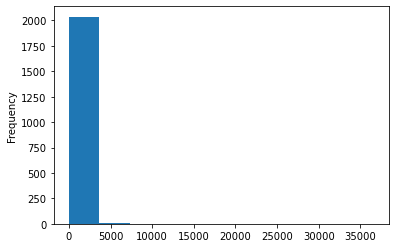

In [159]:
safety_stocks_df['mean_demand'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

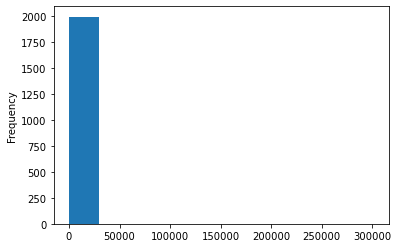

In [160]:
safety_stocks_df['std_dev_demand'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

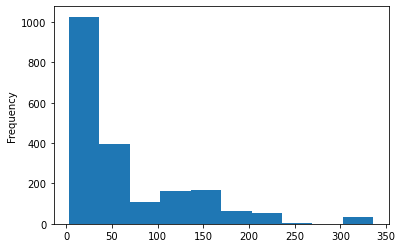

In [161]:
safety_stocks_df['mean_lead_time'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

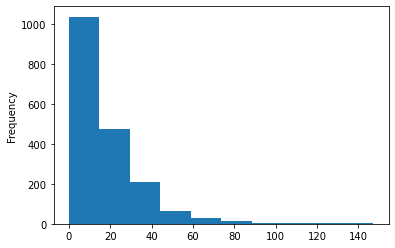

In [162]:
safety_stocks_df['std_dev_lead_time'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

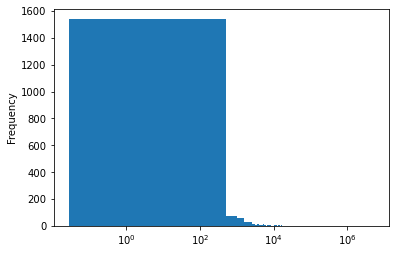

In [163]:
safety_stocks_df['safety_stock'].plot.hist(logx = True, bins = 10000)

# Compare to ASML levels - Thijs' data

In [164]:
filepath = r"Data\Misc_data\ASML_safety_stocks.csv"
df_asml = pd.read_csv(filepath)
df_asml.head()

,ASML#\n\n\n,ASML beschrijving,ERIKS#,ERIKS omschrijving,1 May 2021,Jun-21,Jul-21,Aug-21,Sep-21,1 Oct 2021,Nov-21,Dec-21,Jan-22,Feb-22,1 Mar 2022,Apr-22,Week 21,Week 20,Week 19,Week 18,Week 17,Week 16,Week 15,Week 14,Week 13,Week 12,Week 11,Goederengroep,Formulespec. status,Positietypegroep,Eenheid,Leverende vestiging,Planningsstrategiegroep,Plannings\nprofiel,VestSpecif ArtStatus,Veiligheids\nvoorraad,Artikelnotitie,Count 2021,Count 2020
0,4022.439.75601,CLAMP HOSE SST 11-17,10016351,Slangklem ABA-Z SS316 11 x 17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,179.0,249,249.0,249.0,253.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01 (ERIKS BV Alkmaar),40 (Planning met eindmontage),VPFZ,NaN,1000,NaN,0,0
1,4022.439.75621,CLAMP HOSE SST 19-28,10016212,Slangklem ABA-R SS304 19 x 28,0.0,0.0,0.0,0.0,0.0,0.0,67.0,143.0,116.0,127.0,186.0,157.0,796,576.0,760.0,934.0,747.0,637.0,657.0,535.0,597.0,617.0,580.0,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01 (ERIKS BV Alkmaar),40 (Planning met eindmontage),VPFZ,NaN,700,NaN,0,0
2,4022.439.75651,CLAMP HOSE SST 32-44,10016215,Slangklem ABA-R SS304 32 x 44,0.0,0.0,0.0,0.0,300.0,0.0,0.0,0.0,350.0,0.0,0.0,0.0,650,650.0,650.0,650.0,600.0,600.0,850.0,850.0,691.0,694.0,680.0,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01 (ERIKS BV Alkmaar),40 (Planning met eindmontage),VPFZ,NaN,300,NaN,0,0
3,4022.435.51251,HOSE PVC TP 18X12 MULTIBAR,11194091,Slang Premium Multibar FG rol=50m 12x3,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,50,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,06175030 (Multibar/TX slangen),Z1 (Standaard),NORM (Normale positie),m (Meter),EN01 (ERIKS BV Alkmaar),40 (Planning met eindmontage),VPFZ,NaN,250,NaN,0,0
4,4022.439.75681,CLAMP HOSE SST 58-75,10016233,Slangklem ABA-R SS304 58 x 75,0.0,85.0,0.0,0.0,590.0,0.0,630.0,0.0,650.0,0.0,675.0,0.0,2630,2455.0,2405.0,2950.0,2395.0,2430.0,3005.0,3050.0,2445.0,2275.0,2250.0,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01 (ERIKS BV Alkmaar),40 (Planning met eindmontage),VPFZ,NaN,250,15/1/221ID na overleg Alexander Smit vv verlaa...,0,2


## Create SKU-Plant identifier

In [165]:
df_asml['Leverende vestiging'] = df_asml['Leverende vestiging'].str[:4]
df_asml.head()

,ASML#\n\n\n,ASML beschrijving,ERIKS#,ERIKS omschrijving,1 May 2021,Jun-21,Jul-21,Aug-21,Sep-21,1 Oct 2021,Nov-21,Dec-21,Jan-22,Feb-22,1 Mar 2022,Apr-22,Week 21,Week 20,Week 19,Week 18,Week 17,Week 16,Week 15,Week 14,Week 13,Week 12,Week 11,Goederengroep,Formulespec. status,Positietypegroep,Eenheid,Leverende vestiging,Planningsstrategiegroep,Plannings\nprofiel,VestSpecif ArtStatus,Veiligheids\nvoorraad,Artikelnotitie,Count 2021,Count 2020
0,4022.439.75601,CLAMP HOSE SST 11-17,10016351,Slangklem ABA-Z SS316 11 x 17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,179.0,249,249.0,249.0,253.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01,40 (Planning met eindmontage),VPFZ,NaN,1000,NaN,0,0
1,4022.439.75621,CLAMP HOSE SST 19-28,10016212,Slangklem ABA-R SS304 19 x 28,0.0,0.0,0.0,0.0,0.0,0.0,67.0,143.0,116.0,127.0,186.0,157.0,796,576.0,760.0,934.0,747.0,637.0,657.0,535.0,597.0,617.0,580.0,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01,40 (Planning met eindmontage),VPFZ,NaN,700,NaN,0,0
2,4022.439.75651,CLAMP HOSE SST 32-44,10016215,Slangklem ABA-R SS304 32 x 44,0.0,0.0,0.0,0.0,300.0,0.0,0.0,0.0,350.0,0.0,0.0,0.0,650,650.0,650.0,650.0,600.0,600.0,850.0,850.0,691.0,694.0,680.0,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01,40 (Planning met eindmontage),VPFZ,NaN,300,NaN,0,0
3,4022.435.51251,HOSE PVC TP 18X12 MULTIBAR,11194091,Slang Premium Multibar FG rol=50m 12x3,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,50,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,06175030 (Multibar/TX slangen),Z1 (Standaard),NORM (Normale positie),m (Meter),EN01,40 (Planning met eindmontage),VPFZ,NaN,250,NaN,0,0
4,4022.439.75681,CLAMP HOSE SST 58-75,10016233,Slangklem ABA-R SS304 58 x 75,0.0,85.0,0.0,0.0,590.0,0.0,630.0,0.0,650.0,0.0,675.0,0.0,2630,2455.0,2405.0,2950.0,2395.0,2430.0,3005.0,3050.0,2445.0,2275.0,2250.0,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01,40 (Planning met eindmontage),VPFZ,NaN,250,15/1/221ID na overleg Alexander Smit vv verlaa...,0,2


In [166]:
df_asml['ERIKS#'] = df_asml['ERIKS#'].astype(str)
df_asml['Plant-Material'] = df_asml['Leverende vestiging'] + df_asml['ERIKS#']
df_asml.head()

,ASML#\n\n\n,ASML beschrijving,ERIKS#,ERIKS omschrijving,1 May 2021,Jun-21,Jul-21,Aug-21,Sep-21,1 Oct 2021,Nov-21,Dec-21,Jan-22,Feb-22,1 Mar 2022,Apr-22,Week 21,Week 20,Week 19,Week 18,Week 17,Week 16,Week 15,Week 14,Week 13,Week 12,Week 11,Goederengroep,Formulespec. status,Positietypegroep,Eenheid,Leverende vestiging,Planningsstrategiegroep,Plannings\nprofiel,VestSpecif ArtStatus,Veiligheids\nvoorraad,Artikelnotitie,Count 2021,Count 2020,Plant-Material
0,4022.439.75601,CLAMP HOSE SST 11-17,10016351,Slangklem ABA-Z SS316 11 x 17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.0,179.0,249,249.0,249.0,253.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01,40 (Planning met eindmontage),VPFZ,NaN,1000,NaN,0,0,EN0110016351
1,4022.439.75621,CLAMP HOSE SST 19-28,10016212,Slangklem ABA-R SS304 19 x 28,0.0,0.0,0.0,0.0,0.0,0.0,67.0,143.0,116.0,127.0,186.0,157.0,796,576.0,760.0,934.0,747.0,637.0,657.0,535.0,597.0,617.0,580.0,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01,40 (Planning met eindmontage),VPFZ,NaN,700,NaN,0,0,EN0110016212
2,4022.439.75651,CLAMP HOSE SST 32-44,10016215,Slangklem ABA-R SS304 32 x 44,0.0,0.0,0.0,0.0,300.0,0.0,0.0,0.0,350.0,0.0,0.0,0.0,650,650.0,650.0,650.0,600.0,600.0,850.0,850.0,691.0,694.0,680.0,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01,40 (Planning met eindmontage),VPFZ,NaN,300,NaN,0,0,EN0110016215
3,4022.435.51251,HOSE PVC TP 18X12 MULTIBAR,11194091,Slang Premium Multibar FG rol=50m 12x3,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,50,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,06175030 (Multibar/TX slangen),Z1 (Standaard),NORM (Normale positie),m (Meter),EN01,40 (Planning met eindmontage),VPFZ,NaN,250,NaN,0,0,EN0111194091
4,4022.439.75681,CLAMP HOSE SST 58-75,10016233,Slangklem ABA-R SS304 58 x 75,0.0,85.0,0.0,0.0,590.0,0.0,630.0,0.0,650.0,0.0,675.0,0.0,2630,2455.0,2405.0,2950.0,2395.0,2430.0,3005.0,3050.0,2445.0,2275.0,2250.0,06450010 (ABA wormschroefklem),Z1 (Standaard),NORM (Normale positie),ST (Stuks),EN01,40 (Planning met eindmontage),VPFZ,NaN,250,15/1/221ID na overleg Alexander Smit vv verlaa...,0,2,EN0110016233


In [167]:
safety_stocks_df.describe()

,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
count,2041.000000,2000.000000,2024.000000,1840.000000,2.024000e+03,2041.000000,2041.000000
mean,92.325821,657.379636,65.660573,17.611925,1.000508e+04,1.518161,67.920195
std,5.192393,7394.516022,66.112615,16.749773,1.256063e+05,0.359039,861.937563
min,80.000000,0.000000,3.000000,0.000000,2.762431e-02,0.841621,0.000789
25%,90.000000,2.911719,21.000000,6.235983,2.793291e+00,1.281552,0.103085
50%,95.000000,9.976483,35.000000,12.591935,1.856401e+01,1.644854,0.596168
75%,95.000000,106.160457,94.500000,23.948378,4.658597e+02,1.644854,6.140012
max,98.000000,300844.304206,336.000000,147.244921,5.117705e+06,2.053749,36555.032775


## Join ASML safety stock data to our safety stocks df

In [168]:
safety_stocks_df_with_asml = pd.merge(safety_stocks_df, 
         df_asml[['Plant-Material', 'Veiligheids\nvoorraad']],
         left_index = True,
         right_on='Plant-Material',
        how = 'left').set_index('Plant-Material')

In [169]:
safety_stocks_df_with_asml.head(50)

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand,Veiligheids\nvoorraad
Plant-Material,,,,,,,,,
EN0113396509,A,98.0,217.021950,189.0,38.280411,10827.017659,2.053749,57.285808,NaN
EN0112553392,B,95.0,7.505332,35.0,8.124398,18.152985,1.644854,0.518657,NaN
EN0111857009,C,90.0,26.073460,126.0,29.692745,262.654412,1.281552,2.084559,NaN
EN0112100341,D,80.0,0.000000,154.0,13.279056,23.105776,0.841621,0.150038,NaN
EN0112403883,C,90.0,19.160325,16.0,2.984810,7.390135,1.281552,0.461883,NaN
EN0112216937,B,95.0,536.704319,154.0,40.368442,1966.469347,1.644854,12.769281,NaN
EN0113030634,B,95.0,7.839461,21.0,3.696846,1.757178,1.644854,0.083675,NaN
EN0112141998,B,95.0,9.219601,28.0,6.375735,21.272311,1.644854,0.759725,NaN
EN0111456939,A,98.0,27.389723,18.0,7.141137,27.448088,2.053749,1.524894,NaN


In [170]:
print (len(safety_stocks_df_with_asml))

2041


In [171]:
list_skus_ea = safety_stocks_df_with_asml.index.tolist()

In [172]:
list_skus_asml = df_asml['Plant-Material'].tolist()

In [173]:
print (len(list(set(list_skus_ea) & set(list_skus_asml))))

133


To do:
1. Add other safety stock levels via MARC-EISBE
2. Clean up for presentation
3. Create slides highlighting key filters/steps 

# Extensions:

## Join MARC-EISBE (safety stock levels in SAP) to all VPV/VPF SKUs

In [174]:
safety_stocks_df.describe()

,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand
count,2041.000000,2000.000000,2024.000000,1840.000000,2.024000e+03,2041.000000,2041.000000
mean,92.325821,657.379636,65.660573,17.611925,1.000508e+04,1.518161,67.920195
std,5.192393,7394.516022,66.112615,16.749773,1.256063e+05,0.359039,861.937563
min,80.000000,0.000000,3.000000,0.000000,2.762431e-02,0.841621,0.000789
25%,90.000000,2.911719,21.000000,6.235983,2.793291e+00,1.281552,0.103085
50%,95.000000,9.976483,35.000000,12.591935,1.856401e+01,1.644854,0.596168
75%,95.000000,106.160457,94.500000,23.948378,4.658597e+02,1.644854,6.140012
max,98.000000,300844.304206,336.000000,147.244921,5.117705e+06,2.053749,36555.032775


In [175]:
safety_stocks_df_with_SAP_ss = pd.merge(safety_stocks_df, 
         df_ptg[['Plant-Material', 'Material Plant Safety Stock']],
         left_index = True,
         right_on='Plant-Material').set_index('Plant-Material')

In [176]:
safety_stocks_df_with_SAP_ss.head(50)

,ABC_class,DSL,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Z_score,mean_demand,Material Plant Safety Stock
Plant-Material,,,,,,,,,
EN0113396509,A,98.0,217.021950,189.0,38.280411,10827.017659,2.053749,57.285808,2400
EN0112553392,B,95.0,7.505332,35.0,8.124398,18.152985,1.644854,0.518657,0
EN0111857009,C,90.0,26.073460,126.0,29.692745,262.654412,1.281552,2.084559,300
EN0112100341,D,80.0,0.000000,154.0,13.279056,23.105776,0.841621,0.150038,0
EN0112403883,C,90.0,19.160325,16.0,2.984810,7.390135,1.281552,0.461883,0
EN0112216937,B,95.0,536.704319,154.0,40.368442,1966.469347,1.644854,12.769281,2500
EN0113030634,B,95.0,7.839461,21.0,3.696846,1.757178,1.644854,0.083675,0
EN0112141998,B,95.0,9.219601,28.0,6.375735,21.272311,1.644854,0.759725,0
EN0111456939,A,98.0,27.389723,18.0,7.141137,27.448088,2.053749,1.524894,0


In [177]:
cols = list(safety_stocks_df_with_SAP_ss.columns.values)
print (cols)

['ABC_class', 'DSL', 'std_dev_demand', 'mean_lead_time', 'std_dev_lead_time', 'safety_stock', 'Z_score', 'mean_demand', 'Material Plant Safety Stock']


In [178]:
safety_stocks_df_with_SAP_ss_trimmed = safety_stocks_df_with_SAP_ss[['ABC_class',
                             'DSL',
                             'Z_score',
                             'mean_demand',
                             'std_dev_demand',
                             'mean_lead_time',
                             'std_dev_lead_time',                       
                             'safety_stock',
                             'Material Plant Safety Stock']]
safety_stocks_df_with_SAP_ss_trimmed.head()

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock
Plant-Material,,,,,,,,,
EN0113396509,A,98.0,2.053749,57.285808,217.021950,189.0,38.280411,10827.017659,2400
EN0112553392,B,95.0,1.644854,0.518657,7.505332,35.0,8.124398,18.152985,0
EN0111857009,C,90.0,1.281552,2.084559,26.073460,126.0,29.692745,262.654412,300
EN0112100341,D,80.0,0.841621,0.150038,0.000000,154.0,13.279056,23.105776,0
EN0112403883,C,90.0,1.281552,0.461883,19.160325,16.0,2.984810,7.390135,0


In [179]:
pd.options.display.float_format = '{:.2f}'.format
safety_stocks_df_with_SAP_ss_trimmed.head(50)

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock
Plant-Material,,,,,,,,,
EN0113396509,A,98.00,2.05,57.29,217.02,189.00,38.28,10827.02,2400
EN0112553392,B,95.00,1.64,0.52,7.51,35.00,8.12,18.15,0
EN0111857009,C,90.00,1.28,2.08,26.07,126.00,29.69,262.65,300
EN0112100341,D,80.00,0.84,0.15,0.00,154.00,13.28,23.11,0
EN0112403883,C,90.00,1.28,0.46,19.16,16.00,2.98,7.39,0
EN0112216937,B,95.00,1.64,12.77,536.70,154.00,40.37,1966.47,2500
EN0113030634,B,95.00,1.64,0.08,7.84,21.00,3.70,1.76,0
EN0112141998,B,95.00,1.64,0.76,9.22,28.00,6.38,21.27,0
EN0111456939,A,98.00,2.05,1.52,27.39,18.00,7.14,27.45,0


In [180]:
safety_stocks_df_with_SAP_ss_trimmed.describe()

,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock
count,2038.00,2038.00,2038.00,1997.00,2021.00,1837.00,2021.00,2038.00
mean,92.33,1.52,68.02,658.36,65.73,17.60,10019.92,4627.15
std,5.19,0.36,862.57,7400.03,66.14,16.75,125698.91,44998.49
min,80.00,0.84,0.00,0.00,3.00,0.00,0.03,0.00
25%,90.00,1.28,0.10,2.94,21.00,6.23,2.79,0.00
50%,95.00,1.64,0.60,9.99,35.00,12.57,18.60,10.00
75%,95.00,1.64,6.16,106.85,96.00,23.92,467.79,250.00
max,98.00,2.05,36555.03,300844.30,336.00,147.24,5117704.59,1600000.00


# To do:
1. Double check inclusion of forecast lines done properly. All joins working as desired (left joins)?
2. Calculate expected increases in stock values. 
3. Sanity check largest expected stock value increases.
4. Produce .csv with increased stock values for Hans. 
5. Produce TXRunner .csv for Hans. 
6. Find all SAP fields used, write email to Anil (and Thijs)
7. Automate EA extracts/place project on DataBricks.
8. Email Nienke with initial results. 

# Results of forecast lines double check

All the joins look to be working as desired, but a more conceptual problem has come up. 
Should we be including forecast lines in the mean and standard deviation calculations for demand? 
For standard deviation, it's perhaps more obvious. Past order behaviour is likely to vary much more than future order behaviour (double check this with Hans). So past standard deviation is likely to be higher than future. 

But what about mean demand? Well, if we include it, then we assume that customers order in approximately the same volume in their forecast lines, as they actually have in the past. If there's a difference, then we probably shouldn't include forecast lines. We want the mean demand behaviour ACTUALLY OBSERVED in the past, rather than the mean demand behaviour, weighted by what customers say they're going to order in the future. Double check this in meeting on 17/08/21.

# Calculate expected increase in stock values

## Import price data

In [181]:
filepath = r"Data\EA_Data\Price_Data_18_Aug_2021.csv"
df_prices = pd.read_csv(filepath, sep=';')
df_prices.head()

,(Self) Object Type EA,Material Material,Material Description,Plant Plant,(Self) DF at plant level,(Self) Plant-sp.matl status,Material X-plant matl status,(Self) MRP Type,(Self) MRP Controller,(Self) Purchasing Group,(Self) Procurement Type Planning,(Self) Special procurement,(Self) Financial Value Stocks,(Self) StQ Total,Material Base Unit of Measure,Purchase Org. Purchase Org.,Stand. Info Rec. Net Price,(Self) Moving price,(Self) EA_PROPERTY_PlanProfiel,Material Material Group,(Self) Price Control,(Self) Price Unit,(Self) Total Value,(Self) Standard price
0,Material Plant,10014281,Hose cutter,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND5 (J. Priester),F (External procurement),EN01\,65.06,37.00,Piece,EN01 (ERIKS BV),1.69,1.76,VPVZ,06525010 (Other accessories),V (Moving average price/periodic unit price),1,65.06,0.00
1,Material Plant,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,1002.55,69.06,m,EN01 (ERIKS BV),13.39,14.52,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,1002.55,0.00
2,Material Plant,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,45.48,2.90,m,EN01 (ERIKS BV),14.43,15.66,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,45.48,15.19
3,Material Plant,10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,602.35,34.78,m,EN01 (ERIKS BV),15.79,17.32,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,602.35,0.00
4,Material Plant,10014735,Hose Flexair EF-1 PVC coil=6m 90,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,222.15,72.00,m,EN01 (ERIKS BV),0.28,3.09,VPFZ,06150130 (Flexair hoses),V (Moving average price/periodic unit price),1,222.15,0.00


## Check lengths and unique SKUs

In [182]:
df_prices['Plant Plant'] = df_prices['Plant Plant'].str[:4]
df_prices['Material Material'] = df_prices['Material Material'].astype(str)
df_prices['Plant-Material'] = df_prices['Plant Plant'] + df_prices['Material Material']


In [183]:
df_prices.head()

,(Self) Object Type EA,Material Material,Material Description,Plant Plant,(Self) DF at plant level,(Self) Plant-sp.matl status,Material X-plant matl status,(Self) MRP Type,(Self) MRP Controller,(Self) Purchasing Group,(Self) Procurement Type Planning,(Self) Special procurement,(Self) Financial Value Stocks,(Self) StQ Total,Material Base Unit of Measure,Purchase Org. Purchase Org.,Stand. Info Rec. Net Price,(Self) Moving price,(Self) EA_PROPERTY_PlanProfiel,Material Material Group,(Self) Price Control,(Self) Price Unit,(Self) Total Value,(Self) Standard price,Plant-Material
0,Material Plant,10014281,Hose cutter,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND5 (J. Priester),F (External procurement),EN01\,65.06,37.00,Piece,EN01 (ERIKS BV),1.69,1.76,VPVZ,06525010 (Other accessories),V (Moving average price/periodic unit price),1,65.06,0.00,EN0110014281
1,Material Plant,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,1002.55,69.06,m,EN01 (ERIKS BV),13.39,14.52,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,1002.55,0.00,EN0110014530
2,Material Plant,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,45.48,2.90,m,EN01 (ERIKS BV),14.43,15.66,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,45.48,15.19,EN0110014531
3,Material Plant,10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,602.35,34.78,m,EN01 (ERIKS BV),15.79,17.32,VPVZ,06225010 (Hoses type 160M/161M),V (Moving average price/periodic unit price),1,602.35,0.00,EN0110014532
4,Material Plant,10014735,Hose Flexair EF-1 PVC coil=6m 90,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,222.15,72.00,m,EN01 (ERIKS BV),0.28,3.09,VPFZ,06150130 (Flexair hoses),V (Moving average price/periodic unit price),1,222.15,0.00,EN0110014735


In [184]:
# Count number of rows in data
print (len(df_prices))

# Count number of unique plant SKU combos
df_prices['Plant-Material'].nunique()



3257


3257

## Check for multiple Price Control entries for any SKU

There's some complicated logic that we should discuss now. We seek the price per unit of a product. It turns out, any product can have two different prices per unit. The first is when the Price Control column is set to V. This means the product is ordered in. The second is when this column is set to S. These products are made in-house. Thus, V products are typically 5-10% inflated by transport costs etc. We need to use the V price when Price Control = V, and the S price when Price Control = S. 

But we also need to divide the selected price, by the Price Unit column. This tells us how many units the V price or S price accounts for. By dividing by Price Unit, we get our desired Price Per Unit.

In [185]:
# Check for multiple entries in Price Control column for any SKU

test = df_prices.groupby('Plant-Material')['(Self) Price Control'].nunique() > 1
print (test.value_counts())
print (test[test])

False    3257
Name: (Self) Price Control, dtype: int64
Series([], Name: (Self) Price Control, dtype: bool)


## Strip Price Control Column 

In [186]:
df_prices['(Self) Price Control'] = df_prices['(Self) Price Control'].str[:1]
df_prices['(Self) Price Control'].value_counts()


V    2303
S     954
Name: (Self) Price Control, dtype: int64

## Get V or S Price in one column

In [187]:
def get_price(row):
    if row['(Self) Price Control'] == 'V':
        return row['(Self) Moving price']
    if row['(Self) Price Control'] == 'S':
        return row['(Self) Standard price']

    return None

df_prices['V_or_S_Price'] = df_prices.apply(lambda row: get_price(row), axis = 1)
df_prices['V_or_S_Price_per_unit'] = df_prices['V_or_S_Price'] / (df_prices['(Self) Price Unit'] * 1.0)

In [188]:
df_prices.head(50)

,(Self) Object Type EA,Material Material,Material Description,Plant Plant,(Self) DF at plant level,(Self) Plant-sp.matl status,Material X-plant matl status,(Self) MRP Type,(Self) MRP Controller,(Self) Purchasing Group,(Self) Procurement Type Planning,(Self) Special procurement,(Self) Financial Value Stocks,(Self) StQ Total,Material Base Unit of Measure,Purchase Org. Purchase Org.,Stand. Info Rec. Net Price,(Self) Moving price,(Self) EA_PROPERTY_PlanProfiel,Material Material Group,(Self) Price Control,(Self) Price Unit,(Self) Total Value,(Self) Standard price,Plant-Material,V_or_S_Price,V_or_S_Price_per_unit
0,Material Plant,10014281,Hose cutter,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND5 (J. Priester),F (External procurement),EN01\,65.06,37.00,Piece,EN01 (ERIKS BV),1.69,1.76,VPVZ,06525010 (Other accessories),V,1,65.06,0.00,EN0110014281,1.76,1.76
1,Material Plant,10014530,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,1002.55,69.06,m,EN01 (ERIKS BV),13.39,14.52,VPVZ,06225010 (Hoses type 160M/161M),V,1,1002.55,0.00,EN0110014530,14.52,14.52
2,Material Plant,10014531,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,45.48,2.90,m,EN01 (ERIKS BV),14.43,15.66,VPVZ,06225010 (Hoses type 160M/161M),V,1,45.48,15.19,EN0110014531,15.66,15.66
3,Material Plant,10014532,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,602.35,34.78,m,EN01 (ERIKS BV),15.79,17.32,VPVZ,06225010 (Hoses type 160M/161M),V,1,602.35,0.00,EN0110014532,17.32,17.32
4,Material Plant,10014735,Hose Flexair EF-1 PVC coil=6m 90,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,222.15,72.00,m,EN01 (ERIKS BV),0.28,3.09,VPFZ,06150130 (Flexair hoses),V,1,222.15,0.00,EN0110014735,3.09,3.09
5,Material Plant,10014736,Hose Flexair EF-1 PVC coil=6m 102,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,203.75,60.00,m,EN01 (ERIKS BV),0.21,3.40,VPFZ,06150130 (Flexair hoses),V,1,203.75,0.00,EN0110014736,3.40,3.40
6,Material Plant,10014792,"Hose Erivide coil=50m 13x3,2",EN01,False,04 (Stk.mat. will be deleted),NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,0.00,0.00,m,EN01 (ERIKS BV),3.36,3.49,VPFZ,06150060 (Erivide hoses),V,1,0.00,0.00,EN0110014792,3.49,3.49
7,Material Plant,10014876,Hose Polypur blue coil=100m OD6x1,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND5 (J. Priester),F (External procurement),EN01\,57.07,223.80,m,EN01 (ERIKS BV),23.30,0.26,VPVZ,06175520 (Polypur hoses),V,1,57.07,0.00,EN0110014876,0.26,0.26
8,Material Plant,10014877,Hose Polypur blue coil=100m OD8x1,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND5 (J. Priester),F (External procurement),EN01\,47.00,132.50,m,EN01 (ERIKS BV),0.05,0.35,VPVZ,06175520 (Polypur hoses),V,1,47.00,0.00,EN0110014877,0.35,0.35
9,Material Plant,10015458,Hose Abratape 06 Food 15m 50x4,EN01,False,NaN,NaN,PD (MRP),EN01\001 (R. BAKKER),ND7 (J. van Wijngaarden),F (External procurement),EN01\,1091.90,180.00,m,EN01 (ERIKS BV),5.72,6.07,VPFZ,06150010 (PU hoses),V,1,1091.90,0.00,EN0110015458,6.07,6.07


## Merge V_or_S_column to main results df

In [189]:
safety_stocks_df_with_SAP_ss_trimmed = pd.merge(safety_stocks_df_with_SAP_ss_trimmed, 
         df_prices[['Plant-Material', 
                    'V_or_S_Price_per_unit', 
                    'Material Description',
                    '(Self) MRP Controller',
                    'Material Material Group',
                    '(Self) EA_PROPERTY_PlanProfiel']],
         left_index = True,
         right_on='Plant-Material').set_index('Plant-Material')

In [190]:
safety_stocks_df_with_SAP_ss_trimmed.head(50)

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel
Plant-Material,,,,,,,,,,,,,,
EN0113396509,A,98.00,2.05,57.29,217.02,189.00,38.28,10827.02,2400,1.04,ATAG Ond.Afd iCon 2 C60540 EP559710,EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ
EN0112553392,B,95.00,1.64,0.52,7.51,35.00,8.12,18.15,0,9.71,ASM PLUG HEX F/F SST G1/8 439.80133 CLR,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ
EN0111857009,C,90.00,1.28,2.08,26.07,126.00,29.69,262.65,300,0.10,ASM SCR HXS CAP M5x10 .439.90943,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ
EN0112100341,D,80.00,0.84,0.15,0.00,154.00,13.28,23.11,0,1.29,AT Sealring 45*65*12mm acc 93-0017.0-001,EN01\002 (O. DE HOOG),10530220 (Mldpart EPDM),VPFZ
EN0112403883,C,90.00,1.28,0.46,19.16,16.00,2.98,7.39,0,2.02,ASM WASHER 4022.647.00471,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ
EN0112216937,B,95.00,1.64,12.77,536.70,154.00,40.37,1966.47,2500,0.57,"REM 100203.0-5 Seal lip 250, EPDM 3665",EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ
EN0113030634,B,95.00,1.64,0.08,7.84,21.00,3.70,1.76,0,19.35,ASM STANDARD CLEAN BOX SIZE D 474.20642,EN01\001 (R. BAKKER),10530110 (Mldpart misc.),VPVZ
EN0112141998,B,95.00,1.64,0.76,9.22,28.00,6.38,21.27,0,15.29,"ASM PLUG POM 2"" NPT RED 4022.642.56881",EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ
EN0111456939,A,98.00,2.05,1.52,27.39,18.00,7.14,27.45,0,8.87,ASM Hose PFA TP 6x4 4022.439.60105 CLR,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ


In [191]:
safety_stocks_df_with_SAP_ss_trimmed['SAP_SS_Value'] = safety_stocks_df_with_SAP_ss_trimmed['Material Plant Safety Stock'] * safety_stocks_df_with_SAP_ss_trimmed['V_or_S_Price_per_unit']
safety_stocks_df_with_SAP_ss_trimmed['Proposed_SS_Value'] = safety_stocks_df_with_SAP_ss_trimmed['safety_stock'] * safety_stocks_df_with_SAP_ss_trimmed['V_or_S_Price_per_unit']
safety_stocks_df_with_SAP_ss_trimmed['Difference_in_SS_Value'] = safety_stocks_df_with_SAP_ss_trimmed['Proposed_SS_Value'] - safety_stocks_df_with_SAP_ss_trimmed['SAP_SS_Value'] 
safety_stocks_df_with_SAP_ss_trimmed.head(50)

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value
Plant-Material,,,,,,,,,,,,,,,,,
EN0113396509,A,98.00,2.05,57.29,217.02,189.00,38.28,10827.02,2400,1.04,ATAG Ond.Afd iCon 2 C60540 EP559710,EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ,2489.28,11229.78,8740.50
EN0112553392,B,95.00,1.64,0.52,7.51,35.00,8.12,18.15,0,9.71,ASM PLUG HEX F/F SST G1/8 439.80133 CLR,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ,0.00,176.27,176.27
EN0111857009,C,90.00,1.28,2.08,26.07,126.00,29.69,262.65,300,0.10,ASM SCR HXS CAP M5x10 .439.90943,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ,30.00,26.27,-3.73
EN0112100341,D,80.00,0.84,0.15,0.00,154.00,13.28,23.11,0,1.29,AT Sealring 45*65*12mm acc 93-0017.0-001,EN01\002 (O. DE HOOG),10530220 (Mldpart EPDM),VPFZ,0.00,29.81,29.81
EN0112403883,C,90.00,1.28,0.46,19.16,16.00,2.98,7.39,0,2.02,ASM WASHER 4022.647.00471,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ,0.00,14.93,14.93
EN0112216937,B,95.00,1.64,12.77,536.70,154.00,40.37,1966.47,2500,0.57,"REM 100203.0-5 Seal lip 250, EPDM 3665",EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ,1429.25,1124.23,-305.02
EN0113030634,B,95.00,1.64,0.08,7.84,21.00,3.70,1.76,0,19.35,ASM STANDARD CLEAN BOX SIZE D 474.20642,EN01\001 (R. BAKKER),10530110 (Mldpart misc.),VPVZ,0.00,34.00,34.00
EN0112141998,B,95.00,1.64,0.76,9.22,28.00,6.38,21.27,0,15.29,"ASM PLUG POM 2"" NPT RED 4022.642.56881",EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ,0.00,325.25,325.25
EN0111456939,A,98.00,2.05,1.52,27.39,18.00,7.14,27.45,0,8.87,ASM Hose PFA TP 6x4 4022.439.60105 CLR,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ,0.00,243.46,243.46


In [192]:
print (safety_stocks_df_with_SAP_ss_trimmed['Difference_in_SS_Value'].sum())

1315530.0924108732


In [193]:
safety_stocks_df_with_SAP_ss_trimmed.nlargest(10, 'Difference_in_SS_Value')


,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value
Plant-Material,,,,,,,,,,,,,,,,,
EN0112508180,A,98.00,2.05,6853.99,8039.53,154.00,36.81,1055514.71,600000,0.26,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ,156360.00,275067.13,118707.13
EN0112094423,A,98.00,2.05,921.86,2652.16,105.00,33.91,96795.37,35000,0.70,AT 040042.0-4 JOINT PORTE 212 714729,EN01\002 (O. DE HOOG),10530300 (Mldpart SI),VPFZ,24657.50,68192.34,43534.84
EN0111332256,A,98.00,2.05,1374.67,9708.46,336.00,41.51,461887.46,120000,0.12,M&G 1-lip DN100 EP 559268 20161057 grijs,EN01\002 (O. DE HOOG),10530220 (Mldpart EPDM),VPFZ,14904.00,57366.42,42462.42
EN0112659704,A,98.00,2.05,437.56,2543.23,203.00,58.52,88824.88,22000,0.62,M&G 1-lips DN80 514261 02 0910/4 br,EN01\002 (O. DE HOOG),10530250 (Mldpart FPM TÜV),VPFZ,13534.40,54645.07,41110.67
EN0113517182,A,98.00,2.05,0.19,2.74,140.00,22.62,27.17,3,1537.47,"ASM VLV PRES RLF 0,43MPA 1""NPT 489.75904",EN01\001 (R. BAKKER),02320030 (Press safety ASME),VPVZ,4612.41,41767.94,37155.53
EN0112718971,A,98.00,2.05,194.13,407.70,161.00,28.65,31254.63,0,1.14,REM Sealing Plate B 40kW 6528 128177-08,EN01\002 (O. DE HOOG),10530310 (Mldpart SI TÜV),VPFZ,0.00,35680.28,35680.28
EN0112092292,A,98.00,2.05,656.04,3230.38,112.00,38.33,73476.31,20000,0.58,"VAI O-Ring 202,57 X 6,99 EZ70/PC 3689",EN01\002 (O. DE HOOG),10220110 (O-ring EPDM 70 PC),VPFZ,11546.00,42417.88,30871.88
EN0112335326,A,98.00,2.05,2.53,8.76,140.00,75.48,354.33,80,108.78,ASM BALL VALVE HDL BW SST DN50 489.72796,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ,8702.40,38544.41,29842.01
EN0111334159,A,98.00,2.05,2462.64,19600.56,336.00,32.21,827448.63,264000,0.05,M&G stop Ø14mm 714245 030372/2 wit,EN01\002 (O. DE HOOG),10530300 (Mldpart SI),VPFZ,13780.80,43192.82,29412.02


In [194]:
#cols = safety_stocks_df_with_SAP_ss_trimmed.columns.tolist()
#print (cols)


In [195]:
#safety_stocks_df_with_SAP_ss_trimmed = safety_stocks_df_with_SAP_ss_trimmed[['ABC_class', 'DSL', 'Z_score', 'mean_demand', 'std_dev_demand', 'mean_lead_time', 'std_dev_lead_time', 'safety_stock', 'Material Plant Safety Stock', 'V_or_S_Price_per_unit', 'Material Description', '(Self) MRP Controller', 'Material Material Group', '(Self) EA_PROPERTY_PlanProfiel', 'SAP_SS_Value', 'Proposed_SS_Value', 'Difference_in_SS_Value']]

# Output TX Runner CSV

## Import data

In [196]:
filepath = r"Data\TX_Runner_Data\Example_TX_File.xlsx"
data_tx = pd.read_excel(filepath, sheet_name = 0, header = None)

#example_tx_runner_df = pd.read_excel(excel_file, sheetname=0)


## Create empty dataframe, with headers from xlsx file

In [197]:
headers_cleaned = data_tx.iloc[0].str.replace('\n',' ')
df_tx = pd.DataFrame(columns = headers_cleaned)
df_tx.head(50)

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL,Log Winshuttle Studio 11.2 SAP System: Client: SAP User - PA1:900:101844 Script Name - http://workflow-prod.eriksone.com/ShuttleFiles/MM02_MRP+forecast_profile+relevant_fields.Txr Mode - Standard (Batch) Start Row - 6 End Row - 0 Number of Errors - 0 Records Uploaded - 45 Date and Time - 19-7-2021 13:24:39 Execution Time - 00:00:43 Run Reason -


## Trim last column if 'Log'

In [198]:
if df_tx.columns.values[-1][0:3] == 'Log':
    headers_cleaned = headers_cleaned.iloc[0:-1]
    df_tx = df_tx.iloc[: , :-1]

df_tx.head(50)

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL


In [199]:
df_tx['Material Number RMMG1-MATNR'] = pd.Series(safety_stocks_df_with_SAP_ss_trimmed.index)

In [200]:
df_tx.head()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
0,EN0113396509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EN0112553392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,EN0111857009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EN0112100341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EN0112403883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [201]:
df_tx.describe()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
count,2038,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
unique,2033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
top,EN0111799243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add safety stocks

In [202]:
df_tx = pd.merge(df_tx, 
         safety_stocks_df_with_SAP_ss_trimmed[['safety_stock']],
         right_index = True,
         left_on = 'Material Number RMMG1-MATNR')
df_tx['Safety Stock MARC-EISBE'] = df_tx['safety_stock']
del df_tx['safety_stock']
df_tx.head()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
0,EN0113396509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10827.02,NaN,NaN,NaN,NaN,NaN
1,EN0112553392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.15,NaN,NaN,NaN,NaN,NaN
2,EN0111857009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.65,NaN,NaN,NaN,NaN,NaN
3,EN0112100341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.11,NaN,NaN,NaN,NaN,NaN
4,EN0112403883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.39,NaN,NaN,NaN,NaN,NaN


## Format Material and Plant columns

In [203]:
df_tx['Plant RMMG1-WERKS'] = df_tx['Material Number RMMG1-MATNR'].str[:4]
df_tx['Material Number RMMG1-MATNR'] = df_tx['Material Number RMMG1-MATNR'].str[3:]
df_tx.head()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
0,113396509,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10827.02,NaN,NaN,NaN,NaN,NaN
1,112553392,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.15,NaN,NaN,NaN,NaN,NaN
2,111857009,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.65,NaN,NaN,NaN,NaN,NaN
3,112100341,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.11,NaN,NaN,NaN,NaN,NaN
4,112403883,EN01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.39,NaN,NaN,NaN,NaN,NaN


## Replace all Nans with hashes (as done in TX Runner template)

In [204]:
df_tx = df_tx.replace(np.nan, '#', regex=True)
df_tx.head()

,Material Number RMMG1-MATNR,Plant RMMG1-WERKS,ABC Indicator MARC-MAABC,Plant-Specific Material Status MARC-MMSTA,MRP Controller (Materials Planner) MARC-DISPO,Reorder Point MARC-MINBE,Minimum Lot Size MARC-BSTMI,Maximum Lot Size MARC-BSTMA,Fixed lot size MARC-BSTFE,Maximum stock level MARC-MABST,Rounding value for purchase order quantity MARC-BSTRF,Safety Stock MARC-EISBE,Material: MRP profile RMMG1-DISPR,Forecast profile RMMG1-PROPR,Stock determination group MARC-EPRIO,Procurement Type MARC-BESKZ,Special procurement type MARC-SOBSL
0,113396509,EN01,#,#,#,#,#,#,#,#,#,10827.02,#,#,#,#,#
1,112553392,EN01,#,#,#,#,#,#,#,#,#,18.15,#,#,#,#,#
2,111857009,EN01,#,#,#,#,#,#,#,#,#,262.65,#,#,#,#,#
3,112100341,EN01,#,#,#,#,#,#,#,#,#,23.11,#,#,#,#,#
4,112403883,EN01,#,#,#,#,#,#,#,#,#,7.39,#,#,#,#,#


## Convert dataframe to xlsx file

In [205]:
output_filename = 'Data/TX_Runner_Data/output/New_Safety_Stocks_'
timestr = time.strftime("%Y%m%d-%H%M%S")
extension = '.xlsx'
df_tx.to_excel(output_filename + timestr + extension, index = False)  


# Include further diagnostics in stock value change file

## Number of demand data points per SKU

In [206]:
df_number_of_datapoints = df_demand_movement_type_filtered_lt_SKUs_filtered.groupby(['Plant-Material']).size().to_frame('n_demand_datapoints')
df_number_of_datapoints.head()

,n_demand_datapoints
Plant-Material,
EN0110014281,64
EN0110014530,517
EN0110014531,332
EN0110014532,444
EN0110014735,24


## Number of forecast line data points per SKU

In [207]:
df_number_of_datapoints['n_forecast_datapoints'] = df_forecast_lines.groupby(['Plant-Material']).size()
df_number_of_datapoints['n_forecast_datapoints'] = df_number_of_datapoints['n_forecast_datapoints'].fillna(0)
df_number_of_datapoints.head()

,n_demand_datapoints,n_forecast_datapoints
Plant-Material,,
EN0110014281,64,0.00
EN0110014530,517,0.00
EN0110014531,332,0.00
EN0110014532,444,0.00
EN0110014735,24,0.00


## Number of lead-time data points per SKU

In [208]:
df_number_of_datapoints['n_lead_time_datapoints'] = df_lt_demand_SKUs_filtered.groupby(['Plant-Material']).size()
df_number_of_datapoints.head()

,n_demand_datapoints,n_forecast_datapoints,n_lead_time_datapoints
Plant-Material,,,
EN0110014281,64,0.00,13
EN0110014530,517,0.00,23
EN0110014531,332,0.00,9
EN0110014532,444,0.00,13
EN0110014735,24,0.00,4


## Join n_datapoints df to main safety_stocks df

In [209]:
safety_stocks_df_with_SAP_ss_trimmed = pd.merge(safety_stocks_df_with_SAP_ss_trimmed, 
         df_number_of_datapoints[[
                                  'n_forecast_datapoints',
                                  'n_lead_time_datapoints',
                                  'n_demand_datapoints']], 
         left_index = True,
         right_index = True)
safety_stocks_df_with_SAP_ss_trimmed.head()

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints
Plant-Material,,,,,,,,,,,,,,,,,,,,
EN0110014281,C,90.00,1.28,0.56,16.72,7.00,1.62,3.89,0,1.76,Hose cutter,EN01\001 (R. BAKKER),06525010 (Other accessories),VPVZ,0.00,6.85,6.85,0.00,13,64
EN0110014530,A,98.00,2.05,3.14,19.07,41.00,19.98,128.87,60,14.52,Hose ERI-MET 161 M Coil=50m DN12-1/2'®,EN01\001 (R. BAKKER),06225010 (Hoses type 160M/161M),VPVZ,871.20,1871.14,999.94,0.00,23,517
EN0110014531,B,95.00,1.64,1.08,6.06,29.00,11.76,31.18,15,15.66,Hose ERI-MET 161 M Coil=150m DN20-3/4'®,EN01\001 (R. BAKKER),06225010 (Hoses type 160M/161M),VPVZ,234.90,488.22,253.32,0.00,9,332
EN0110014532,A,98.00,2.05,1.55,9.49,35.00,12.63,54.34,100,17.32,Hose ERI-MET 161 M Coil=150m DN25 - 1'®,EN01\001 (R. BAKKER),06225010 (Hoses type 160M/161M),VPVZ,1732.00,941.25,-790.75,0.00,13,444
EN0110014735,C,90.00,1.28,0.19,10.61,28.00,NaN,5.31,20,3.09,Hose Flexair EF-1 PVC coil=6m 90,EN01\001 (R. BAKKER),06150130 (Flexair hoses),VPFZ,61.80,16.40,-45.40,0.00,4,24


In [210]:
safety_stocks_df_with_SAP_ss_trimmed.describe()

,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints
count,2038.00,2038.00,2038.00,1997.00,2021.00,1837.00,2021.00,2038.00,2038.00,2038.00,2021.00,2021.00,2038.00,2038.00,2038.00
mean,92.33,1.52,68.02,658.36,65.73,17.60,10019.92,4627.15,31.46,791.54,1440.99,650.93,2.60,14.19,67.43
std,5.19,0.36,862.57,7400.03,66.14,16.75,125698.91,44998.49,118.98,4314.85,7760.10,4129.74,6.81,18.90,105.82
min,80.00,0.84,0.00,0.00,3.00,0.00,0.03,0.00,0.00,0.00,0.00,-10615.97,0.00,1.00,1.00
25%,90.00,1.28,0.10,2.94,21.00,6.23,2.79,0.00,0.33,0.00,19.83,-39.54,0.00,4.00,12.00
50%,95.00,1.64,0.60,9.99,35.00,12.57,18.60,10.00,3.38,74.65,115.09,11.02,0.00,9.00,31.00
75%,95.00,1.64,6.16,106.85,96.00,23.92,467.79,250.00,18.34,451.88,599.44,206.38,2.00,18.00,75.00
max,98.00,2.05,36555.03,300844.30,336.00,147.24,5117704.59,1600000.00,2014.88,156360.00,275067.13,118707.13,49.00,329.00,1344.00


# Remove anomalies caused by low data

In [211]:
safety_stocks_df_with_SAP_ss_trimmed['safety_stock'] = safety_stocks_df_with_SAP_ss_trimmed.apply(
    lambda x: x['Material Plant Safety Stock'] if 
    (x['n_lead_time_datapoints'] < 5 or x['n_demand_datapoints'] < 5)
     else x['safety_stock'], axis=1)

'''
safety_stocks_df_with_SAP_ss_trimmed_test['safety_stock'] = safety_stocks_df_with_SAP_ss_trimmed.apply(
    lambda x: x['Material Plant Safety Stock'] if x['n_lead_time_datapoints'] < 2 else x['safety_stock'], axis=1)

safety_stocks_df_with_SAP_ss_trimmed_test['safety_stock'] = safety_stocks_df_with_SAP_ss_trimmed.apply(
    lambda x: x['Material Plant Safety Stock'] if x['n_demand_datapoints'] < 2 else x['safety_stock'], axis=1)
'''
print (len(safety_stocks_df_with_SAP_ss_trimmed))
safety_stocks_df_with_SAP_ss_trimmed_test = safety_stocks_df_with_SAP_ss_trimmed[
    safety_stocks_df_with_SAP_ss_trimmed.index == 'EN0112487496'
]

safety_stocks_df_with_SAP_ss_trimmed_test.head()

2038


,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints
Plant-Material,,,,,,,,,,,,,,,,,,,,


# Output stock value change file

## Add % change in proposed safety stock

In [212]:
safety_stocks_df_with_SAP_ss_trimmed['Percentage_change_SS'] = (safety_stocks_df_with_SAP_ss_trimmed['safety_stock']/safety_stocks_df_with_SAP_ss_trimmed['Material Plant Safety Stock'])*100.0 - 100.0
safety_stocks_df_with_SAP_ss_trimmed['Percentage_change_SS'] = safety_stocks_df_with_SAP_ss_trimmed['Percentage_change_SS'].replace(np.inf, 0)
safety_stocks_df_with_SAP_ss_trimmed['Percentage_change_SS'] = safety_stocks_df_with_SAP_ss_trimmed['Percentage_change_SS'].replace(-100, 0)

In [213]:
safety_stocks_df_with_SAP_ss_trimmed_test = safety_stocks_df_with_SAP_ss_trimmed[
    safety_stocks_df_with_SAP_ss_trimmed['Percentage_change_SS'] == -np.inf]

safety_stocks_df_with_SAP_ss_trimmed_test.head()

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints,Percentage_change_SS
Plant-Material,,,,,,,,,,,,,,,,,,,,,


In [214]:
safety_stocks_df_with_SAP_ss_trimmed = safety_stocks_df_with_SAP_ss_trimmed.sort_values('Difference_in_SS_Value', ascending = False)
safety_stocks_df_with_SAP_ss_trimmed.head(50)

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints,Percentage_change_SS
Plant-Material,,,,,,,,,,,,,,,,,,,,,
EN0112508180,A,98.00,2.05,6853.99,8039.53,154.00,36.81,1055514.71,600000,0.26,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ,156360.00,275067.13,118707.13,12.00,190,711,75.92
EN0112094423,A,98.00,2.05,921.86,2652.16,105.00,33.91,96795.37,35000,0.70,AT 040042.0-4 JOINT PORTE 212 714729,EN01\002 (O. DE HOOG),10530300 (Mldpart SI),VPFZ,24657.50,68192.34,43534.84,19.00,209,524,176.56
EN0111332256,A,98.00,2.05,1374.67,9708.46,336.00,41.51,461887.46,120000,0.12,M&G 1-lip DN100 EP 559268 20161057 grijs,EN01\002 (O. DE HOOG),10530220 (Mldpart EPDM),VPFZ,14904.00,57366.42,42462.42,12.00,58,226,284.91
EN0112659704,A,98.00,2.05,437.56,2543.23,203.00,58.52,88824.88,22000,0.62,M&G 1-lips DN80 514261 02 0910/4 br,EN01\002 (O. DE HOOG),10530250 (Mldpart FPM TÜV),VPFZ,13534.40,54645.07,41110.67,12.00,69,156,303.75
EN0113517182,A,98.00,2.05,0.19,2.74,140.00,22.62,27.17,3,1537.47,"ASM VLV PRES RLF 0,43MPA 1""NPT 489.75904",EN01\001 (R. BAKKER),02320030 (Press safety ASME),VPVZ,4612.41,41767.94,37155.53,0.00,25,39,805.56
EN0112718971,A,98.00,2.05,194.13,407.70,161.00,28.65,31254.63,0,1.14,REM Sealing Plate B 40kW 6528 128177-08,EN01\002 (O. DE HOOG),10530310 (Mldpart SI TÜV),VPFZ,0.00,35680.28,35680.28,0.00,42,260,0.00
EN0112092292,A,98.00,2.05,656.04,3230.38,112.00,38.33,73476.31,20000,0.58,"VAI O-Ring 202,57 X 6,99 EZ70/PC 3689",EN01\002 (O. DE HOOG),10220110 (O-ring EPDM 70 PC),VPFZ,11546.00,42417.88,30871.88,11.00,145,182,267.38
EN0112335326,A,98.00,2.05,2.53,8.76,140.00,75.48,354.33,80,108.78,ASM BALL VALVE HDL BW SST DN50 489.72796,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ,8702.40,38544.41,29842.01,0.00,55,250,342.92
EN0111334159,A,98.00,2.05,2462.64,19600.56,336.00,32.21,827448.63,264000,0.05,M&G stop Ø14mm 714245 030372/2 wit,EN01\002 (O. DE HOOG),10530300 (Mldpart SI),VPFZ,13780.80,43192.82,29412.02,10.00,63,195,213.43


## Sanity Checks

<AxesSubplot:>

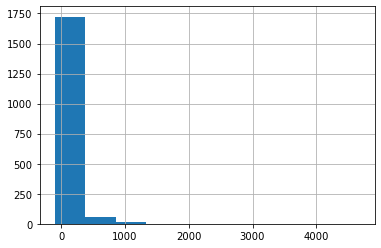

In [215]:
safety_stocks_df_with_SAP_ss_trimmed['Percentage_change_SS'].hist(bins = 10)

<AxesSubplot:>

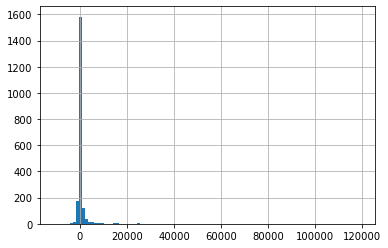

In [216]:
safety_stocks_df_with_SAP_ss_trimmed['Difference_in_SS_Value'].hist(bins = 100)

In [217]:
safety_stocks_df_with_SAP_ss_trimmed.describe()

,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints,Percentage_change_SS
count,2038.00,2038.00,2038.00,1997.00,2021.00,1837.00,2022.00,2038.00,2038.00,2038.00,2021.00,2021.00,2038.00,2038.00,2038.00,1795.00
mean,92.33,1.52,68.02,658.36,65.73,17.60,9992.48,4627.15,31.46,791.54,1440.99,650.93,2.60,14.19,67.43,47.23
std,5.19,0.36,862.57,7400.03,66.14,16.75,125671.29,44998.49,118.98,4314.85,7760.10,4129.74,6.81,18.90,105.82,218.38
min,80.00,0.84,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,-10615.97,0.00,1.00,1.00,-98.28
25%,90.00,1.28,0.10,2.94,21.00,6.23,2.46,0.00,0.33,0.00,19.83,-39.54,0.00,4.00,12.00,-18.94
50%,95.00,1.64,0.60,9.99,35.00,12.57,15.11,10.00,3.38,74.65,115.09,11.02,0.00,9.00,31.00,0.00
75%,95.00,1.64,6.16,106.85,96.00,23.92,391.73,250.00,18.34,451.88,599.44,206.38,2.00,18.00,75.00,35.03
max,98.00,2.05,36555.03,300844.30,336.00,147.24,5117704.59,1600000.00,2014.88,156360.00,275067.13,118707.13,49.00,329.00,1344.00,4674.36


### Check values of top stock value change SKUs

In [218]:
test_SKU = 'EN0112492744'


#### Check mean_demand and std_dev_demand:

In [219]:
safety_stocks_df_with_SAP_ss_trimmed.head()

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints,Percentage_change_SS
Plant-Material,,,,,,,,,,,,,,,,,,,,,
EN0112508180,A,98.00,2.05,6853.99,8039.53,154.00,36.81,1055514.71,600000,0.26,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ,156360.00,275067.13,118707.13,12.00,190,711,75.92
EN0112094423,A,98.00,2.05,921.86,2652.16,105.00,33.91,96795.37,35000,0.70,AT 040042.0-4 JOINT PORTE 212 714729,EN01\002 (O. DE HOOG),10530300 (Mldpart SI),VPFZ,24657.50,68192.34,43534.84,19.00,209,524,176.56
EN0111332256,A,98.00,2.05,1374.67,9708.46,336.00,41.51,461887.46,120000,0.12,M&G 1-lip DN100 EP 559268 20161057 grijs,EN01\002 (O. DE HOOG),10530220 (Mldpart EPDM),VPFZ,14904.00,57366.42,42462.42,12.00,58,226,284.91
EN0112659704,A,98.00,2.05,437.56,2543.23,203.00,58.52,88824.88,22000,0.62,M&G 1-lips DN80 514261 02 0910/4 br,EN01\002 (O. DE HOOG),10530250 (Mldpart FPM TÜV),VPFZ,13534.40,54645.07,41110.67,12.00,69,156,303.75
EN0113517182,A,98.00,2.05,0.19,2.74,140.00,22.62,27.17,3,1537.47,"ASM VLV PRES RLF 0,43MPA 1""NPT 489.75904",EN01\001 (R. BAKKER),02320030 (Press safety ASME),VPVZ,4612.41,41767.94,37155.53,0.00,25,39,805.56


In [220]:

df_demand_movement_type_filtered_lt_SKUs_filtered_test = df_demand_movement_type_filtered_lt_SKUs_filtered[
    df_demand_movement_type_filtered_lt_SKUs_filtered['Plant-Material'] == test_SKU]
df_demand_movement_type_filtered_lt_SKUs_filtered_test.describe()

,(Self) Quantity,(Self) Valuated stock,(Self) Quantity +/-,(Self) Quantity +/- flipped
count,74.00,74.00,74.00,74.00
mean,14.34,54.61,-14.34,14.34
std,11.42,35.25,11.42,11.42
min,1.00,2.00,-48.00,1.00
25%,4.00,30.25,-24.00,4.00
50%,13.50,53.00,-13.50,13.50
75%,24.00,73.75,-4.00,24.00
max,48.00,158.00,-1.00,48.00


In [221]:
df_demand_movement_type_filtered_lt_SKUs_filtered_test.head()

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,Plant Plant,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material,(Self) Item category group - code,(Self) Quantity +/- flipped
4180,MDoc Item,172036687/2018/1,2018-02-01,601 (GD goods issue:delvy),WL (Goods issue/delivery),12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,24.00,83.00,Piece,EN01,H,-24.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112492744,NORM,24.00
9500,MDoc Item,172308573/2018/1,2018-03-08,601 (GD goods issue:delvy),WL (Goods issue/delivery),12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,6.00,59.00,Piece,EN01,H,-6.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112492744,NORM,6.00
12634,MDoc Item,172473246/2018/1,2018-03-29,601 (GD goods issue:delvy),WL (Goods issue/delivery),12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,5.00,53.00,Piece,EN01,H,-5.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112492744,NORM,5.00
16901,MDoc Item,172680889/2018/1,2018-04-26,601 (GD goods issue:delvy),WL (Goods issue/delivery),12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,23.00,48.00,Piece,EN01,H,-23.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112492744,NORM,23.00
25803,MDoc Item,173045778/2018/1,2018-06-20,601 (GD goods issue:delvy),WL (Goods issue/delivery),12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,45.00,84.00,Piece,EN01,H,-45.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112492744,NORM,45.00


In [222]:
sum_demand = df_demand_movement_type_filtered_lt_SKUs_filtered_test['(Self) Quantity +/- flipped'].sum()
sum_demand_2 = df_demand_movement_type_filtered_lt_SKUs_filtered_test.groupby(['Plant-Material'], as_index = False)['(Self) Quantity +/- flipped'].agg('sum')

print (sum_demand)
print (sum_demand_2)

min_date = min(df_demand_movement_type_filtered_lt_SKUs_filtered_test['MDoc Header Posting Date'])
max_date = pd.to_datetime("today")

print (min_date)
print (max_date)
delta = (max_date - min_date).days
print (delta)
print (sum_demand / delta)

1061.0
  Plant-Material  (Self) Quantity +/- flipped
0   EN0112492744                      1061.00
2018-02-01 00:00:00
2021-10-07 14:26:57.076923
1344
0.7894345238095238


In [223]:
df_forecast_lines_test = df_forecast_lines[
    df_forecast_lines['Plant-Material'] == test_SKU]
df_forecast_lines_test.head()

#summed_demand_df_forecast_lines = df_forecast_lines.groupby(['Plant-Material'], as_index = False)['(Self) Quantity'].agg('sum')

,(Self) Object Type EA,(Self) ID,(Self) Execution Status,Plant Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,(Self) Quantity Closed,(Self) Quantity Open,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Bottleneck Type,(Self) Planning indicator,(Self) Material Value,(Self) Open Quantity Value,(Self) Consumption ind.,(Self) Created On,(Self) Forecast Covers Current Date,(Self) Forecast Realization %,(Self) Order Nos. Consuming Orders,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock,(Self) MRP Relevant,Plant-Material,"max(furthest date, today)"
4569,Indep. Req.,VSF 2022-02-01/202202,Open,EN01,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,6.00,Piece,0,6.00,2022-02-01,Not critical,None,1 (Net requirements planning),2703.36,2703.36,1 (Consume only with customer requirements),NaN,False,1.00,NaN,0.00,0.00,NaN,True,EN0112492744,2022-07-01
4570,Indep. Req.,VSF 2022-04-01/202204,Open,EN01,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,6.00,Piece,0,6.00,2022-04-01,Not critical,None,1 (Net requirements planning),2703.36,2703.36,1 (Consume only with customer requirements),NaN,False,1.00,NaN,0.00,0.00,NaN,True,EN0112492744,2022-07-01
4571,Indep. Req.,VSF 2022-07-01/202207,Open,EN01,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,6.00,Piece,0,6.00,2022-07-01,Not critical,None,1 (Net requirements planning),2703.36,2703.36,1 (Consume only with customer requirements),NaN,False,1.00,NaN,0.00,0.00,NaN,True,EN0112492744,2022-07-01


In [224]:
df_forecast_lines_test.describe()

,(Self) Quantity,(Self) Quantity Closed,(Self) Quantity Open,(Self) Material Value,(Self) Open Quantity Value,(Self) Created On,(Self) Forecast Realization %,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock
count,3.00,3.00,3.00,3.00,3.00,0.00,3.00,3.00,3.00,0.00
mean,6.00,0.00,6.00,2703.36,2703.36,NaN,1.00,0.00,0.00,NaN
std,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,0.00,NaN
min,6.00,0.00,6.00,2703.36,2703.36,NaN,1.00,0.00,0.00,NaN
25%,6.00,0.00,6.00,2703.36,2703.36,NaN,1.00,0.00,0.00,NaN
50%,6.00,0.00,6.00,2703.36,2703.36,NaN,1.00,0.00,0.00,NaN
75%,6.00,0.00,6.00,2703.36,2703.36,NaN,1.00,0.00,0.00,NaN
max,6.00,0.00,6.00,2703.36,2703.36,NaN,1.00,0.00,0.00,NaN


In [225]:
sum_demand_forecast_lines = df_forecast_lines_test['(Self) Quantity'].sum()
print (sum_demand_forecast_lines)
max_date = max(df_forecast_lines_test['max(furthest date, today)'])
print (max_date)
delta = (max_date - min_date).days
print (delta)
print ((sum_demand + sum_demand_forecast_lines) / delta)

18.0
2022-07-01 00:00:00
1611
0.6697703289882061


11.42369206808788
0.0


<AxesSubplot:>

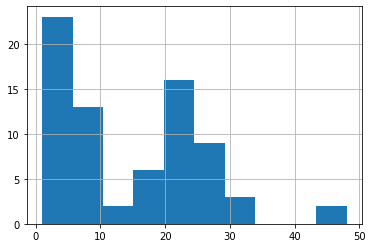

In [226]:
print (df_demand_movement_type_filtered_lt_SKUs_filtered_test['(Self) Quantity +/- flipped'].std())
print (df_forecast_lines_test['(Self) Quantity'].std())
df_demand_movement_type_filtered_lt_SKUs_filtered_test['(Self) Quantity +/- flipped'].hist()


<AxesSubplot:>

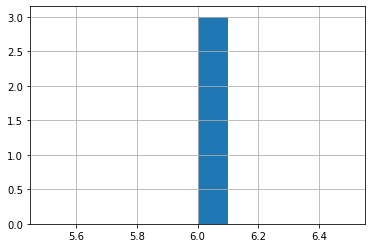

In [227]:
df_forecast_lines_test['(Self) Quantity'].hist()

Issue discovered - scale of forecast lines different to that of material docs demand. Go back and scale properly. 

From the histogram above, we see that the forecast lines demand is not on a daily scale. We corrected for it by not including forecast lines in the std_dev_demand calculation.

#### Check mean_lead_time and std_dev_lead_time

In [228]:
df_lt_demand_SKUs_filtered_test = df_lt_demand_SKUs_filtered[
    df_lt_demand_SKUs_filtered['Plant-Material'] == test_SKU
]

df_lt_demand_SKUs_filtered_test.describe()



#df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'] = pd.to_datetime(df_lt_demand_SKUs_filtered['(Self) Date of Goods Receipt'], format="%d-%m-%Y", errors='coerce')
#df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date'] = pd.to_datetime(df_lt_demand_SKUs_filtered['LastPrintMessageZNEU Processing date'], format="%d-%m-%Y", errors='coerce')
#df_lt_demand_SKUs_filtered.head()

,(Self) Quantity,Vendor Vendor,(Self) Ordered Value,Lead-time in days
count,33.00,33.00,33.00,31.00
mean,29.58,2017242.00,12296.70,157.55
std,23.74,0.00,10693.93,64.35
min,1.00,2017242.00,0.00,13.00
25%,13.00,2017242.00,4056.80,111.50
50%,24.00,2017242.00,9600.00,124.00
75%,46.00,2017242.00,18661.28,216.00
max,114.00,2017242.00,49682.34,291.00


In [229]:
df_lt_demand_SKUs_filtered_test.head(50)

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,Vendor Vendor,Vendor Description,PD Header Purch. Doc. Category,PD Item Item Category,Material Plant MRP Controller,PD Header Purchasing Group,(Self) Order Status Purchase,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material,Lead-time in days
584,PD Schedule Line,4502603770/10/1,EN01 (ERIKS BV),EN01,Closed,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,50.00,Piece,ASML WS CAM DISC ASSY F2 4022.455.54535,2017242.00,Mparts BV,F (Purchase Order),0 (Standard),EN01\N82 (CLEANROOM - 2),S08 (P.C. Weber),Closed by GR,22-09-2018,Delivered early,False,20000.00,2018-09-03,2018-06-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112492744,80.00
585,PD Schedule Line,4502603770/20/1,EN01 (ERIKS BV),EN01,Closed,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,13.00,Piece,ASML WS CAM DISC ASSY F2 4022.455.54535,2017242.00,Mparts BV,F (Purchase Order),0 (Standard),EN01\N82 (CLEANROOM - 2),S08 (P.C. Weber),Closed by GR,19-12-2018,Delivered early,False,5200.00,2018-09-10,2018-06-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112492744,87.00
586,PD Schedule Line,4502603770/20/2,EN01 (ERIKS BV),EN01,Closed,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,37.00,Piece,ASML WS CAM DISC ASSY F2 4022.455.54535,2017242.00,Mparts BV,F (Purchase Order),0 (Standard),EN01\N82 (CLEANROOM - 2),S08 (P.C. Weber),Closed by GR,19-12-2018,Delivered on time,False,14800.00,2018-12-20,2018-06-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112492744,188.00
587,PD Schedule Line,4502603770/30/1,EN01 (ERIKS BV),EN01,Closed,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,50.00,Piece,ASML WS CAM DISC ASSY F2 4022.455.54535,2017242.00,Mparts BV,F (Purchase Order),0 (Standard),EN01\N82 (CLEANROOM - 2),S08 (P.C. Weber),Closed by GR,19-12-2018,Delivered on time,False,20000.00,2018-12-20,2018-06-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112492744,188.00
588,PD Schedule Line,4502603770/40/1,EN01 (ERIKS BV),EN01,Closed,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,24.00,Piece,ASML WS CAM DISC ASSY F2 4022.455.54535,2017242.00,Mparts BV,F (Purchase Order),0 (Standard),EN01\N82 (CLEANROOM - 2),S08 (P.C. Weber),Closed by GR,06-03-2019,Delivered early,False,9600.00,2018-12-20,2018-06-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112492744,188.00
589,PD Schedule Line,4502603770/40/2,EN01 (ERIKS BV),EN01,Closed,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,10.00,Piece,ASML WS CAM DISC ASSY F2 4022.455.54535,2017242.00,Mparts BV,F (Purchase Order),0 (Standard),EN01\N82 (CLEANROOM - 2),S08 (P.C. Weber),Closed by GR,06-03-2019,Delivered early,False,4000.00,2019-02-07,2018-06-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112492744,237.00
590,PD Schedule Line,4502603770/40/3,EN01 (ERIKS BV),EN01,Closed,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,16.00,Piece,ASML WS CAM DISC ASSY F2 4022.455.54535,2017242.00,Mparts BV,F (Purchase Order),0 (Standard),EN01\N82 (CLEANROOM - 2),S08 (P.C. Weber),Closed by GR,06-03-2019,Delivered on time,False,6400.00,2019-03-05,2018-06-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112492744,263.00
4271,PD Schedule Line,4502705806/10/1,EN01 (ERIKS BV),EN01,Closed,12492744,ASML WS CAM DISC ASSY F2 4022.455.54535,34.00,Piece,ASML WS CAM DISC ASSY F2 4022.455.54535,2017242.00,Mparts BV,F (Purchase Order),0 (Standard),EN01\N82 (CLEANROOM - 2),S08 (P.C. Weber),Closed by GR,15-07-2019,Delivered early,False,13600.00,2019-03-05,2018-11-23,A (Significant Material),VPFZ,NORM (Standard item),EN0112492744,102.00
4272,PD Schedule Line,4502705806/10/2,EN01 (ERIKS BV),EN01,Cl

In [230]:
print (df_lt_demand_SKUs_filtered_test['Lead-time in days'].mean())
print (df_lt_demand_SKUs_filtered_test['Lead-time in days'].std())

157.5483870967742
64.34689254847635


## Convert safety stock results table to .csv

In [231]:
output_filename = 'Data/Safety_stocks_diagnostics_data/SS_diagnostics_'
timestr = time.strftime("%Y%m%d-%H%M%S")
extension = '.xlsx'
safety_stocks_df_with_SAP_ss_trimmed.to_excel(output_filename + timestr + extension, index = True)  

In [232]:
print (safety_stocks_df_with_SAP_ss_trimmed['Difference_in_SS_Value'].sum())

1315530.0924108732


# OTIF Calculations

We've been asked to provide more information on the business value of these improved safety stocks. Let's use the potential increase in % OTIF deliveries as a starting point. OTIF = On Time In Full. A delivery needs two things, to be OTIF:
1. Actual Goods Issue date (LIKP-WADAT_IST) < Requested Delivery Date (VBAK-VDATU).
2. Delivery Status (VBUP-LFSTA) to be C (Fully Delivered).

Let's calculate the difference (in %) between the DSL and the % OTIF, for each Plant-SKU ID:

## Import Delivery Data

This data has only VPV/VPZ planning profile articles, and ENXX plants.

In [233]:
filepath = r"Data\EA_Data\OTIF_Data_30_Aug_2021.csv"
df_otif = pd.read_csv(filepath, sep = ';')
df_otif.head()

,(Self) Object Type EA,(Self) ID,Delivery Header Delivery Type,(Self) Execution Status,(Self) Overall status,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Realized Finish Date,(Self) Issuing Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,Customer Customer,Customer Description,(Self) Picking status,(Self) WM activity status,(Self) Rejection status,Ship-to Party Ship-to Party,Ship-to Party Description,SD Item Delivery status,SD Header Requested deliv.date,(Self) Act. Gds Mvmnt Date,SD Item Sales Value,Material Plant EA_PROPERTY_PlanProfiel,SD Item Price per Unit,SD Item Margin
0,Delivery Item,84144816/10,LR (Returns Delivery),Open,Open,07-10-2016,Late,NaN,EN01,12616081,ASM NXT WS MK4I CRSH DMPR 642.26463 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C (Fully delivered),22-08-2016,NaN,0.00,VPFZ,0.00,191.76
1,Delivery Item,84144847/10,LR (Returns Delivery),Open,Open,28-10-2016,Late,NaN,EN01,12508183,M&G 1-lip DN80 EP 3665 980306/7 op rol,480.00,Piece,2006180.00,Burgerhout BV,NaN,NaN,(Nothing rejected),1695042.00,Burgerhout BV,C (Fully delivered),28-10-2016,NaN,-68.06,VPFZ,0.14,-21.75
2,Delivery Item,84158298/10,LR (Returns Delivery),Closed,Completed,18-05-2018,Delivered late,31-08-2018,EN01,13310026,ASM INSTA REQS SET FT FSSM 647.45182 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C (Fully delivered),30-03-2018,31-08-2018,-695.76,VPFZ,695.76,-254.73
3,Delivery Item,84158299/10,LR (Returns Delivery),Closed,Completed,25-05-2018,Delivered late,31-08-2018,EN01,13310026,ASM INSTA REQS SET FT FSSM 647.45182 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C (Fully delivered),04-04-2018,31-08-2018,-695.76,VPFZ,695.76,-254.73
4,Delivery Item,84158300/10,LR (Returns Delivery),Closed,Completed,28-03-2018,Delivered late,31-08-2018,EN01,12213727,ASM 115DGR PUSH IN 26x19 WA 647.00681CLR,7.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C (Fully delivered),19-01-2018,31-08-2018,-1330.35,VPFZ,190.05,-760.06


In [234]:
df_otif.describe()

,Material Material,(Self) Quantity,Customer Customer,Ship-to Party Ship-to Party,SD Item Sales Value,SD Item Price per Unit,SD Item Margin
count,82784.00,82784.00,81052.00,81202.00,78021.00,78021.00,78021.00
mean,12084784.88,2595.81,1243922.04,1509785.34,1333.35,151.78,441.45
std,1035711.57,19325.14,366793.58,350532.85,3463.32,672.76,2153.53
min,10014281.00,0.00,1000015.00,1000015.00,-11012.22,0.00,-17684.52
25%,11381068.00,2.00,1014626.00,1014626.00,100.35,0.15,15.26
50%,12308374.00,100.00,1016607.00,1688053.00,337.14,0.63,74.14
75%,12684792.00,1000.00,1676695.00,1736174.00,1045.00,4.92,296.20
max,14242281.00,960516.00,2008597.00,2008597.00,308475.00,19254.08,306323.05


In [235]:
df_otif['SD Header Requested deliv.date'] = pd.to_datetime(
    df_otif['SD Header Requested deliv.date'], 
    format="%d-%m-%Y", 
    errors='coerce')

print (min(df_otif['SD Header Requested deliv.date']))
#df_otif['SD Header Requested deliv.date'].hist()
df_otif['SD Header Requested deliv.date'].dt.year.value_counts()

2001-01-01 00:00:00


2020.00    25775
2019.00    24100
2021.00    20351
2018.00     7787
2001.00        5
2016.00        3
Name: SD Header Requested deliv.date, dtype: int64

## Clean Delivery Status Column

In [236]:
df_otif['SD Item Delivery status'] = df_otif['SD Item Delivery status'].str[:1]
print (len(df_otif))
df_otif['SD Item Delivery status'].value_counts()


82784


C    77909
B      112
Name: SD Item Delivery status, dtype: int64

## Deliv_Status_bool

In [237]:
df_otif['Deliv_status_bool'] = df_otif['SD Item Delivery status'] == 'C'
print (len(df_otif))
df_otif['Deliv_status_bool'].value_counts()

82784


True     77909
False     4875
Name: Deliv_status_bool, dtype: int64

So some extra blank values seem to have been lumped with 'B' delivery status, should be ok. We only care about % which are 'C', for any Plant-SKU combo. 

## On_time_bool

In [238]:
df_otif['SD Header Requested deliv.date'] = pd.to_datetime(
    df_otif['SD Header Requested deliv.date'], 
    format="%d-%m-%Y", 
    errors='coerce')

df_otif['(Self) Act. Gds Mvmnt Date'] = pd.to_datetime(
    df_otif['(Self) Act. Gds Mvmnt Date'], 
    format="%d-%m-%Y", 
    errors='coerce')

df_otif['On_time_bool'] = (df_otif['(Self) Act. Gds Mvmnt Date'] < df_otif['SD Header Requested deliv.date'])
df_otif['On_time_bool'].value_counts()

True     47760
False    35024
Name: On_time_bool, dtype: int64

In [239]:
df_otif.head(50)

,(Self) Object Type EA,(Self) ID,Delivery Header Delivery Type,(Self) Execution Status,(Self) Overall status,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Realized Finish Date,(Self) Issuing Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,Customer Customer,Customer Description,(Self) Picking status,(Self) WM activity status,(Self) Rejection status,Ship-to Party Ship-to Party,Ship-to Party Description,SD Item Delivery status,SD Header Requested deliv.date,(Self) Act. Gds Mvmnt Date,SD Item Sales Value,Material Plant EA_PROPERTY_PlanProfiel,SD Item Price per Unit,SD Item Margin,Deliv_status_bool,On_time_bool
0,Delivery Item,84144816/10,LR (Returns Delivery),Open,Open,07-10-2016,Late,NaN,EN01,12616081,ASM NXT WS MK4I CRSH DMPR 642.26463 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2016-08-22,NaT,0.00,VPFZ,0.00,191.76,True,False
1,Delivery Item,84144847/10,LR (Returns Delivery),Open,Open,28-10-2016,Late,NaN,EN01,12508183,M&G 1-lip DN80 EP 3665 980306/7 op rol,480.00,Piece,2006180.00,Burgerhout BV,NaN,NaN,(Nothing rejected),1695042.00,Burgerhout BV,C,2016-10-28,NaT,-68.06,VPFZ,0.14,-21.75,True,False
2,Delivery Item,84158298/10,LR (Returns Delivery),Closed,Completed,18-05-2018,Delivered late,31-08-2018,EN01,13310026,ASM INSTA REQS SET FT FSSM 647.45182 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-03-30,2018-08-31,-695.76,VPFZ,695.76,-254.73,True,False
3,Delivery Item,84158299/10,LR (Returns Delivery),Closed,Completed,25-05-2018,Delivered late,31-08-2018,EN01,13310026,ASM INSTA REQS SET FT FSSM 647.45182 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-04-04,2018-08-31,-695.76,VPFZ,695.76,-254.73,True,False
4,Delivery Item,84158300/10,LR (Returns Delivery),Closed,Completed,28-03-2018,Delivered late,31-08-2018,EN01,12213727,ASM 115DGR PUSH IN 26x19 WA 647.00681CLR,7.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-01-19,2018-08-31,-1330.35,VPFZ,190.05,-760.06,True,False
5,Delivery Item,84158301/10,LR (Returns Delivery),Closed,Completed,19-07-2018,Delivered late,31-08-2018,EN01,12630923,ASM DN50 2 NPT FEMALE CONN 642.47342 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-05-04,2018-08-31,-247.57,VPFZ,247.57,-153.43,True,False
6,Delivery Item,84158302/10,LR (Returns Delivery),Closed,Completed,14-06-2018,Delivered late,31-08-2018,EN01,12678969,ASM Hs nut DN50 2x90g 637.13753 Witz CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-05-16,2018-08-31,-557.81,VPFZ,557.81,-141.12,True,False
7,Delivery Item,84158303/10,LR (Returns Delivery),Closed,Completed,14-06-2018,Delivered late,31-08-2018,EN01,12678969,ASM Hs nut DN50 2x90g 637.13753 Witz CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-05-16,2018-08-31,-557.81,VPFZ,557.81,-141.12,True,False
8,Delivery Item,84158304/10,LR (Returns Delivery),Closed,Completed,14-06-2018,Delivered late,31-08-2018,EN01,12678969,ASM Hs nut DN50 2x90g 637.13753 Witz CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-05-16,2018-08-31,-557.81,VPFZ,557.81,-141.12,True,False
9,Delivery Item,84158305/10,LR (Returns Delivery),Closed,Completed,04-07-2018,Delivered late,31-08-2018,EN01,12678972,ASM HOSE DN15 VLV 642.80202 Wtz CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-06-06,2018-08-31,-389.43,VPFZ,389.43,-105.17,True,False


In [240]:
print (df_otif['(Self) ID'].nunique())

82784


In [241]:
print (len(df_otif))

82784


Okay, so it looks like the Delivery Items are unique. I.e. if it gets partially fulfilled, there won't be a repeated entry, and so we don't have to seek out the latest 'actual goods issue' date. I think. 

In [242]:
df_otif['OTIF_bool'] = (df_otif['Deliv_status_bool'] & df_otif['On_time_bool'])

## SKU-Plant IDs

In [243]:
df_otif['(Self) Issuing Plant'].value_counts()
df_otif['Plant-Material'] = df_otif['(Self) Issuing Plant'] + df_otif['Material Material'].astype(str) 
df_otif.head()

,(Self) Object Type EA,(Self) ID,Delivery Header Delivery Type,(Self) Execution Status,(Self) Overall status,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Realized Finish Date,(Self) Issuing Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,Customer Customer,Customer Description,(Self) Picking status,(Self) WM activity status,(Self) Rejection status,Ship-to Party Ship-to Party,Ship-to Party Description,SD Item Delivery status,SD Header Requested deliv.date,(Self) Act. Gds Mvmnt Date,SD Item Sales Value,Material Plant EA_PROPERTY_PlanProfiel,SD Item Price per Unit,SD Item Margin,Deliv_status_bool,On_time_bool,OTIF_bool,Plant-Material
0,Delivery Item,84144816/10,LR (Returns Delivery),Open,Open,07-10-2016,Late,NaN,EN01,12616081,ASM NXT WS MK4I CRSH DMPR 642.26463 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2016-08-22,NaT,0.00,VPFZ,0.00,191.76,True,False,False,EN0112616081
1,Delivery Item,84144847/10,LR (Returns Delivery),Open,Open,28-10-2016,Late,NaN,EN01,12508183,M&G 1-lip DN80 EP 3665 980306/7 op rol,480.00,Piece,2006180.00,Burgerhout BV,NaN,NaN,(Nothing rejected),1695042.00,Burgerhout BV,C,2016-10-28,NaT,-68.06,VPFZ,0.14,-21.75,True,False,False,EN0112508183
2,Delivery Item,84158298/10,LR (Returns Delivery),Closed,Completed,18-05-2018,Delivered late,31-08-2018,EN01,13310026,ASM INSTA REQS SET FT FSSM 647.45182 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-03-30,2018-08-31,-695.76,VPFZ,695.76,-254.73,True,False,False,EN0113310026
3,Delivery Item,84158299/10,LR (Returns Delivery),Closed,Completed,25-05-2018,Delivered late,31-08-2018,EN01,13310026,ASM INSTA REQS SET FT FSSM 647.45182 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-04-04,2018-08-31,-695.76,VPFZ,695.76,-254.73,True,False,False,EN0113310026
4,Delivery Item,84158300/10,LR (Returns Delivery),Closed,Completed,28-03-2018,Delivered late,31-08-2018,EN01,12213727,ASM 115DGR PUSH IN 26x19 WA 647.00681CLR,7.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-01-19,2018-08-31,-1330.35,VPFZ,190.05,-760.06,True,False,False,EN0112213727


## Calculate % OTIF per Plant-SKU ID

In [244]:
df_otif_groupby = df_otif.groupby(['Plant-Material'])['OTIF_bool'].agg(lambda x: x.sum() / len(x)).reset_index().rename(columns = {'OTIF_bool':'percentage_OTIF'})

In [245]:
df_otif_groupby.head()

,Plant-Material,percentage_OTIF
0,EN0110014281,0.79
1,EN0110014530,0.00
2,EN0110014531,0.00
3,EN0110014532,1.00
4,EN0110014735,0.81


<AxesSubplot:>

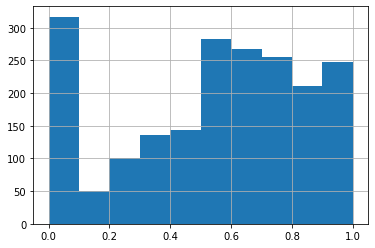

In [246]:
df_otif_groupby['percentage_OTIF'].hist()

In [247]:
df_otif_test = df_otif[df_otif['Plant-Material'] == 'EN0110014281']
len_test = len(df_otif_test)
OTIF_sum = df_otif_test['OTIF_bool'].sum()
print (len_test)
print (OTIF_sum)
print (OTIF_sum/len_test)

24
19
0.7916666666666666


## Join to safety stocks results df

In [248]:

safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF = pd.merge(safety_stocks_df_with_SAP_ss_trimmed, 
         df_otif_groupby[['Plant-Material', 'percentage_OTIF']], 
         left_index = True,
         right_on='Plant-Material',
         how = 'left').set_index('Plant-Material')


In [249]:
safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF.head(50)

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints,Percentage_change_SS,percentage_OTIF
Plant-Material,,,,,,,,,,,,,,,,,,,,,,
EN0112508180,A,98.00,2.05,6853.99,8039.53,154.00,36.81,1055514.71,600000,0.26,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ,156360.00,275067.13,118707.13,12.00,190,711,75.92,0.46
EN0112094423,A,98.00,2.05,921.86,2652.16,105.00,33.91,96795.37,35000,0.70,AT 040042.0-4 JOINT PORTE 212 714729,EN01\002 (O. DE HOOG),10530300 (Mldpart SI),VPFZ,24657.50,68192.34,43534.84,19.00,209,524,176.56,0.14
EN0111332256,A,98.00,2.05,1374.67,9708.46,336.00,41.51,461887.46,120000,0.12,M&G 1-lip DN100 EP 559268 20161057 grijs,EN01\002 (O. DE HOOG),10530220 (Mldpart EPDM),VPFZ,14904.00,57366.42,42462.42,12.00,58,226,284.91,0.34
EN0112659704,A,98.00,2.05,437.56,2543.23,203.00,58.52,88824.88,22000,0.62,M&G 1-lips DN80 514261 02 0910/4 br,EN01\002 (O. DE HOOG),10530250 (Mldpart FPM TÜV),VPFZ,13534.40,54645.07,41110.67,12.00,69,156,303.75,0.44
EN0113517182,A,98.00,2.05,0.19,2.74,140.00,22.62,27.17,3,1537.47,"ASM VLV PRES RLF 0,43MPA 1""NPT 489.75904",EN01\001 (R. BAKKER),02320030 (Press safety ASME),VPVZ,4612.41,41767.94,37155.53,0.00,25,39,805.56,NaN
EN0112718971,A,98.00,2.05,194.13,407.70,161.00,28.65,31254.63,0,1.14,REM Sealing Plate B 40kW 6528 128177-08,EN01\002 (O. DE HOOG),10530310 (Mldpart SI TÜV),VPFZ,0.00,35680.28,35680.28,0.00,42,260,0.00,0.19
EN0112092292,A,98.00,2.05,656.04,3230.38,112.00,38.33,73476.31,20000,0.58,"VAI O-Ring 202,57 X 6,99 EZ70/PC 3689",EN01\002 (O. DE HOOG),10220110 (O-ring EPDM 70 PC),VPFZ,11546.00,42417.88,30871.88,11.00,145,182,267.38,0.87
EN0112335326,A,98.00,2.05,2.53,8.76,140.00,75.48,354.33,80,108.78,ASM BALL VALVE HDL BW SST DN50 489.72796,EN01\001 (R. BAKKER),06925200 (ASML blocs),VPVZ,8702.40,38544.41,29842.01,0.00,55,250,342.92,NaN
EN0111334159,A,98.00,2.05,2462.64,19600.56,336.00,32.21,827448.63,264000,0.05,M&G stop Ø14mm 714245 030372/2 wit,EN01\002 (O. DE HOOG),10530300 (Mldpart SI),VPFZ,13780.80,43192.82,29412.02,10.00,63,195,213.43,0.29


## Sanity checks

In [250]:
print (len(safety_stocks_df_with_SAP_ss_trimmed))
print (len(safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF))

2038
2038


In [251]:
df_otif_test = df_otif[df_otif['Plant-Material'] == 'EN0112492744']
len_test = len(df_otif_test)
OTIF_sum = df_otif_test['OTIF_bool'].sum()
print (len_test)
print (OTIF_sum)
print (OTIF_sum/len_test)

58
36
0.6206896551724138


In [252]:
safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['DSL_minus_OTIF'] = (safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['DSL']/100.0) - safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['percentage_OTIF']

<AxesSubplot:>

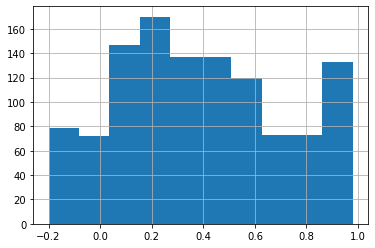

In [253]:
safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['DSL_minus_OTIF'].hist()

In [254]:
safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['DSL_minus_OTIF'].describe()

count   1141.00
mean       0.39
std        0.32
min       -0.20
25%        0.15
50%        0.35
75%        0.62
max        0.98
Name: DSL_minus_OTIF, dtype: float64

In [255]:
safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF.head()

,ABC_class,DSL,Z_score,mean_demand,std_dev_demand,mean_lead_time,std_dev_lead_time,safety_stock,Material Plant Safety Stock,V_or_S_Price_per_unit,Material Description,(Self) MRP Controller,Material Material Group,(Self) EA_PROPERTY_PlanProfiel,SAP_SS_Value,Proposed_SS_Value,Difference_in_SS_Value,n_forecast_datapoints,n_lead_time_datapoints,n_demand_datapoints,Percentage_change_SS,percentage_OTIF,DSL_minus_OTIF
Plant-Material,,,,,,,,,,,,,,,,,,,,,,,
EN0112508180,A,98.00,2.05,6853.99,8039.53,154.00,36.81,1055514.71,600000,0.26,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,EN01\002 (O. DE HOOG),10530230 (Mldpart EPDM TÜV),VPFZ,156360.00,275067.13,118707.13,12.00,190,711,75.92,0.46,0.52
EN0112094423,A,98.00,2.05,921.86,2652.16,105.00,33.91,96795.37,35000,0.70,AT 040042.0-4 JOINT PORTE 212 714729,EN01\002 (O. DE HOOG),10530300 (Mldpart SI),VPFZ,24657.50,68192.34,43534.84,19.00,209,524,176.56,0.14,0.84
EN0111332256,A,98.00,2.05,1374.67,9708.46,336.00,41.51,461887.46,120000,0.12,M&G 1-lip DN100 EP 559268 20161057 grijs,EN01\002 (O. DE HOOG),10530220 (Mldpart EPDM),VPFZ,14904.00,57366.42,42462.42,12.00,58,226,284.91,0.34,0.64
EN0112659704,A,98.00,2.05,437.56,2543.23,203.00,58.52,88824.88,22000,0.62,M&G 1-lips DN80 514261 02 0910/4 br,EN01\002 (O. DE HOOG),10530250 (Mldpart FPM TÜV),VPFZ,13534.40,54645.07,41110.67,12.00,69,156,303.75,0.44,0.54
EN0113517182,A,98.00,2.05,0.19,2.74,140.00,22.62,27.17,3,1537.47,"ASM VLV PRES RLF 0,43MPA 1""NPT 489.75904",EN01\001 (R. BAKKER),02320030 (Press safety ASME),VPVZ,4612.41,41767.94,37155.53,0.00,25,39,805.56,NaN,NaN


We're going to have to deal with: 
1. NaN OTIF %'s 
2. Zero for OTIF % 

If OTIF % is NaN, it most likely is from the length of the groupby of OTIF data being zero. So no delivery lines. So exclude these. 

If OTIF is zero, it most likely means there are zero deliveries on time. So we want to keep these. 


In [256]:
number_na_OTIFS = safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['percentage_OTIF'].isna().sum()
print (number_na_OTIFS)

897


In [257]:
n_SKUs = len(safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF)
print (n_SKUs)

2038


In [258]:
n_SKUs_with_delivery_lines = n_SKUs - number_na_OTIFS
print (n_SKUs_with_delivery_lines)

1141


Why is the number of SKUs with delivery items/lines so low?? That's a bit strange. Double check this.

In [259]:
total_percentage_points = safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['DSL_minus_OTIF'].sum()
print (total_percentage_points)

444.94363409411164


In [260]:
mean_OTIF_increase = total_percentage_points / n_SKUs_with_delivery_lines
print (mean_OTIF_increase)

0.3899593637985203


AxesSubplot(0.125,0.125;0.775x0.755)


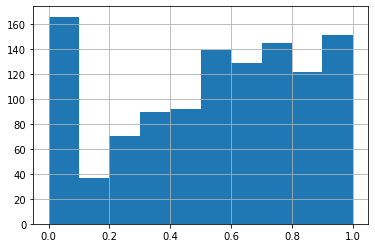

In [261]:
print (safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['percentage_OTIF'].hist())

In [262]:
print (safety_stocks_df_with_SAP_ss_trimmed_plus_OTIF['percentage_OTIF'].describe())

count   1141.00
mean       0.54
std        0.31
min        0.00
25%        0.33
50%        0.58
75%        0.79
max        1.00
Name: percentage_OTIF, dtype: float64


Come back to on Monday:
1. Check why so many SKUs don't seem to have OTIF data. 900/2100 VPV/VPF articles?
2. Meaningful to present potential % change in OTIF? Stock value of this % change in OTIF? Can frame it as 'at risk', 'securing' x Euros from leaving the company?

## Sanity check - low number of SKUs with delivery line data?

In [263]:
keys = list(safety_stocks_df_with_SAP_ss_trimmed.index.values)
print (len(keys))
mask = df_otif['Plant-Material'].isin(keys)
df_otif_cust_forecast_SKUs = df_otif[mask]

2038


In [264]:
df_otif_cust_forecast_SKUs['Plant-Material'].nunique()

1138

Okay, so it looks like only 1195 of the customer forecast SKUs have delivery line data. Strange, but fair enough. Ask about this later. 

For now, let's attach stock value information to the OTIF data, and sum up the stock value for all non-OTIF orders. 


## Attach stock value and margin data - calculate 'margin at risk' 

In [265]:
df_otif.head()

,(Self) Object Type EA,(Self) ID,Delivery Header Delivery Type,(Self) Execution Status,(Self) Overall status,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Realized Finish Date,(Self) Issuing Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,Customer Customer,Customer Description,(Self) Picking status,(Self) WM activity status,(Self) Rejection status,Ship-to Party Ship-to Party,Ship-to Party Description,SD Item Delivery status,SD Header Requested deliv.date,(Self) Act. Gds Mvmnt Date,SD Item Sales Value,Material Plant EA_PROPERTY_PlanProfiel,SD Item Price per Unit,SD Item Margin,Deliv_status_bool,On_time_bool,OTIF_bool,Plant-Material
0,Delivery Item,84144816/10,LR (Returns Delivery),Open,Open,07-10-2016,Late,NaN,EN01,12616081,ASM NXT WS MK4I CRSH DMPR 642.26463 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2016-08-22,NaT,0.00,VPFZ,0.00,191.76,True,False,False,EN0112616081
1,Delivery Item,84144847/10,LR (Returns Delivery),Open,Open,28-10-2016,Late,NaN,EN01,12508183,M&G 1-lip DN80 EP 3665 980306/7 op rol,480.00,Piece,2006180.00,Burgerhout BV,NaN,NaN,(Nothing rejected),1695042.00,Burgerhout BV,C,2016-10-28,NaT,-68.06,VPFZ,0.14,-21.75,True,False,False,EN0112508183
2,Delivery Item,84158298/10,LR (Returns Delivery),Closed,Completed,18-05-2018,Delivered late,31-08-2018,EN01,13310026,ASM INSTA REQS SET FT FSSM 647.45182 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-03-30,2018-08-31,-695.76,VPFZ,695.76,-254.73,True,False,False,EN0113310026
3,Delivery Item,84158299/10,LR (Returns Delivery),Closed,Completed,25-05-2018,Delivered late,31-08-2018,EN01,13310026,ASM INSTA REQS SET FT FSSM 647.45182 CLR,1.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-04-04,2018-08-31,-695.76,VPFZ,695.76,-254.73,True,False,False,EN0113310026
4,Delivery Item,84158300/10,LR (Returns Delivery),Closed,Completed,28-03-2018,Delivered late,31-08-2018,EN01,12213727,ASM 115DGR PUSH IN 26x19 WA 647.00681CLR,7.00,Piece,1017146.00,ASML Netherlands BV,NaN,NaN,(Nothing rejected),1694899.00,ASML Netherlands *Gebouw 21*,C,2018-01-19,2018-08-31,-1330.35,VPFZ,190.05,-760.06,True,False,False,EN0112213727


In [266]:
df_otif['SD Item Sales Value'].describe()

count    78021.00
mean      1333.35
std       3463.32
min     -11012.22
25%        100.35
50%        337.14
75%       1045.00
max     308475.00
Name: SD Item Sales Value, dtype: float64

In [267]:
total_stock_value_non_otif_deliveries = df_otif.loc[df_otif['OTIF_bool'] == False, 'SD Item Sales Value'].sum()
print (total_stock_value_non_otif_deliveries)

39798445.5663097


Woah, that's huge. So this is the stock value which is being delivered non-OTIF. 

But, I just realised that this isn't what's most important. What is most important is the profit/margin that's at stake. So I added that to the EA extract, and let's take a look at it's value:

In [268]:
total_margin_non_otif_deliveries = df_otif.loc[df_otif['OTIF_bool'] == False, 'SD Item Margin'].sum()
print (total_margin_non_otif_deliveries)

12613652.2276982


Wow, is that right? 12 million margin on just these SKUs? That seems too high. Well, I suppose if it's all delivery lines we've ever had, for all our customer forecast SKUs...

Let's do some back-of-the-envelope calculations. Let's say that 5% of this value is at risk, when we deliver it non-OTIF. That's:

In [269]:
print ((total_margin_non_otif_deliveries/100.0) * 5.0)

630682.61138491


That's about 631K Euros per year. Now, let's say that, increasing the safety stock levels to the proposed levels would reduce the likelihood of an order being non-OTIF by 50%. 

That would mean, that increasing the safety stocks to the proposed levels could save ERIKS around 315K Euros per year, in terms of orders that are 'at risk', due to them being non-OTIF. Customers don't like that we can't deliver on time, and so they might go elsewhere. 

Data seems to start around 2018 (some earlier dates which we'll ignore for now). 

That's around 3.5 years of data. So let's divide 315k by 3.5:


In [270]:
print (630682.61138491 / (2*3.5))

90097.51591213


That's around 90K, if you set the value at risk % at 1%, and the 'influence of improved safety stocks' at 50%. 

# Second stage diagnostics 

## Filter out negative demand quantities?

Are negative demand quantities inflating the standard deviation calculations? Let's see how many there are:

In [271]:
df_negative_demand = df_demand_movement_type_filtered_lt_SKUs_filtered[
    df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/- flipped'] < 0]
df_positive_demand = df_demand_movement_type_filtered_lt_SKUs_filtered[
    df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/- flipped'] > 0]
print (len(df_negative_demand))
print (len(df_positive_demand))

print (df_negative_demand['Plant-Material'].nunique())
print (df_positive_demand['Plant-Material'].nunique())

3362
142161
744
2152


So 744 out of 2150ish SKUs have negative demand amounts.

Let's filter out negative demand amounts, to bring down the standard deviation values.

In [272]:
print (len(df_demand_movement_type_filtered_lt_SKUs_filtered))
print (df_demand_movement_type_filtered_lt_SKUs_filtered['Plant-Material'].nunique())

df_demand_movement_type_filtered_lt_SKUs_filtered = df_demand_movement_type_filtered_lt_SKUs_filtered[
    df_demand_movement_type_filtered_lt_SKUs_filtered['(Self) Quantity +/- flipped'] >= 0]


print (len(df_demand_movement_type_filtered_lt_SKUs_filtered))
print (df_demand_movement_type_filtered_lt_SKUs_filtered['Plant-Material'].nunique())

145523
2152
142161
2152


## Diagnostic plots

In [285]:
SKU_for_analysis = 'EN0112508180'

Quantities to visualise:
1. Historic demand amounts 
2. Historic lead-times 
3. Mean demand, on historic demand viz
4. Mean lead-time, on historic lead-time viz 
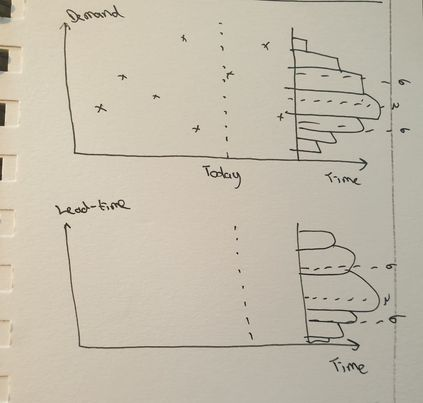

## Demand plot

In [286]:
#df_demand_movement_type_filtered_lt_SKUs_filtered.describe()

In [287]:
#df_forecast_lines.head()

In [288]:
#df_demand_movement_type_filtered_lt_SKUs_filtered.head()

In [289]:
df_demand_SKU_for_analysis = df_demand_movement_type_filtered_lt_SKUs_filtered[
    df_demand_movement_type_filtered_lt_SKUs_filtered['Plant-Material'] == SKU_for_analysis]

df_forecast_lines_SKU_for_analysis = df_forecast_lines[
    df_forecast_lines['Plant-Material'] == SKU_for_analysis]

df_demand_SKU_for_analysis.describe()

,(Self) Quantity,(Self) Valuated stock,(Self) Quantity +/-,(Self) Quantity +/- flipped
count,711.00,711.00,711.00,711.00
mean,12061.05,243204.17,-12061.05,12061.05
std,8039.53,175779.71,8039.53,8039.53
min,80.00,80.00,-73440.00,80.00
25%,8640.00,90240.00,-17280.00,8640.00
50%,8640.00,187680.00,-8640.00,8640.00
75%,17280.00,419040.00,-8640.00,17280.00
max,73440.00,591840.00,-80.00,73440.00


In [290]:
df_demand_SKU_for_analysis.head(50)

,(Self) Object Type EA,(Self) ID,MDoc Header Posting Date,(Self) Movement Type,MDoc Header Document Type,Material Material,Material Description,(Self) Quantity,(Self) Valuated stock,Material Base Unit of Measure,Plant Plant,(Self) Debit/Credit Ind.,(Self) Quantity +/-,MDoc Header User name,(Self) Text,(Self) Storage Location,Material Plant EA_PROPERTY_PlanProfiel,Material Plant ABC Indicator,(Self) Reason for Movement,(Self) Base Unit of Measure,(Self) Movement Type - code,Plant-Material,(Self) Item category group - code,(Self) Quantity +/- flipped
110,MDoc Item,171791481/2018/1,2018-01-02,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,8640.00,267120.00,Piece,EN01,H,-8640.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,8640.00
117,MDoc Item,171791484/2018/5,2018-01-02,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,12960.00,258480.00,Piece,EN01,H,-12960.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,12960.00
280,MDoc Item,171802322/2018/4,2018-01-03,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,8640.00,245520.00,Piece,EN01,H,-8640.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,8640.00
467,MDoc Item,171815609/2018/1,2018-01-04,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,8640.00,236880.00,Piece,EN01,H,-8640.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,8640.00
468,MDoc Item,171815620/2018/1,2018-01-04,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,12960.00,228240.00,Piece,EN01,H,-12960.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,12960.00
477,MDoc Item,171815623/2018/6,2018-01-04,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,8640.00,215280.00,Piece,EN01,H,-8640.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,8640.00
478,MDoc Item,171815623/2018/7,2018-01-04,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,4320.00,215280.00,Piece,EN01,H,-4320.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,4320.00
917,MDoc Item,171837406/2018/2,2018-01-08,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,12960.00,202320.00,Piece,EN01,H,-12960.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,12960.00
921,MDoc Item,171837407/2018/1,2018-01-08,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,8640.00,189360.00,Piece,EN01,H,-8640.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,8640.00
1359,MDoc Item,171868441/2018/1,2018-01-11,601 (GD goods issue:delvy),WL (Goods issue/delivery),12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,8640.00,180720.00,Piece,EN01,H,-8640.00,JOBEN01,NaN,EN01\EN01 (Mag.Alkmaar),VPFZ,A (Significant Material),601\0,Piece (items),601,EN0112508180,NORM,8640.00


In [291]:
df_forecast_lines_SKU_for_analysis.describe()

,(Self) Quantity,(Self) Quantity Closed,(Self) Quantity Open,(Self) Material Value,(Self) Open Quantity Value,(Self) Created On,(Self) Forecast Realization %,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock
count,12.00,12.00,12.00,12.00,12.00,0.00,12.00,12.00,12.00,0.00
mean,240372.00,3600.00,236772.00,34108.66,33597.82,NaN,1.00,0.01,238.39,NaN
std,27144.19,12470.77,19787.69,3851.75,2807.86,NaN,0.00,0.02,825.81,NaN
min,213840.00,0.00,213840.00,30343.78,30343.78,NaN,1.00,0.00,0.00,NaN
25%,218592.00,0.00,218592.00,31018.09,31018.09,NaN,1.00,0.00,0.00,NaN
50%,235224.00,0.00,235224.00,33378.16,33378.16,NaN,1.00,0.00,0.00,NaN
75%,247104.00,0.00,247104.00,35063.92,35063.92,NaN,1.00,0.00,0.00,NaN
max,304128.00,43200.00,280368.00,43155.60,39784.07,NaN,1.00,0.07,2860.69,NaN


In [292]:
df_forecast_lines_SKU_for_analysis.head()

,(Self) Object Type EA,(Self) ID,(Self) Execution Status,Plant Plant,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,(Self) Quantity Closed,(Self) Quantity Open,(Self) Order Due Date,(Self) Delivery Reliability,(Self) Bottleneck Type,(Self) Planning indicator,(Self) Material Value,(Self) Open Quantity Value,(Self) Consumption ind.,(Self) Created On,(Self) Forecast Covers Current Date,(Self) Forecast Realization %,(Self) Order Nos. Consuming Orders,(Self) Stock Availability % Claimed,(Self) Claimed Stocks Val.,(Self) Special Stock,(Self) MRP Relevant,Plant-Material,"max(furthest date, today)"
4626,Indep. Req.,VSF 2021-09-01/202109,Open,EN01,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,280368.00,Piece,0,280368.00,2021-09-01,Critical,Planning timing,1 (Net requirements planning),39784.07,39784.07,1 (Consume only with customer requirements),NaN,False,1.00,NaN,0.07,2860.69,NaN,True,EN0112508180,2022-08-01
4627,Indep. Req.,VSF 2021-10-01/202110,Partially open,EN01,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,304128.00,Piece,43200,260928.00,2021-10-01,Critical,Planning timing,1 (Net requirements planning),43155.60,37025.54,1 (Consume only with customer requirements),NaN,False,1.00,351530908/20/1,0.00,0.00,NaN,True,EN0112508180,2022-08-01
4628,Indep. Req.,VSF 2021-11-01/202111,Open,EN01,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,247104.00,Piece,0,247104.00,2021-11-01,Critical,Planning timing,1 (Net requirements planning),35063.92,35063.92,1 (Consume only with customer requirements),NaN,False,1.00,NaN,0.00,0.00,NaN,True,EN0112508180,2022-08-01
4629,Indep. Req.,VSF 2021-12-01/202112,Open,EN01,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,237600.00,Piece,0,237600.00,2021-12-01,Critical,Planning timing,1 (Net requirements planning),33715.31,33715.31,1 (Consume only with customer requirements),NaN,False,1.00,NaN,0.00,0.00,NaN,True,EN0112508180,2022-08-01
4630,Indep. Req.,VSF 2022-01-03/202201,Open,EN01,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,247104.00,Piece,0,247104.00,2022-01-03,Critical,Planning timing,1 (Net requirements planning),35063.92,35063.92,1 (Consume only with customer requirements),NaN,False,1.00,NaN,0.00,0.00,NaN,True,EN0112508180,2022-08-01


In [293]:
df_demand_SKU_for_analysis['MDoc Header Posting Date'].nunique()

391

In [294]:
#df_demand_SKU_for_analysis.head(50)

In [295]:
#df_forecast_lines_SKU_for_analysis.describe()

0.01      240.00
0.16     4320.00
0.25     8640.00
0.50     8640.00
0.75    17280.00
0.84    17280.00
0.99   226005.12
dtype: float64


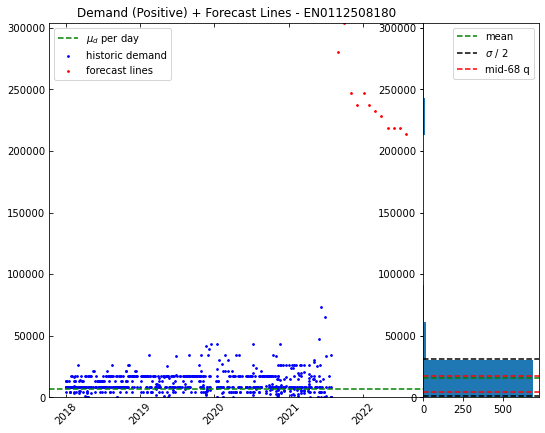

In [296]:
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.00


rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)

x_demand = df_demand_SKU_for_analysis['MDoc Header Posting Date']
y_demand = df_demand_SKU_for_analysis['(Self) Quantity +/- flipped']

x_forecast_lines = df_forecast_lines_SKU_for_analysis['(Self) Order Due Date']
y_forecast_lines = df_forecast_lines_SKU_for_analysis['(Self) Quantity']

y_demand_plus_forecast_lines = pd.concat([y_demand, y_forecast_lines])
mean_demand_plus_forecast_lines = np.mean(y_demand_plus_forecast_lines)
std_demand_plus_forecast_lines = np.std(y_demand_plus_forecast_lines)
                                          
                                                                 
# the scatter plot:
ax_scatter.scatter(x_demand, y_demand, color = 'b', s = 3.0, label = 'historic demand')
ax_scatter.scatter(x_forecast_lines, y_forecast_lines, color = 'r', s = 3.0, label = 'forecast lines')
ax_scatter.set_ylim([0, max(y_demand_plus_forecast_lines)])

# now determine nice limits by hand:

print (y_demand_plus_forecast_lines.quantile([.01, .16, .25, .5, .75, .84, .99]))
quantile_16 = y_demand_plus_forecast_lines.quantile([0.16])
quantile_84 = y_demand_plus_forecast_lines.quantile([0.84])

ax_histy.hist(y_demand_plus_forecast_lines, orientation='horizontal')
ax_histy.axhline(mean_demand_plus_forecast_lines, linestyle = '--', color = 'g', label = 'mean')
ax_histy.axhline(mean_demand_plus_forecast_lines + std_demand_plus_forecast_lines/2.0, linestyle = '--', color = 'k', label = '$\sigma$ / 2')
ax_histy.axhline(mean_demand_plus_forecast_lines - std_demand_plus_forecast_lines/2.0, linestyle = '--', color = 'k')
ax_histy.axhline(quantile_16.values, linestyle = '--', color = 'r', label = 'mid-68 q')
ax_histy.axhline(quantile_84.values, linestyle = '--', color = 'r')
ax_histy.set_ylim([0, max(y_demand_plus_forecast_lines)])

ax_histy.legend()

ax_scatter.tick_params(axis='x', rotation=45)
ax_scatter.set_title('Demand (Positive) + Forecast Lines' + ' - ' + SKU_for_analysis)

mean_demand_per_day = safety_stocks_df_with_SAP_ss_trimmed.loc[SKU_for_analysis, 'mean_demand']
ax_scatter.axhline(mean_demand_per_day, label = '$\mu_{d}$ per day', linestyle = '--', color = 'g')
ax_scatter.legend()

plt.show()

## Lead-time plot

In [297]:
df_lt_demand_SKUs_filtered.head()

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,Vendor Vendor,Vendor Description,PD Header Purch. Doc. Category,PD Item Item Category,Material Plant MRP Controller,PD Header Purchasing Group,(Self) Order Status Purchase,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material,Lead-time in days
0,PD Schedule Line,4200052434/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,500.00,Piece,ASM BEWARE CLR PROD 25x60 488.40401,2018752.00,Back Stickers International BV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),N12 (R Lamain),Closed by GR,28-01-2021,Delivered on time,False,300.00,2021-01-26,2021-01-18,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447,8.00
1,PD Schedule Line,4200053371/10/1,EN01 (ERIKS BV),EN01,Closed,14038447,ASM BEWARE CLR PROD 25x60 488.40401,1000.00,Piece,ASM BEWARE CLR PROD 25x60 488.40401,2018752.00,Back Stickers International BV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),N12 (R Lamain),Closed by GR,22-03-2021,Delivered on time,False,400.00,2021-03-19,2021-03-10,C (Material - Low Significance),VPVZ,NORM (Standard item),EN0114038447,9.00
2,PD Schedule Line,4200053855/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.00,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,2002419.00,Viba NV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),LA4 (S. Groot),Closed by GR,14-04-2021,Delivered late,False,266.12,2021-04-16,2021-04-07,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596,9.00
3,PD Schedule Line,4200054135/10/1,EN01 (ERIKS BV),EN01,Closed,11480596,ASM CARTR. ARALDIT 2030 50ML 439.80107,12.00,Piece,ASM CARTR. ARALDIT 2030 50ML 439.80107,2002419.00,Viba NV,F (Purchase Order),0 (Standard),EN01\001 (R. BAKKER),LA4 (S. Groot),Closed by GR,17-05-2021,Delivered on time,False,266.12,2021-05-14,2021-04-23,B (Material - Medium Significance),VPVZ,NORM (Standard item),EN0111480596,21.00
4,PD Schedule Line,4502508772/10/1,EN01 (ERIKS BV),EN01,Closed,13283620,ATAG EC Housing iCon 1 PP EP548 C60749A,840.00,Piece,ATAG EC Housing iCon 1 PP EP548 C60749A,2025867.00,Premier Engineering (HK) Limited,F (Purchase Order),0 (Standard),EN01\005 (Cornel l'Ami),N08 (Harald Regter),Closed by GR,28-11-2018,Delivered early,False,2562.00,2018-08-09,2018-01-02,A (Significant Material),VPFZ,NORM (Standard item),EN0113283620,219.00


190
0.01    51.61
0.16    84.04
0.25    92.00
0.50   120.00
0.75   152.75
0.84   163.00
0.99   195.07
Name: Lead-time in days, dtype: float64


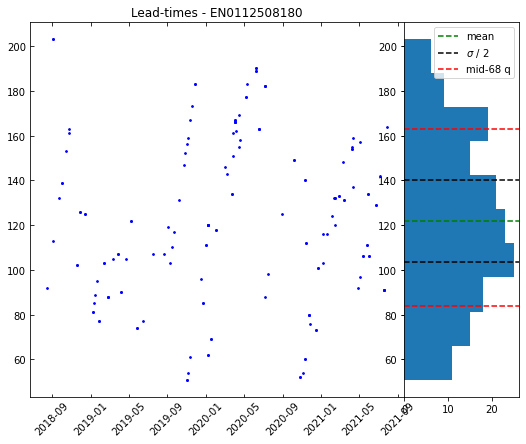

In [298]:
df_lt_SKU_for_analysis = df_lt_demand_SKUs_filtered[
    df_lt_demand_SKUs_filtered['Plant-Material'] == SKU_for_analysis]

print (len(df_lt_SKU_for_analysis))
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.00

rect_scatter = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histy = plt.axes(rect_histy)

x_lt = df_lt_SKU_for_analysis['(Self) Date of Goods Receipt']
y_lt = df_lt_SKU_for_analysis['Lead-time in days']

mean_lt = np.mean(y_lt)
std_lt = np.std(y_lt)
                                          
                                                                 
# the scatter plot:
ax_scatter.scatter(x_lt, y_lt, color = 'b', s = 3.0)

# now determine nice limits by hand:

print (y_lt.quantile([.01, .16, .25, .5, .75, .84, .99]))
quantile_16 = y_lt.quantile([0.16])
quantile_84 = y_lt.quantile([0.84])

ax_histy.hist(y_lt, orientation='horizontal')
ax_histy.axhline(mean_lt, linestyle = '--', color = 'g', label = 'mean')
ax_histy.axhline(mean_lt + std_lt/2.0, linestyle = '--', color = 'k', label = '$\sigma$ / 2')
ax_histy.axhline(mean_lt - std_lt/2.0, linestyle = '--', color = 'k')
ax_histy.axhline(quantile_16.values, linestyle = '--', color = 'r', label = 'mid-68 q')
ax_histy.axhline(quantile_84.values, linestyle = '--', color = 'r')
ax_histy.legend()

ax_scatter.tick_params(axis='x', rotation=45)
ax_scatter.set_title('Lead-times' + ' - ' + SKU_for_analysis)
plt.show()

In [299]:
df_lt_SKU_for_analysis.describe()

,(Self) Quantity,Vendor Vendor,(Self) Ordered Value,Lead-time in days
count,190.00,190.00,190.00,162.00
mean,48932.21,2025962.00,5913.38,121.87
std,36748.32,0.00,4459.69,36.81
min,80.00,2025962.00,0.00,51.00
25%,17280.00,2025962.00,2175.55,92.00
50%,43200.00,2025962.00,5063.04,120.00
75%,74880.00,2025962.00,9246.10,152.75
max,124800.00,2025962.00,14626.56,203.00


In [300]:
df_lt_SKU_for_analysis.head(10)

,(Self) Object Type EA,(Self) ID,Purchase Org. Purchase Org.,Plant Plant,(Self) Execution Status,Material Material,Material Description,(Self) Quantity,Material Base Unit of Measure,PD Item Short Text,Vendor Vendor,Vendor Description,PD Header Purch. Doc. Category,PD Item Item Category,Material Plant MRP Controller,PD Header Purchasing Group,(Self) Order Status Purchase,(Self) Order Due Date,(Self) Delivery Reliability,(Self) MRP Relevant,(Self) Ordered Value,(Self) Date of Goods Receipt,LastPrintMessageZNEU Processing date,Material Plant ABC Indicator,Material Plant EA_PROPERTY_PlanProfiel,Material Sales Item category group,Plant-Material,Lead-time in days
22,PD Schedule Line,4502535574/10/1,EN01 (ERIKS BV),EN01,Closed,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,80.00,Piece,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,2025962.00,"Tai Thai Rubber Co.,Ltd",F (Purchase Order),0 (Standard),EN01\002 (O. DE HOOG),N18 (S. Man),Closed by GR,30-08-2018,Delivered late,False,0.01,2018-09-03,2018-02-12,A (Significant Material),VPFZ,NORM (Standard item),EN0112508180,203.00
23,PD Schedule Line,4502535574/20/1,EN01 (ERIKS BV),EN01,Closed,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,400.00,Piece,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,2025962.00,"Tai Thai Rubber Co.,Ltd",F (Purchase Order),0 (Standard),EN01\002 (O. DE HOOG),N18 (S. Man),Closed by GR,30-08-2018,Delivered late,False,0.04,2018-09-03,2018-02-12,A (Significant Material),VPFZ,NORM (Standard item),EN0112508180,203.00
471,PD Schedule Line,4502595572/10/1,EN01 (ERIKS BV),EN01,Closed,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,108000.00,Piece,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,2025962.00,"Tai Thai Rubber Co.,Ltd",F (Purchase Order),0 (Standard),EN01\002 (O. DE HOOG),N18 (S. Man),Closed by GR,01-10-2018,Delivered early,False,13597.20,2018-08-15,2018-05-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112508180,92.00
472,PD Schedule Line,4502595574/10/1,EN01 (ERIKS BV),EN01,Closed,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,108000.00,Piece,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,2025962.00,"Tai Thai Rubber Co.,Ltd",F (Purchase Order),0 (Standard),EN01\002 (O. DE HOOG),N18 (S. Man),Closed by GR,15-10-2018,Delivered early,False,13597.20,2018-09-05,2018-05-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112508180,113.00
473,PD Schedule Line,4502595575/10/1,EN01 (ERIKS BV),EN01,Closed,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,86400.00,Piece,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,2025962.00,"Tai Thai Rubber Co.,Ltd",F (Purchase Order),0 (Standard),EN01\002 (O. DE HOOG),N18 (S. Man),Closed by GR,05-11-2018,Delivered early,False,10877.76,2018-09-24,2018-05-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112508180,132.00
474,PD Schedule Line,4502595575/10/2,EN01 (ERIKS BV),EN01,Closed,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,21600.00,Piece,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,2025962.00,"Tai Thai Rubber Co.,Ltd",F (Purchase Order),0 (Standard),EN01\002 (O. DE HOOG),N18 (S. Man),Closed by GR,05-11-2018,Delivered early,False,2719.44,2018-10-01,2018-05-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112508180,139.00
475,PD Schedule Line,4502595576/10/1,EN01 (ERIKS BV),EN01,Closed,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,90720.00,Piece,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,2025962.00,"Tai Thai Rubber Co.,Ltd",F (Purchase Order),0 (Standard),EN01\002 (O. DE HOOG),N18 (S. Man),Closed by GR,19-11-2018,Delivered early,False,11421.65,2018-10-01,2018-05-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112508180,139.00
476,PD Schedule Line,4502595576/10/2,EN01 (ERIKS BV),EN01,Closed,12508180,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,17280.00,Piece,M&G 2-lip Ø80x16 EPDM 3665 tk 080729/2,2025962.00,"Tai Thai Rubber Co.,Ltd",F (Purchase Order),0 (Standard),EN01\002 (O. DE HOOG),N18 (S. Man),Closed by GR,19-11-2018,Delivered early,False,2175.55,2018-10-15,2018-05-15,A (Significant Material),VPFZ,NORM (Standard item),EN0112508180,153.00


## Box plots of each safety stock quantity:

In [ ]:
safety_stocks_df_with_SAP_ss_trimmed.head()

In [ ]:
cols_for_boxplot = ['mean_demand',
                    'std_dev_demand',
                    'mean_lead_time',
                   'std_dev_lead_time']
#safety_stocks_df_with_SAP_ss_trimmed[cols_for_boxplot].boxplot()
safety_stocks_df_with_SAP_ss_trimmed[['mean_demand']].boxplot()
plt.yscale('log')

In [ ]:
safety_stocks_df_with_SAP_ss_trimmed[['std_dev_demand']].boxplot()
plt.yscale('log')

In [ ]:
safety_stocks_df_with_SAP_ss_trimmed[['mean_lead_time']].boxplot()


In [ ]:
safety_stocks_df_with_SAP_ss_trimmed[['std_dev_lead_time']].boxplot()
